### DATA CLEANING AND PREPROCESSING

**Importing necessary libraries and datasets**

In [2]:
#data manipulation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy #copy operrations
import time #time operations to check the code running time
from enum import Enum #creating enumerated constants

#scikit-learn libraries
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV #splitting the dataset, validation, and randomsearch hyperparameter tuning
from sklearn.metrics import mean_squared_error #evaluation metric
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler #data processing and scaling
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor #ensemble methods
from sklearn.svm import SVR

#gradient boosting
import xgboost as xgb

#statistical analysis
from scipy.stats import probplot #probability plot
from statsmodels.stats.outliers_influence import variance_inflation_factor #multicollinearity
import statsmodels.stats.api as sms #statmodels (breusch-Pagan test for homoscedasticity)
from statsmodels.tools import add_constant #aading a constant column

#lstm using tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential #stack layer model
from tensorflow.keras.layers import LSTM, Dropout, Dense #layer to build lstm
from tensorflow.keras.callbacks import EarlyStopping #stopping training after the required condition
from tensorflow.keras import optimizers #optimizers to train lstm model
from keras.optimizers import Adam #optimizer for lstm

#signal processing
from scipy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import find_peaks

In [3]:
training_dataset = pd.read_csv("dataset/PM_train.csv", sep = " ", header = None)
testing_dataset = pd.read_csv("dataset/PM_test.csv", sep = " ", header = None)
truth_RUL = pd.read_csv("dataset/PM_truth.csv", header = None, names = ["RUL"])

In [5]:
training_dataset.head(1)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.419,NaN,NaN


In [6]:
testing_dataset.head(1)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN


In [7]:
truth_RUL.head(1)

,RUL
0,112


**Checking the missing values and dropping null columns**

The empty columns from the dataset need to be removed. The columns with no variablity do not provide any meaningful information for the predictive analysis.

In [6]:
#concatenating the missing values in both training_dataset and testing_datset horizontally
missing_values = pd.concat([training_dataset.isnull().sum(), testing_dataset.isnull().sum()], axis = 1)
missing_values.columns = ["Training Dataset", "Testing Dataset"]
print(missing_values)

    Training Dataset  Testing Dataset
0                  0                0
1                  0                0
2                  0                0
3                  0                0
4                  0                0
5                  0                0
6                  0                0
7                  0                0
8                  0                0
9                  0                0
10                 0                0
11                 0                0
12                 0                0
13                 0                0
14                 0                0
15                 0                0
16                 0                0
17                 0                0
18                 0                0
19                 0                0
20                 0                0
21                 0                0
22                 0                0
23                 0                0
24                 0                0
25          

In [7]:
training_dataset = training_dataset.drop(columns = [26,27])
training_dataset.isnull().sum().sum()

0

In [8]:
testing_dataset = testing_dataset.drop(columns = [26,27])
testing_dataset.isnull().sum().sum()

0

The empty columns have been removed, and it is evident that there are no missing values in both training and testing datset after dropping these empty columns.

**Adding the column names to the dataset**

In [9]:
column_names = ["Unit_ID","Time_in_Cycles","Setting_1","Setting_2","Setting_3","T2","T24","T30","T50","P2","P15","P30","Nf",
           "Nc","epr","Ps30","phi","NRf","NRc","BPR","farB","htBleed","Nf_dmd","PCRfR_dmd","W31","W32"]

In [10]:
training_dataset.columns = column_names
testing_dataset.columns = column_names

**The sensor description for each sensor is provided below: (from dataset source - Chao et al., 2021)**

| Column Name | Attribute                                   |
|-------------|---------------------------------------------|
| Unit_ID     | engine number                                 |
| Time_in_Cycles      | number of cycles                             |
| Setting_1   | operational setting 1                       |
| Setting_2   | operational setting 2                       |
| Setting_3   | operational setting 3                       |
| T2          | Total temperature at fan inlet ((°R)(Rankine scale)) |
| T24         | Total temperature at LPC outlet              |
| T30         | Total temperature at HPC outlet              |
| T50         | Total temperature at LPT outlet              |
| P2          | Pressure at fan inlet ((psia)(pounds per square inch absolute)) |
| P15         | Total pressure in bypass-duct (psia)         |
| P30         | Total pressure at HPC outlet (psia)          |
| Nf          | Physical fan speed (rpm)                     |
| Nc          | Physical core speed (rpm)                    |
| epr         | Engine Pressure ratio (P50/P2)               |
| Ps30        | Static pressure at HPC outlet (psia)         |
| phi         | Ratio of fuel flow ((pps/psi)( pulse number (number of steps) per second)(Pounds per Square Inch. it measures how many pounds of pressure (force) are in an area)) |
| NRf         | Corrected fan speed (rpm)                    |
| NRc         | Corrected core speed (rpm)                   |
| BPR         | Bypass Ratio                                 |
| farB        | Burner fuel-air ratio                        |
| htBleed     | Bleed Enthalpy                               |
| Nf_dmd      | Demanded fan speed (rpm)                     |
| PCRfR_dmd   | Demanded corrected fan speed (rpm)            |
| W31         | HPT coolant bleed (ibm/s)                    |
| W32         | LPT coolant bleed (ibm/s)                    |


In [11]:
pd.set_option("display.max_columns", None) #no columns will be truncated/hidden
training_dataset.head(1)

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,Setting_3,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCRfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.7,1400.6,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.419


In [12]:
testing_dataset.tail(1)

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,Setting_3,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCRfR_dmd,W31,W32
13095,100,198,0.0013,0.0003,100.0,518.67,642.95,1601.62,1424.99,14.62,21.61,552.48,2388.06,9155.03,1.3,47.8,521.07,2388.05,8214.64,8.4903,0.03,396,2388,100.0,38.7,23.1855


**Descriptive statistics:**

In [13]:
training_dataset.describe()

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,Setting_3,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCRfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [113]:
description = training_dataset.describe()
#description.to_csv("description")

There are no missing values in any of the columns. The dataset contains sensor data for 100 turbofan engines, and each engine is represented by a seperate "Unit_ID". 

The "Time_in_Cycles" repesent the number of operational cycles that a specific engine has gone through since the start of its operation/last maintenance.

From the descriptive analysis, we can see the standard deviations of Setting_1 and Setting_2 are close to 0, with slight variation around the mean. Therefore, these must be constant values for specific operating conditions.

Sensor values such as Setting_3, T2, epr, Nf_dmd, and PCRfR_dmd have standard deviation of 0, meaning that the sensor values are constant. The presence of independent variables with standard deviations of 0 means that those features do not provide variability for predictive modelling.

**Computing the remaining useful life "RUL" in training datset**

The aim is to create an new column named "RUL" based on the "Time_in_Cycles". This can be calculated by finding the maximum value of "Time_in_Cycles" for each engine "Unit_ID" and subtracting it with current "Time_in_Cycles". This computes how many cycles each Unit_ID (engine) has left before it reaches its end of life/failure.

In [15]:
#computing remaining useful life of training dataset

def remaining_useful_life_train(data):
    new_data = copy.copy(data) #creating a copy to make sure original data is not altered
    new_data["RUL"] = new_data.groupby("Unit_ID")["Time_in_Cycles"].transform(max) - new_data["Time_in_Cycles"] #find the maximum value of "Time_in_Cycles" for each group"Unit_ID' and subtract it with current "Time_in_Cycles"
    return new_data

In [16]:
train_dataset = remaining_useful_life_train(training_dataset)
train_dataset.iloc[190:194]

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,Setting_3,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCRfR_dmd,W31,W32,RUL
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,2388.28,9042.76,1.3,48.15,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,21.61,551.25,2388.32,9033.22,1.3,48.25,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,0
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,21.60,554.53,2388.01,9054.72,1.3,46.93,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585,286
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,21.61,554.77,2387.98,9051.31,1.3,47.24,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085,285


**Computing the remaining useful life (RUL) in testing datset**

Similar to the RUL column for training dataset, the RUL for testing dataset can calculated by taking the values from the truth dataset. The data found in the truth dataset is the remaining useful life for each Unit_ID. Since, our dataset consist of 100 different engines of same type, the truth table has 100 RUL data points, each corresponding to the remaining life of an engine after its last observed cycle in the testing dataset. This will help in computing the remaining RUL for every cycle in the testing dataset.

In [17]:
#computing remaining useful life of testing dataset

def remaining_useful_life_test(test_data, truth_data):
    #finding the last cycle for each Unit_ID (engine)
    last_cycle = test_data.groupby("Unit_ID")["Time_in_Cycles"].max()

    #computing the RUL for each entry in the test data
    store_RUL = []
    for index, row in test_data.iterrows():
        RUL = last_cycle[row["Unit_ID"]] + truth_data["RUL"].iloc[int(row["Unit_ID"] - 1)] - row["Time_in_Cycles"]
        store_RUL.append(int(RUL))
    
    test_data["RUL"] = store_RUL
    return test_data

#computing RUL for the test dataset
test_dataset = remaining_useful_life_test(testing_dataset, truth_RUL)

In [18]:
test_dataset.iloc[29:33]

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,Setting_3,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCRfR_dmd,W31,W32,RUL
29,1,30,-0.0025,0.0004,100.0,518.67,642.79,1585.72,1400.97,14.62,21.61,554.10,2388.09,9047.45,1.3,47.40,521.78,2388.10,8134.79,8.4110,0.03,391,2388,100.0,39.09,23.4069,113
30,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,47.23,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,112
31,2,1,-0.0009,0.0004,100.0,518.67,642.66,1589.30,1407.16,14.62,21.61,553.14,2388.10,9040.20,1.3,47.43,521.62,2388.14,8129.59,8.4283,0.03,392,2388,100.0,39.00,23.3923,146
32,2,2,-0.0011,0.0002,100.0,518.67,642.51,1588.43,1405.47,14.62,21.61,553.53,2388.07,9053.77,1.3,47.45,522.02,2388.08,8120.05,8.4414,0.03,393,2388,100.0,38.84,23.2902,145


**Saving cleaned and labelled training and testing datasets**

In [19]:
train_dataset.to_csv("train_dataset.csv", index = False)
testing_dataset.to_csv("testing_dataset.csv", index = False)

**Visualising the distribution of RUL in training and testing datasets**

Visualising the distribution of both the training and testing RUL values can help in understanding the differences between the two better.

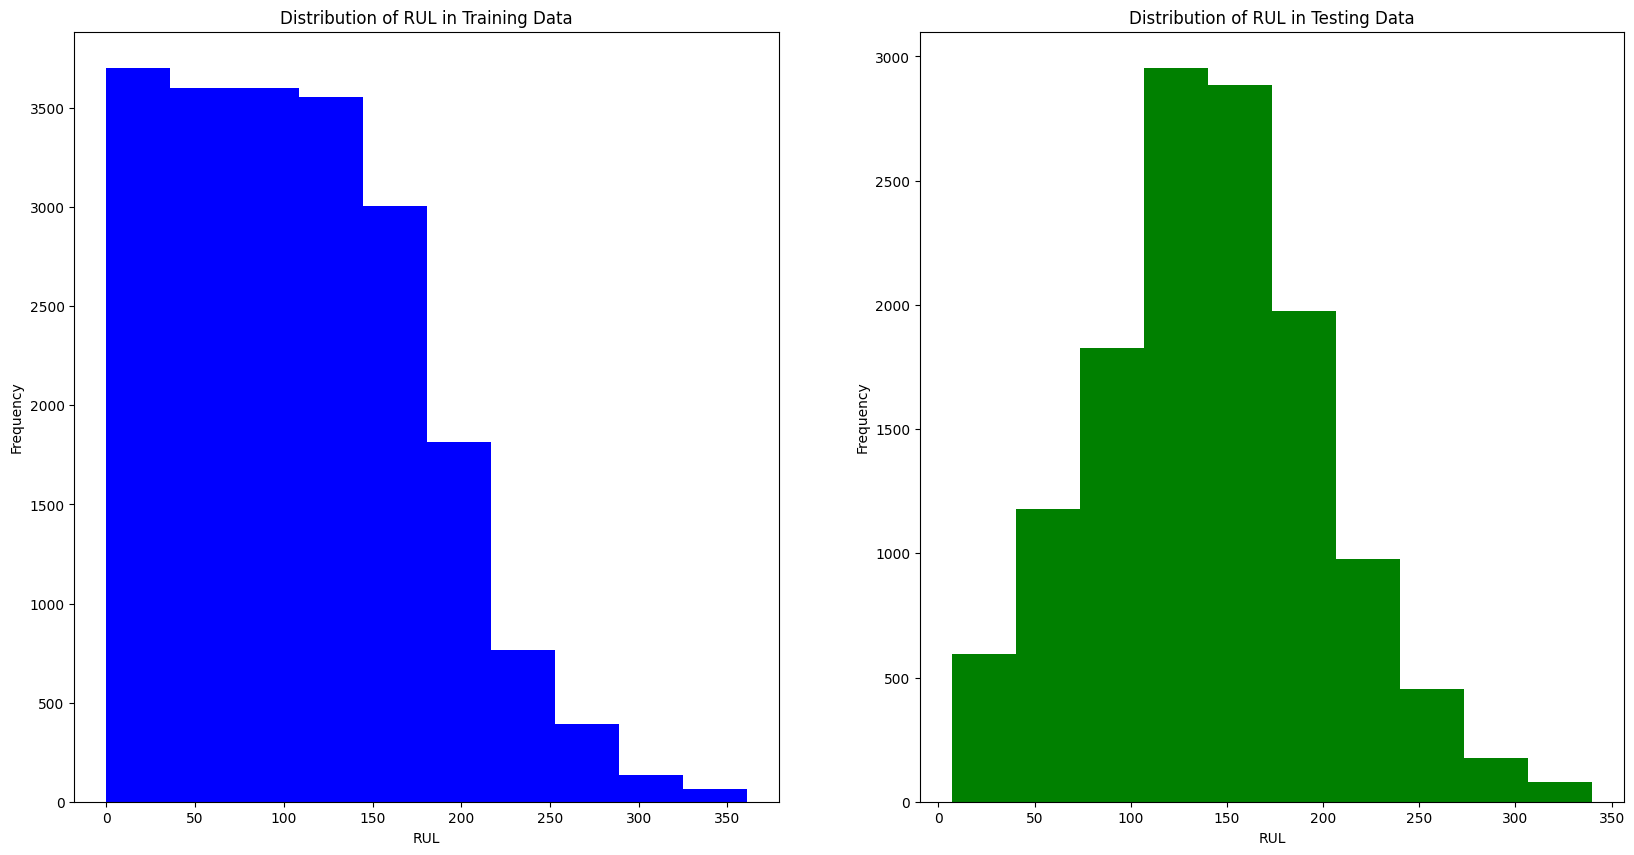

In [20]:
#visualising the distribution of remaining useful life(training and testing dataset)

plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.hist(train_dataset["RUL"], color = "blue")
plt.title("Distribution of RUL in Training Data")
plt.xlabel("RUL")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(testing_dataset["RUL"], color = "green")
plt.title("Distribution of RUL in Testing Data")
plt.xlabel("RUL")
plt.ylabel("Frequency")
#plt.savefig("RUL_histograms")
plt.show()

From the plot, it is evident that RUL values in the training dataset are uniformly distributed, with most RUL concentrated on low values. This is because the all the engines (Unit_ID) in the training dataset present RUL values until failure(RUL = 0). 

Whereas, in testing dataset, the engine(Unit_ID) has high average RUL value. This is because the test dataset doesn't contain RUL values until failure.

The training datset has comprehensive range of RUL values from healthy to failure, so therefore this should allow a model to predict any RUL value. However, the model sees more engines nearing failure, and might become more tuned to predict lower RUL values. If the testing dataset has higher RUL values, the bias towards lower RUL values might lead to prediction errors in the model.

**Analysing and visualising independent variables with limited variability**

In [21]:
unique_variables = pd.concat([train_dataset.nunique(), test_dataset.nunique()], axis =1)
unique_variables.columns = ["Training Dataset", "Testing Dataset"]
print(unique_variables)

                Training Dataset  Testing Dataset
Unit_ID                      100              100
Time_in_Cycles               362              303
Setting_1                    158              150
Setting_2                     13               14
Setting_3                      1                1
T2                             1                1
T24                          310              262
T30                         3012             2361
T50                         4051             2954
P2                             1                1
P15                            2                2
P30                          513              415
Nf                            53               41
Nc                          6403             4047
epr                            1                1
Ps30                         159              136
phi                          427              357
NRf                           56               43
NRc                         6078             3786


Features such as Setting_3, T2, P2, epr, farB, Nf_dmd, and PCRfR_dmd are consistent as they all have a single unique value. These features along with other sensors can be visualised through boxplots to create a summary of variablity and potential outliers in data.

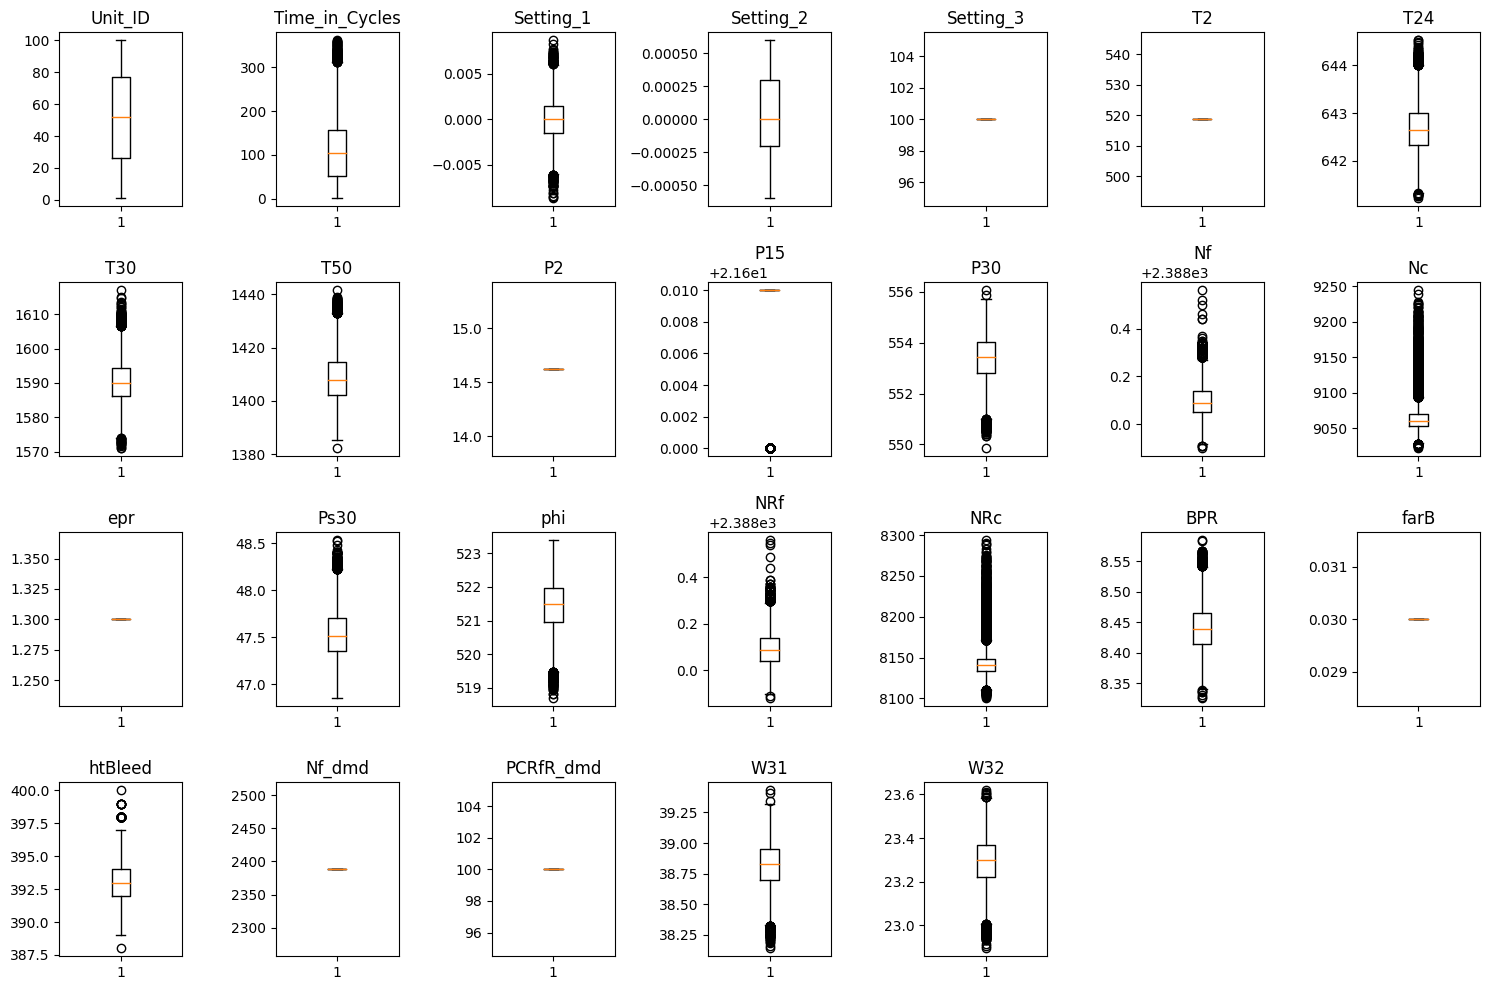

In [22]:
#creating boxplots to show variablity of independent variables

features = train_dataset.columns[0:26]
plt.figure(figsize =(15, 10))

for i, feature in enumerate(features):
    plt.subplot(4, 7, i+1)
    plt.boxplot(train_dataset[feature])
    plt.title(f"{feature}")

plt.tight_layout()
#plt.savefig("independent_variable_boxplot")
plt.show()

Unit_ID - The plot shows an even distribution, showing the 100 engines in the dataset.

Time_in_Cycles - The plot shows that most engines with low number of cycles are evenly distributed, but some engines(outliners) have gone through a high number of cycles.

Setting_1 and Setting_2 - Most of the data lie around the mean. While reviewing the outliers, we can see the variations are minimal, and therefore this can suggest that these are constant values (operating conditions of flight).

Sensor Readings(T24, T30, T50, P30, Nf, Nc, PS30, phi, NRf, NRc, BPR, htBleed, W31, W32) - The box plot shows variation in the values. There are significant outliners, and each sensor has its own different mean and spread of data.

RUL - This is exactly similar to the "Time_in_Cycles" since we built the RUL based on the cycle time. The boxplot shows some engines are nearing failure, and others (outliers) have significant life time left(high RUL).

Sensor Readings (Setting 3, T2, P2, epr, farB, and PCRfR_dmd) - The boxplot clearly shows these sensor values have no variablity and have constant values. They do not provide any feature importance for building predictive models.

P15 - The boxplot shows the presence of only two values. These values are very close to each other (0.000 - 0.010) with no variability. This might suggest that this is a constant operating condition. 

Checking the sensor value P15, since it has only two unique values. 

In [23]:
train_dataset["P15"].unique()

array([21.61, 21.6 ])

In [24]:
train_dataset["P15"].value_counts()

P15
21.61    20225
21.60      406
Name: count, dtype: int64

**Significance of P15 sensor reading in turbofan engines**

P15 (Total pressure in bypass-duct):- measured in pound per square inch (psia)

In a turbofan engine, incoming air is divided into the primary stream and the bypass stream. 

The main flow of air will be through the primary stream, where it will be compressed, mixed with fuel, ignited and propelled. The remaining air bypasses the engine core, and is directly propelled to provide additional thrust.

P15 sensor measures the total pressure of air in the by-pass duct (static + dynamic pressure). Therefore this pressure value is very important as it is relates to the perfect vaccum in the engine. 

The data values 21.61 and 21.60 from P15 sensor might seem like a round off error, but these slight variations can have significant impact in aircraft engine performance.  

From a statistical perspective, P15 would not add much variablity to a predictive model, and the two values are very similar. Therefore, we will not be considering the P15 sensor data in the predictive models. But being a significant and critical parameter, we will be using this sensor readings in the monitoring and alert system. In this system, the sensor value will be monitored to detect anomalies and to prevent defects.

**Optimising predictive model performance by removing non-variable features**

Features such as Setting_3, T2, P2, epr, farB, Nf_dmd, and PCRfR_dmd are consistent as they have a single unique value. These features with singular values can be dropped as they have no variability, and do not contribute to model prediction. Removing these features along with P15 (no variability) from the model can make it more efficient and reduce the dimensionality of the data, making the model train faster and perform better.

In [25]:
pred_train_dataset = train_dataset.drop(columns = ["Setting_3", "T2", "P2", "epr", "farB", "Nf_dmd", "P15", "PCRfR_dmd"])
pred_test_dataset = test_dataset.drop(columns = ["Setting_3", "T2", "P2", "epr", "farB", "Nf_dmd", "P15", "PCRfR_dmd"])

In [26]:
#saving the dataset
pred_train_dataset.to_csv("pred_train_dataset.csv", index = False)
pred_test_dataset.to_csv("pred_test_dataset.csv", index = False)

In [27]:
#comparing both the datasets after dropping the non-variablity features
dataset_comparison = pd.concat([pred_train_dataset.nunique(), pred_test_dataset.nunique()], axis=1)
dataset_comparison.columns = ["Training_Dataset", "Testing_Dataset"]
print(dataset_comparison)

                Training_Dataset  Testing_Dataset
Unit_ID                      100              100
Time_in_Cycles               362              303
Setting_1                    158              150
Setting_2                     13               14
T24                          310              262
T30                         3012             2361
T50                         4051             2954
P30                          513              415
Nf                            53               41
Nc                          6403             4047
Ps30                         159              136
phi                          427              357
NRf                           56               43
NRc                         6078             3786
BPR                         1918             1506
htBleed                       13                9
W31                          120              103
W32                         4745             3555
RUL                          362              334


# Monitoring and Alert System:

For safety, the features such as Setting_3, T2, P2, P15, epr, farB, Nf_dmd, and PCRfR_dmd are very important. Even if these variables show no variablity, it does not mean that there is not be variation in the real-world sensor data. If there is a small deviation in these values, it could lead to serious safety concerns. Keeping track of these features is very important, and for this reason, we will be implementing a monitoring and alert system. The system detects the changes in values from the constant, and trigger an alert indicating potential anomalies or defects.

By building the monitoring and alert system in parallel with the predictive maintenance, we could improve the model predictive power making it more efficient and accurate, and the constant values like Setting_3, T2, P2, epr, farB, Nf_dmd, P15, and PCRfR_dmd will be closely monitored.

In [28]:
critical_sensors = {
    "Setting_3": 100.0,
    "T2": 518.67,
    "P2": 14.62,
    "epr": 1.3,
    "farB": 0.03,
    "Nf_dmd": 2388,
    "PCRfR_dmd": 100.0,
    "P15": (21.60, 21.61)
}

Reducing the false negative is our priority, and therefore the sensor values should be constant. The sensor values are added manually, instead of using the first row of the datset. If an error arises in the first row, this would lead to huge safety risk. 

In [29]:
#creating the monitoring and alert system
def monitoring_and_alert_system(dataset):
    required_features = dataset[["Unit_ID"] + list(critical_sensors.keys())] #extract only the columns of critical sensors
    for index, row in required_features.iterrows(): #iterate through each row of required features
        engine = int(row["Unit_ID"]) #extracting the engine number
        
        for key, expected_value in critical_sensors.items(): #iterating through key-value pair(sensor, expected_value) in dictionary(critical_sensor)
            actual_value = row[key] #value from current row
    
            if key == "P15": #checking P15 sensor data
                if not expected_value[0] <= actual_value <= expected_value[1]: #if sensor value is outside the range
                    print(f"ALERT!!! Deviation detected in Engine {engine} for sensor {key}. The sensor returned {actual_value}. The value should lie between {expected_value[0]} and {expected_value[1]}.")
                
            elif actual_value != expected_value: #if sensor value is different from expected(all sensors)
                print(f"ALERT!!!! Deviation detected in Engine {engine} for sensor {key}. The sensor returned {actual_value}. The expected value should be {expected_value}.")

We only want to iterate through the specified critical_sensor columns (Setting_3, T2, P2, epr, farB, Nf_dmd, P15, and PCRfR_dmd) rather than the entire dataset. This could reduce the computational overhead of iterating through all the dataset columns.

In [30]:
monitoring_and_alert_system(train_dataset)

#there is no deviation in the critical sensors (because critical sensor values in our dataset are constant)

In [31]:
#checking the monitoring_and_alert system by creating a new dataset (adding descrepencies in the new dataset) 
check_dataset = train_dataset.copy(300)

check_dataset.at[2, "P15"] = 21.62
check_dataset.at[347, "P2"] = 11.55
check_dataset.at[675, "T2"] = 520

In [32]:
#Testing the newly created dataset with variations in critical sensors
monitoring_and_alert_system(check_dataset)

ALERT!!! Deviation detected in Engine 1 for sensor P15. The sensor returned 21.62. The value should lie between 21.6 and 21.61.
ALERT!!!! Deviation detected in Engine 2 for sensor P2. The sensor returned 11.55. The expected value should be 14.62.
ALERT!!!! Deviation detected in Engine 4 for sensor T2. The sensor returned 520.0. The expected value should be 518.67.


# Predictive Maintenance

We will be exploring various models to find the best fit for our datset. The initial focus will be on Linear Regression, ensuring we adhere to key assumptions. It serves as an initial modeling exercise and a diagnostic tool for data analysis. This will also help us to understand our data better. The model accuracy will be evaluated, and based on the evaluation, we can iteratively refine our model and build an effecive predictive model.

**1. LINEAR REGRESSION MODEL**

It is a statistical method used to analyse the relationship between the target variable, and one or more independent variable.

In this analysis, we will be checking the five key assumptions supporting linear regression such as linearity, multivariate normality, multicollinearity, autocorrelation, and homoscedasticity (Analytics Vidhya, 2016). By adhering to the above principles, we aim to check the suitability of linear regression for our dataset. 

It allows us to explore different modelling approaches and highlights the importance of data exploration to ensure accurate predictive results.

**Exploring linear relationship between target variable and independent variables**

A linear relationship between two variable means if one variable changes, there other variable should change in the same corresponding way.

This is represented as y = mx +c

y - target variable
x - independent variable
m - slope
c - intercept

If there is no relationship between the target variable and independent variables, using linear regression would lead to poor predictive accuracy (it doesn't capture true relationship between variables).

The relationship between independent variables and target variable should be linear. We can visualise this by plotting the target variable "RUL" with all the other independent variables using scatter plots.

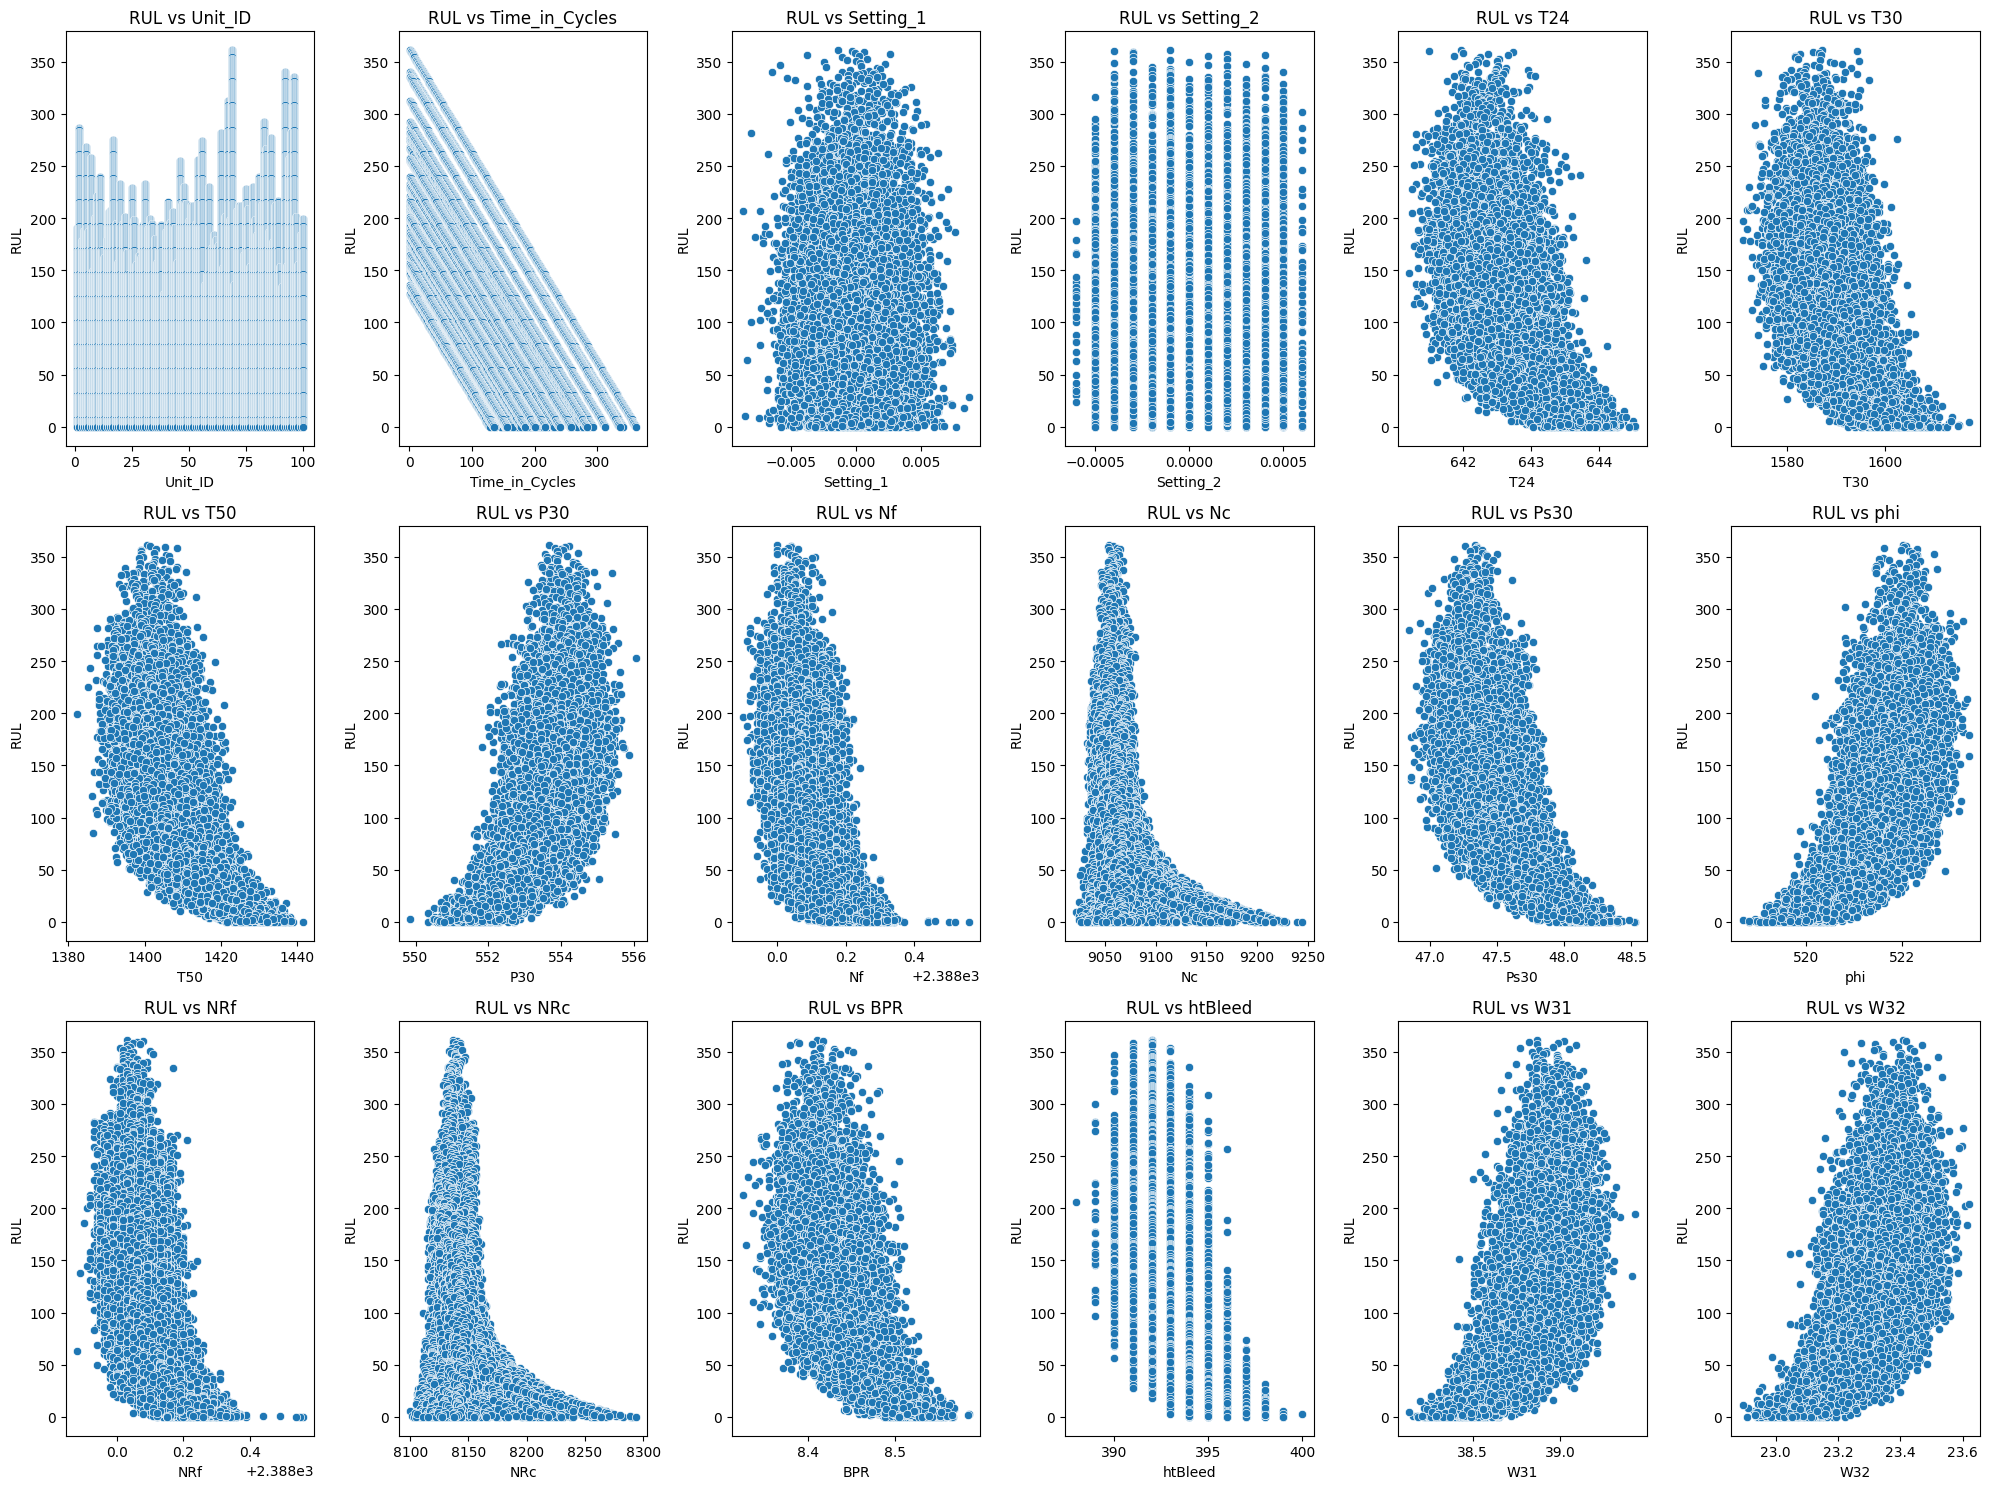

In [33]:
#scatter plots for RUL vs independent variables

features = pred_train_dataset.columns[0:18]

plt.figure(figsize = (20, 15))

for i in range(len(features)):
    plt.subplot(3, 6, i+1)
    sns.scatterplot(x = pred_train_dataset[features[i]], y = pred_train_dataset["RUL"])
    plt.title(f"RUL vs {features[i]}")
    plt.xlabel(features[i])
    plt.ylabel("RUL")

plt.tight_layout()
#plt.savefig("RUL_vs_independent_variables")
plt.show()

While investigating the distributions of variables and the relationships between RUL and indepenedent variables, we could find that most of the variables do not display a clear linear relationship with the target "RUL". Some data points are dispersed across x-axis making it difficult to find the linear trend.

Time_in_Cycles indicates a clear negative linear relationship with RUL.
Unit_ID has no clear trend.
Setting_1, Setting_2 have readings that are clustered, and constant(specific operating condition).
Nc and NRc displays no clear linear relationship with RUL.
P30, phi, W31 and W32 indicates a potential positive linear relationship
htBleed exhibits some variablity and indicates potential negative linear relationship, indicating specific operating conditions(relatively constant)
Features like T24, T50, Ps30, and BPR show potential negative linear relationships with RUL.

The increase and decrese in sensor values indicate the degradation of the engine over time. The variability in scatter plot indicates that linear regression cannot capture all the trends and relationships in the data.

**Computing correlation coeeficient of independent variables with target variable:**

Heatmap can also help in finding the strength and direction of linear relationships. 

value close to 1 -> strong Positive linear relationship

value close to -1 -> strong negative linear relationship

value close to 0 -> weak linear relationship

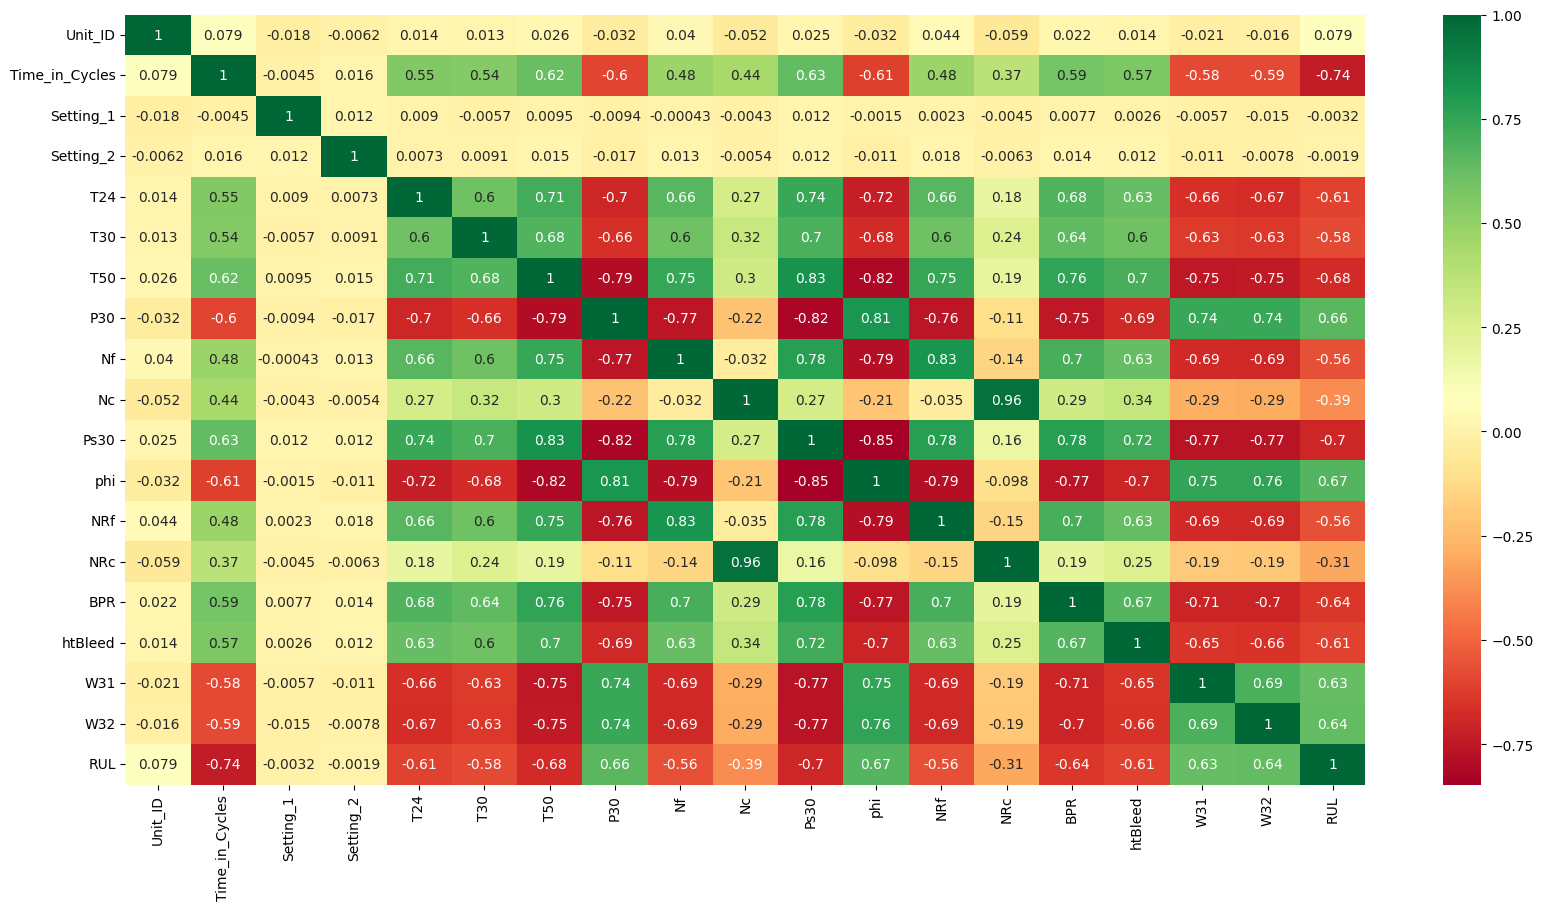

In [34]:
#visualising correlation with help of heatmap

plt.figure(figsize = (20,10))
sns.heatmap(pred_train_dataset.corr(), cmap = "RdYlGn", annot = True) #(.corr() - computes pairwise correlation(pearson correlation)
#plt.savefig("correlation_heatmap")
plt.show()

Independent variables like P30, phi, W31, and W32 have a strong positive linear relationship with the target variable RUL.
Independent variables like Time_in_Cycles, Ps30, T50, and BPR have a strong negative linear relationship with RUL.
Setting_1 and Setting_2 have a correlation coefficient close to zero, and may not have a significant linear relationship with RUL.

**Checking the dataset is normally distributed (multi-variate normality)**

The difference between observed and predicted values is called residuals(errors). Multivariate normality assumes the residuals(errors) are normally distributed(overall pattern of error should follow normal distribution).

When this assumption is violated, it affects the efficiency of regression coefficient estimates. It reduces the statistical power of hypothesis tests associated with those coefficients. If the residuals(errors) is not nomally distributed, the prediction might not be optimal (Analytics Vidhya, 2016).

The dataset will be fitted using linear regression model to compute the residuals. It will be visualised using Q-Q plots to assess the disparity between residual distribution and theoretical normal distribution

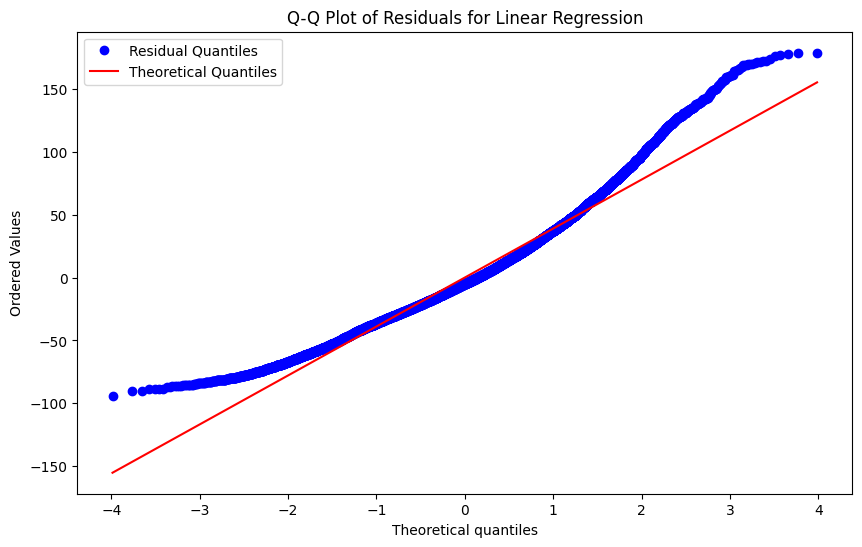

In [152]:
#evaluating the normality of residuals using Q-Q plot(Linear Regression)

X = pred_train_dataset.iloc[:, :-1]
y = pred_train_dataset["RUL"]

# Fitting the linear regression model
linreg = LinearRegression()
linreg.fit(X, y)

# Computing the residuals
predicted_y = linreg.predict(X)
residuals = y - predicted_y

# Plotting the Q-Q plot for residuals
plt.figure(figsize = (10, 6))
probplot(residuals, plot = plt)
plt.title("Q-Q Plot of Residuals for Linear Regression")
plt.legend(["Residual Quantiles", "Theoretical Quantiles"], loc = "upper left")
#plt.savefig("residuals_linear_regression")
plt.show()

#reference: (Malato, 2021)

Here, we compare two distributions (residual of model vs theoretical normal distribution). The blue dots represent the residuals from the linear regression model, and the red line represents quantile of normal distribution.

From the plot, it is evident that most data points follow along the reference line. But it is also visible that the residuals from the linear regression model deviate at the tail and head sections. This shows that the data is slightly not normally distributed, and the model cannot capture all the patterns in the data.

Evaluating the residuals of a polynomial regression model to check for their normality using a Q-Q plot:

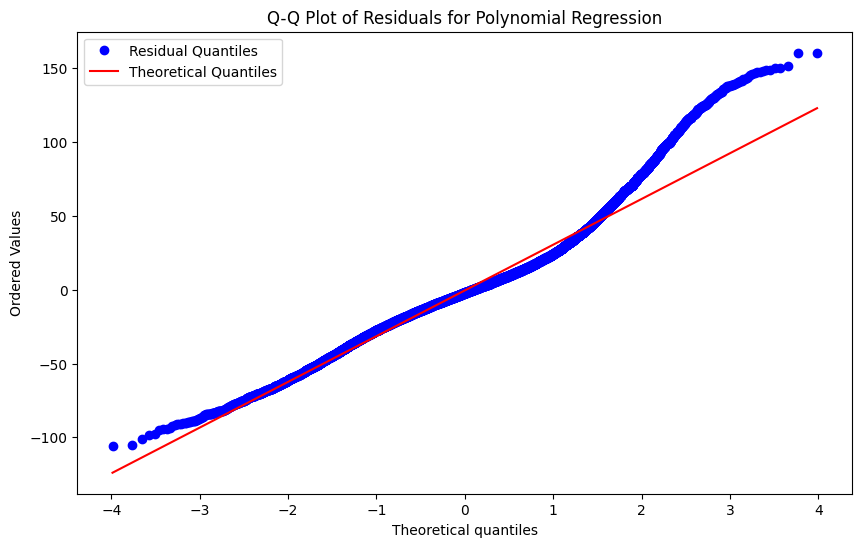

In [151]:
#evaluating the normality of residuals using Q-Q plot(Polynomial Regression)

X = pred_train_dataset.iloc[:, :-1]
y = pred_train_dataset["RUL"]

# Transforming the features to polynomial features
poly = PolynomialFeatures(degree = 4)
X_poly = poly.fit_transform(X)

# Fitting the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Computing the residuals
predicted_y_poly = poly_model.predict(X_poly)
residuals_poly = y - predicted_y_poly

plt.figure(figsize = (10, 6))
probplot(residuals_poly, plot = plt)
plt.title("Q-Q Plot of Residuals for Polynomial Regression")
plt.legend(["Residual Quantiles", "Theoretical Quantiles"], loc = "upper left")
#plt.savefig("residuals_polynomial_regression")
plt.show()

#reference: (Sotiriadis, 2022)

The independent variables are transformed to polynomial features for the regression model. Similar to the linear regression model, most points in Q-Q line do closely follow the diagonal line. They are more normally distributed than in the linear regression model, particularly at center and tail, but at the head section, we can see a large deviation from the diagonal line. This indicates there is a potential non-normality in the residuals, and the polynomial regression model cannot capture all the patterns in the data. We cannot increase the degree as it leads to computational overhead.

If the residuals are not normal, the regression model won't work as efficiently or reliably. It is better to explore other models.

**Checking multicollinearity**

Multicollinearity measures the correlation of two independent variables (if independent variables are highlt correlated, one independent variable can be predicted from the other variable). It will be very difficult to distiguish the individual effects on target variable.

High multicollinearity can lead to overfitting, and leads to poor performance on unseen data (Jha, 2021). The model will assign a high coefficient to one of the variables and a correspondingly low coefficient to another, even though they carry similar information. This reduces the interpretability of the model. Therefore, small changes in the data can result in large changes in the model coefficients. 

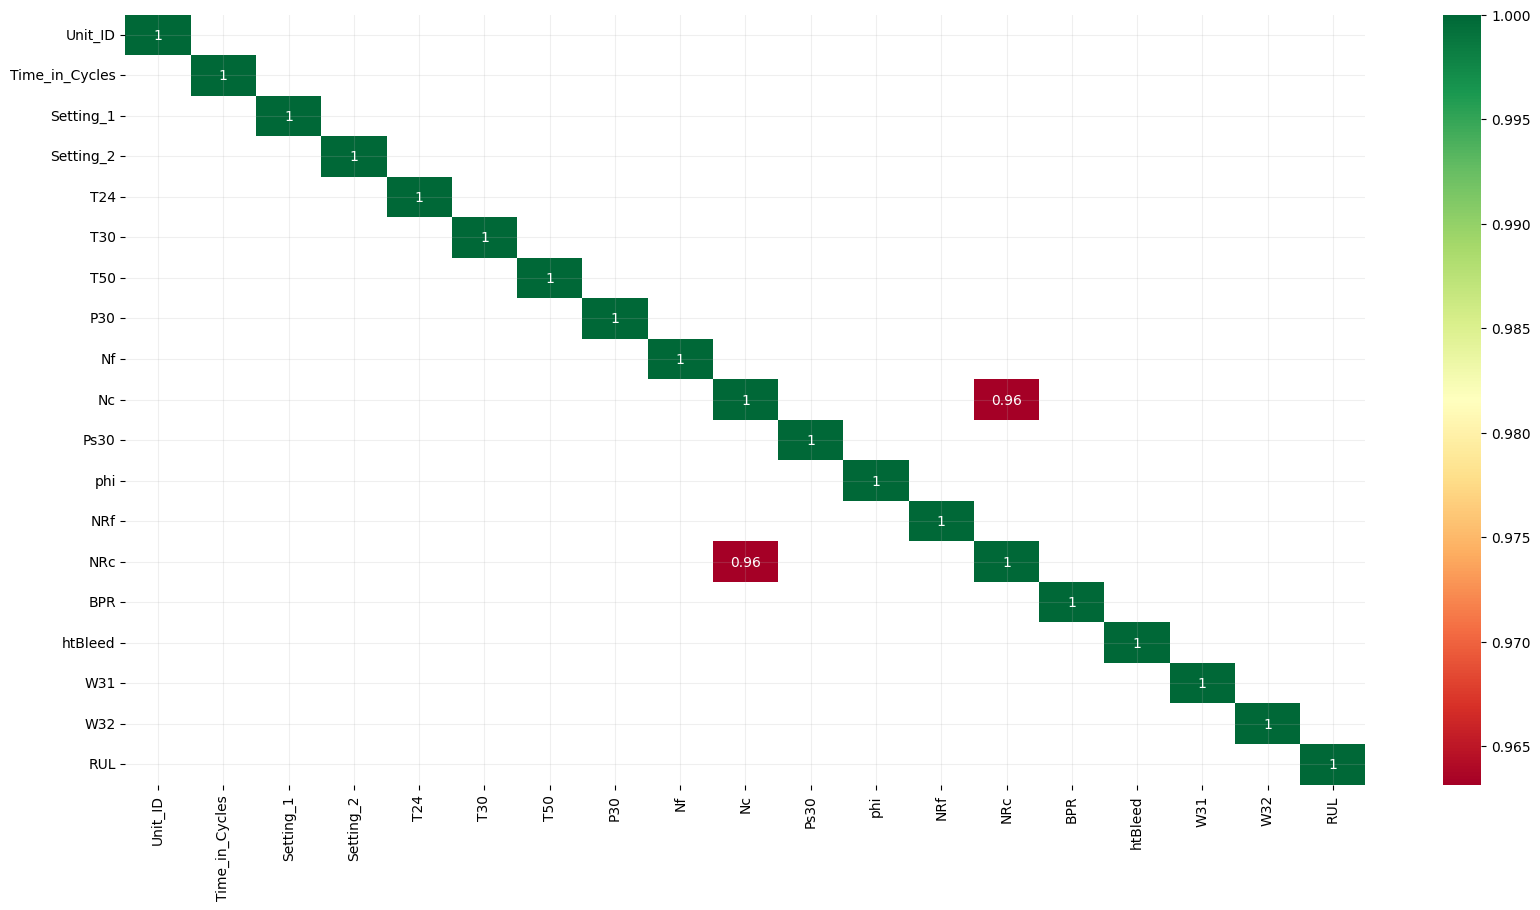

In [37]:
#visualising the high correlation between independent variables

max_threshold = 0.85 #setting the threshold to 0.85, anything above the threshold value indicates that the respective variable are highly correlated to each other 
correlation_matrix = pred_train_dataset.corr()
threshold_filter = abs(correlation_matrix) <= max_threshold

# setting the values below the threshold(0.85) to NaN
correlation_matrix[threshold_filter] = None

# Plot the heatmap
plt.figure(figsize = (20, 10))
sns.heatmap(correlation_matrix, cmap = "RdYlGn", annot = True)
plt.grid(True, alpha = 0.2)
#plt.savefig("correlation_independent_variables")
plt.show()

Here, we can see both Nc and NRc are highly correlated. This could make it challenging to interpret the individual effects of each predictor in the model, and it increases the standard errors of the regression coefficients, affecting the reliability of the model.

Nc -(Physical core speed (rpm)) is the rotational speed of the engine core, and is directly related to the engine's thrust and fuel efficiency.
NRc - (Corrected core speed (rpm)) is the physical core speed(Nc) adjusted to the atmospherice condition. 
An engine operates in different environmental conditions and altitudes. These NRc values are corrected to a standard reference condition to make engine performance comparable across different conditions.

Although high correlation between independent variables (Nc and NRc) can lead to multicollinearity, dropping either "Nc" or "NRC" is not recommended, as all the sensor values are very critical. Further analysing the dataset is needed.

Here, multiple copies of predictive training dataset are created, and then each of the columns "NRc" and "Nc" are dropped to evaluate the performance of the model. This will help us to understand the feature importance, and determines whether dropping either one of the features will have a significant impact on model performance.

In [38]:
#Creating multiple copies of the dataset
check_1 = pred_train_dataset.copy()  #predictive maintenance training dataset
check_2 = pred_train_dataset.copy()

#Dropping "NRc" and "Nc" column in the below training datasets
check_1.drop(columns = "NRc", inplace = True)  #predictive maintenance training dataset(dropping "NRc")
check_2.drop(columns = "Nc", inplace = True)  #predictive maintenance training dataset(dropping "Nc")

check_test1 = pred_test_dataset.copy()  #predictive maintenance testing dataset
check_test2 = pred_test_dataset.copy()

#Dropping "NRc" and "Nc" column in the below testing datasets
check_test1.drop(columns = "NRc", inplace = True)  #predictive maintenance testing dataset(dropping "NRc")
check_test2.drop(columns = "Nc", inplace = True)  #predictive maintenance testing dataset(dropping "Nc")

Rather than evaluating the performance with the test dataset, we will split the training dataset onto two parts, and then evaluate both the models performance. 

In [150]:
#comparing the performance of linear regression model after dropping correlated columns

def compare_linreg(dataset):
    X = dataset.iloc[:, :-1] #independent variables
    y = dataset["RUL"] #target variable

    #splitting the training dataset (50% train and 50% test using train_test_split function)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42) 
    
    model = LinearRegression().fit(X_train, y_train) #train the model with training dataset
    predictions = model.predict(X_test) #predicting the RUL for testing dataset
    
    #computing the rmse between actual value (y_test) with predicted value
    return mean_squared_error(y_test, predictions, squared =False) #(if squared = False, root mean squared error) 

#Computing Root Mean Square Error for all the three dataset
rmse_1 = compare_linreg(pred_train_dataset)
rmse_2 = compare_linreg(check_1)
rmse_3 = compare_linreg(check_2)

print(f"Root Mean Square Error(without dropping any columns): {rmse_1}")
print(f"Root Mean Square Error(after dropping 'NRc'): {rmse_2}")
print(f"Root Mean Square Error(after dropping 'Nc'): {rmse_3}")

#reference: (Scikit-Learn Developers, 2023a)

Root Mean Square Error(without dropping any columns): 39.24966451175395
Root Mean Square Error(after dropping 'NRc'): 39.25036972211361
Root Mean Square Error(after dropping 'Nc'): 39.24388580799723


Though "NRc" and "Nc" are highly correlated, the RMSE value for all the datasets (dropped or retained) are very close to each other. This suggests that removal of either one of the coloumns does not significantly impact the predictive capablity. In addition, our focus is to predict the RUL without dropping any sensor values. It is noted that both "Nc"(physical core speed) and "NRc"(corrected core speed) might seem like they represent the same measurement(engine rotation speed), but they serve different purposes. Nc indicates the actual rotation speed in an engine, while NRc provides the value of engine speed for prevailing atmospheric conditions (an important factor for aircraft operating in diverse conditions).

The presence of multicollinearity can be further analysed by Variance Inflation Factor. It is calculated by regressing the variable with all the other independent variables. 

In [149]:
#Variance Inflation Factor (VIF)

X = pred_train_dataset.iloc[:, :-1] #independent variables
features = pred_train_dataset.columns[:-1] # column name of independent variables

#calculating VIF by iterating through each feature
vif_values = [variance_inflation_factor(X, i) for i in range(len(features))]

vif = pd.DataFrame({"features": features, "VIF": vif_values})
print(vif)

#reference: (Cosine1509, 2020)
#reference: (Jha, 2021)

          features           VIF
0          Unit_ID  4.181226e+00
1   Time_in_Cycles  7.431208e+00
2        Setting_1  1.001734e+00
3        Setting_2  1.001083e+00
4              T24  4.328936e+06
5              T30  1.533309e+05
6              T50  1.098124e+05
7              P30  1.637349e+06
8               Nf  3.216571e+09
9               Nc  3.011502e+06
10            Ps30  1.837602e+05
11             phi  2.542776e+06
12             NRf  3.214105e+09
13             NRc  3.062501e+06
14             BPR  1.648274e+05
15         htBleed  1.636964e+05
16             W31  1.397822e+05
17             W32  1.420847e+05


Setting_1 and Setting_2 have Variance Inflation Factor values that are approximately 1, therefore there is little or no multicollinearity.
Unit_ID and Time_in_Cycles have moderate multicollinearity.
All the other sensors indicate very high degrees of multicollinearity since their values are greater than 10 (Analytics Vidhya, 2016). 

Linear regression model may not be the best fit for the data.

**Checking auto-correlation**

Autocorrelation (lagged correlation or serial correlation) measures the relationship between a variable's current value over time. It represents the similarity between given time series data and its own delayed version over successive time intervals (Smith, 2023).

If the residuals are auto-correlated, then it means that the model has missed some information which is leading to patterns in the residuals.

We are plotting the residual over time("Time_in_Cycles" represents the order of observations, making it as the obvious choice).

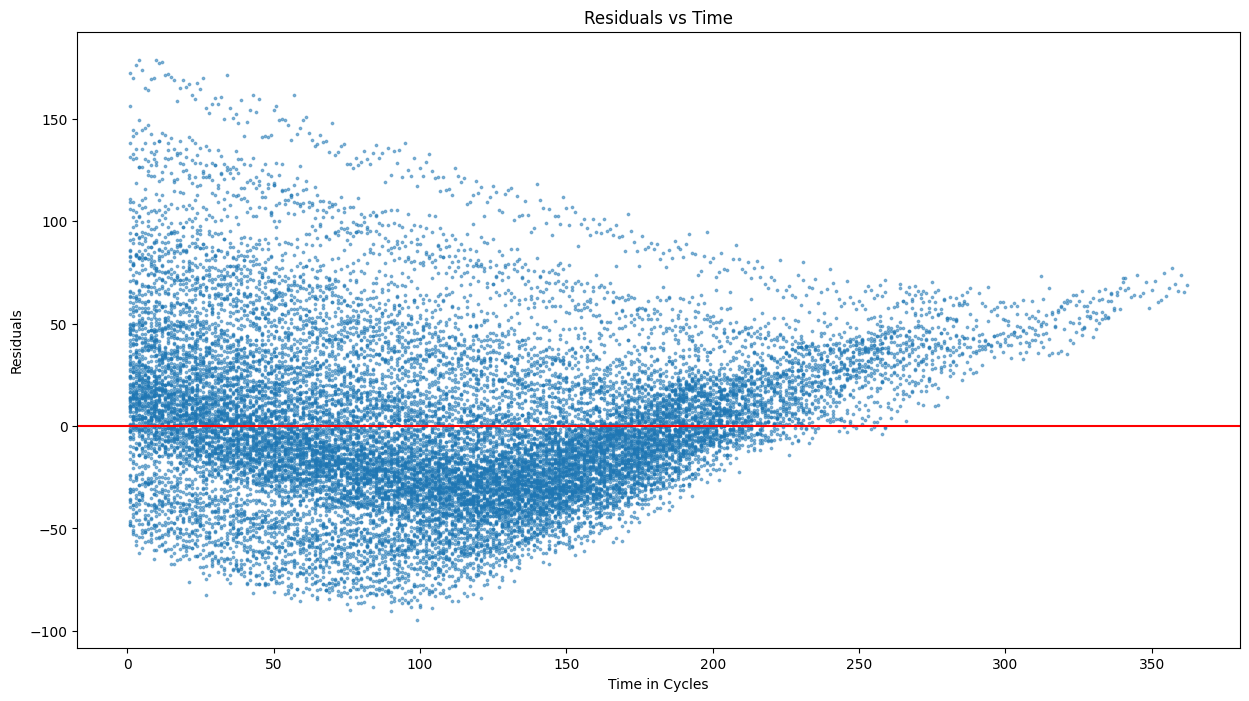

In [41]:
#checking autocorrelation through analysis of residuals over time

X = pred_train_dataset.iloc[:, :-1] #independent variables
y = pred_train_dataset["RUL"] #target variable

#creating a linear regression model and fitting it to the data 
model = LinearRegression().fit(X, y)

#predicting the target variable RUL by using the trained model and computing residuals(actual - predicted)
predicted_y = model.predict(X)
residuals = y - predicted_y

#plotting the residuals against time(Time_in_Cycles)
plt.figure(figsize = (15, 8))
plt.scatter(pred_train_dataset["Time_in_Cycles"], residuals, s = 3, alpha = 0.5)
plt.axhline(y = 0, color = "red")
plt.xlabel("Time in Cycles")
plt.ylabel("Residuals")
plt.title("Residuals vs Time")
#plt.savefig("residuals_time_scatterplot")
plt.show()

As per the plot, there seems to be a subtle pattern found in residual over time but this is not very clear. The datapoints are scattered and randomnly distributed, but they do not exhibit upward or downward cyclic pattern. Since we couldn't clearly conclude with visualisation, we will have to use a statistical method, such as the Durbin-Watson test, to detect autocorrelation.

In [162]:
#Durbin-Watson test to detect the autocorrelation.

from statsmodels.stats.stattools import durbin_watson

X = pred_train_dataset.iloc[:, :-1] #independent variables
y = pred_train_dataset["RUL"] #target variable

#creating a linear regression model and fitting it to the data 
model = LinearRegression().fit(X, y)

#predicting the target variable RUL by using the trained model and computing residuals
predicted_y = model.predict(X)
residuals = y - predicted_y #(actual - predicted)

#computing the Durbin-Watson statistic
autocorrelation = durbin_watson(residuals)
print(f"Autocorrelation: {autocorrelation}")

#reference: (Jitender, 2020)

Autocorrelation: 0.04651408908268717


The result (0.0465) suggests there is a positive autocorrelation in the residuals (0 < 2), indicating that our model errors (residuals) have sequential patterns. This suggests that the linear regression model might not be adequately capturing all the sequential information present in the data. 

**Checking homoscedasticity**

Homoscedasticity means that the variance of residuals (errors) from the model should be constant regardless of the values of the independent variables. This means the spread of the residuals should be constant across all the range of predicted values.

If the variance differs across the levels of independent variable, this exhibits heteroscedasticity. This would impact regression and analysis of variance as it invalidates statistical significance tests that rely on consistent error variances (Analytics Vidhya, 2016).

We can plot residuals against the predicted values to visualise homoscedasticity.

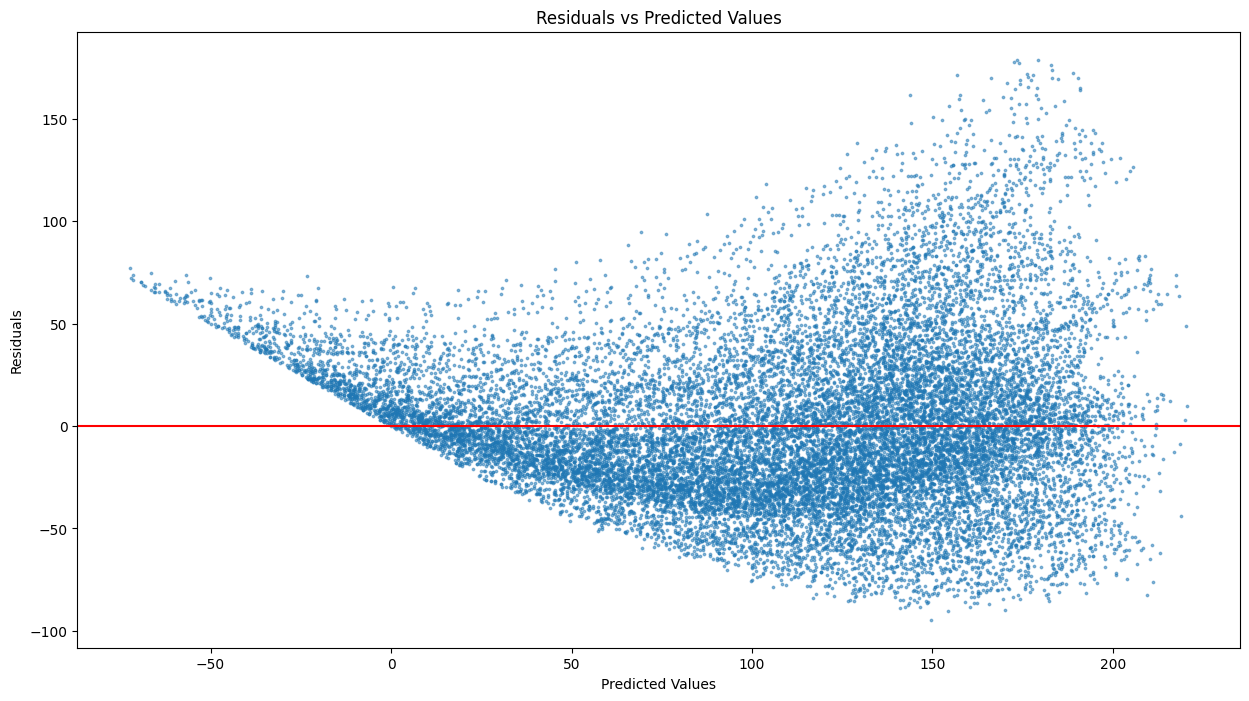

In [43]:
#checking homoscedasticity by analysing the residuals vs predicted values

X = pred_train_dataset.iloc[:, :-1] #independent variables
y = pred_train_dataset["RUL"] #target variable

#creating a linear regression model and fitting it to the data 
model = LinearRegression().fit(X, y)

#predicting the target variable RUL by using the trained model and computing residuals
predicted_y = model.predict(X)
residuals = y - predicted_y #(actual - predicted)

plt.figure(figsize = (15, 8))
plt.scatter(predicted_y, residuals, s = 3, alpha = 0.5)
plt.xlabel("Predicted Values")
plt.axhline(y = 0, color = "red")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
#plt.savefig("residuals_predicted_scatterplot")
plt.show()

The above plot displays heteroscedasticity. This uneven variance can lead to biased and skewed test results (Analytics Vidhya, 2016). To conclude the heteroscedasticity statistically, we are using the statistical method Bruesch-Pagan test.

In [44]:
#Breusch-Pagan test for heteroscedasticity in residuals

X = pred_train_dataset.iloc[:, :-1] #independent variables
y = pred_train_dataset["RUL"] #target variable

#creating a linear regression model and fitting it to the data 
model = LinearRegression().fit(X, y)

#predicting the target variable RUL by using the trained model and computing residuals(actual - predicted)
predicted_y = model.predict(X)
residuals = y - predicted_y 

labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]

#conducting the Breusch-Pagan test using residuals and design matrix (exogenous variables)
results = sms.het_breuschpagan(residuals, add_constant(X))

for label, value in zip(labels, results):
    print(f"{label}: {value}")

# Reference: (Bhuwanesh, 2022)

Lagrange multiplier statistic: 2088.363509717409
p-value: 0.0
f-value: 128.96808176494415
f p-value: 0.0


The p-value (0.0 < 0.05) indicates the presence of heteroscedasticity (rejection of null hypothesis of homoscedasticity) in the residuals. The variance of residuals are not constant across all levels of indepenedent variables, and affects the reliablity and validity of regression coeffcient estimates.

**Plotting predicted vs actual RUL values**

Before moving into evaluation of linear regression model, we are creating a new function called "plot_predicted_vs_actual". This function visualise the comparison between the actual RUL values from the testing dataset and the RUL values predicted from the model. Since the size of our dataset is large, visualising all the RUL values will result in a clutterd and non-readable format. To make the visualisation more consice, we are sampling every nth value from both actual RUL and predicted RUL. After sampling, we are setting the visualisation scope to only first 50 values. 

In [45]:
#plotting predicted RMSE with the actual RMSE values from truth table

def plot_predicted_vs_actual(y_test, testing_predictions):
    
    #sampling every 50th values for visualisation(since our dataset is large)
    actual_rul_values = y_test.values[::50]
    predicted_rul_values = testing_predictions[::50]

    #keeping only first 50 values from the previous sampled for visualisation
    actual_rul_values = actual_rul_values[:50]
    predicted_rul_values = predicted_rul_values[:50]

    #defining the position and width of bars
    x = np.arange(50)
    y = 0.5

    plt.figure(figsize=(20, 10))
    
    plt.bar(x, actual_rul_values, width = y, color = "blue", label = "Actual RUL")
    plt.bar(x+y, predicted_rul_values, width = y, color = "red", alpha = 0.7, label = "Predicted RUL") #adding with width to avoid overlapping
    plt.xlabel("Sampled Index")
    plt.ylabel("RUL")
    plt.title("Actual vs Predicted RUL Values")
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

**Evaluation metrics**

Root Mean Squared Error(RMSE) will be the primary evaluation metric. Although there are more metrics available for regression analysis, such as Mean Absolute Error(MAE), R-Squared, Mean Absolute Percentage Error(MAPE), and Mean Squared Error(MSE), we have choosen RMSE for this analysis as it gives more importance (weight) to larger errors than small errors. RMSE is sensitive to outliers and penalises large errors more heavily than other evaluation metrics.

Furthermore, the "plot_predicted_vs_actual" bar plot will be used in all the machine learning models, and serve as the second evaluation metric, in order to visualise model performance.

**Evaluating the performance of linear regression model**

Before applying Linear Regression to our dataset, we have examined the five key assumptions suh as  linearity, absence of multicollinearity, multivariate normality, absence of autocorrelation, and homoscedasticity to ensure its suitability. These results indicated that Linear Regression might not be the best fit for our dataset, and led us to explore alternate models such as ensemble techniques and neural networks.

Despite these findings, we will still evaluate the linear regression model, and use the RMSE values as a benchmark. Additionally, the bar chart will offer a visual representation of model performance.

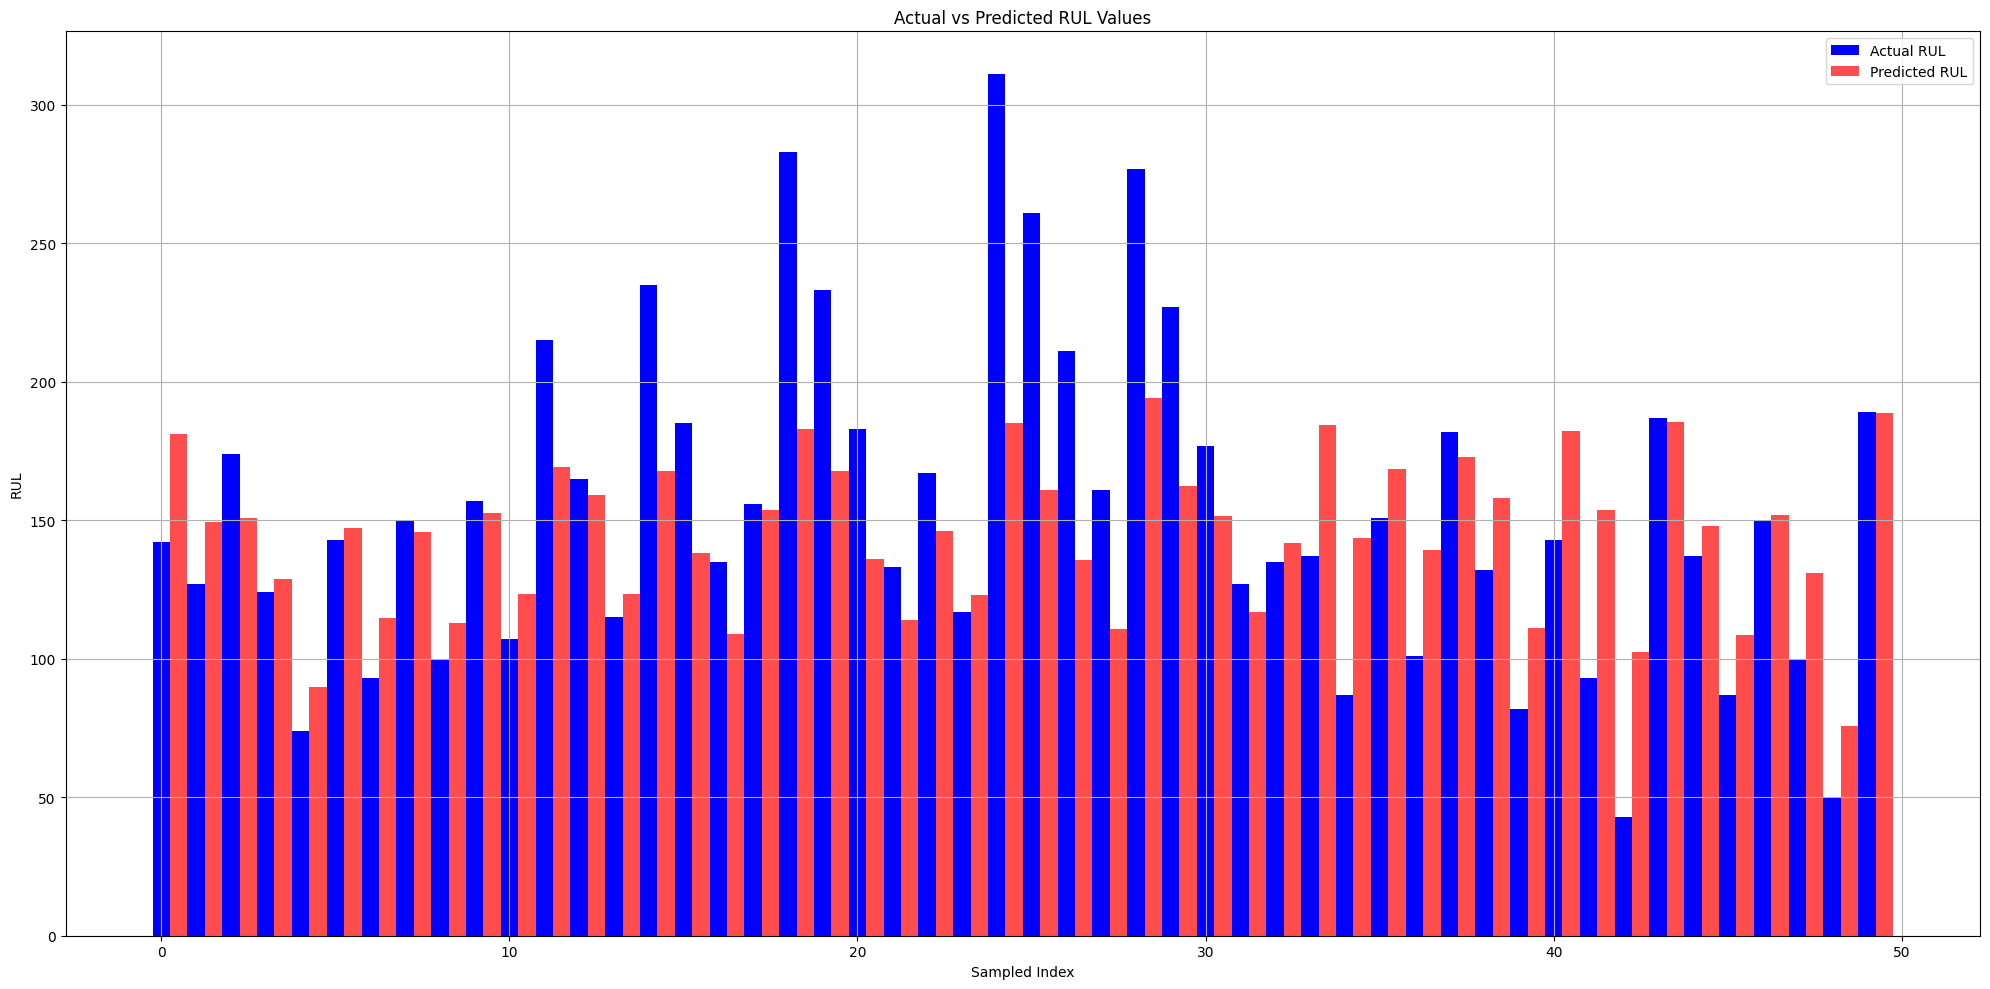

Training RMSE: 40.615699654605216, Validation RMSE: 39.71418002397619, Testing RMSE: 42.92224707974722


In [98]:
#evaluating linear regression model

def linreg_evaluation(training_dataset, testing_dataset):
    #we are dropping Unit_ID (engine number) as it does not carry meaningful information for prediction, and model might memorize Unit IDs rather than generalizing from patterns in the data
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"]) 
    y = training_dataset["RUL"] #target variable

    #splitting the training dataset (80% train and 20% validation using train_test_split function)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)

    #creating a linear regression model and fitting it to the data 
    model = LinearRegression().fit(X_train, y_train)

    #predicting the target variable RUL for the training dataset and evaluating performance.
    training_predictions = model.predict(X_train)
    training_rmse = mean_squared_error(y_train, training_predictions, squared = False) #(if squared = False, root mean squared error)

    #predicting the target variable RUL for the validation dataset and evaluating performance.
    validation_predictions = model.predict(X_validation)
    validation_rmse = mean_squared_error(y_validation, validation_predictions, squared =False)

    #testing dataset
    X_test = testing_dataset.drop(columns =["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #predicting the target variable RUL for the testing dataset and evaluating performance.
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared=False)

    #plotting actual RUL with predicted RUL values(training dataset)
    plot_predicted_vs_actual(y_test, testing_predictions)
    
    return training_rmse, validation_rmse, testing_rmse

start_time = time.time() #start time tracking

#Evaluating the performance of the model through RMSE values
lin_train_rmse, lin_val_rmse, lin_test_rmse = linreg_evaluation(pred_train_dataset, pred_test_dataset)

end_time = time.time() #end time
lin_reg_duration = end_time - start_time #calculating duration

print(f"Training RMSE: {lin_train_rmse}, Validation RMSE: {lin_val_rmse}, Testing RMSE: {lin_test_rmse}")

# Reference: (Scikit-Learn Developers, 2019)
# Reference: (Scikit-Learn Developers, 2023a)

We can conclude that linear regression might not be the optimal model for our analysis. In turbofan engines, each sensor value is critcal and important, we need to handle multicollinearity, autocorrelation, heteroscedasticity, and non-normality by still preserving the sensor values rather than dropping them. The above linear regression model provides a foundational benchmark. As the next step, we will be exploring other machine learning models.

**2. RANDOM FOREST REGRESSION MODEL**

Random Forest Regressor is an ensemble method, that builds multiple decision trees and combines their results to make the prediction. The individual trees might overfit to the training data, but by averaging the result of individual trees, the overfitting can be balanced out.

In [154]:
#evaluating random forest regressor model

def rfr_evaluation(training_dataset, testing_dataset):
    #we are dropping Unit_ID (engine number) as it does not carry meaningful information for prediction, and model might memorize Unit IDs rather than generalizing from patterns in the data
    X = training_dataset.drop(columns=["RUL", "Unit_ID"])
    y = training_dataset["RUL"]
    
    #splitting the training dataset (80% train and 20% validation using train_test_split function)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)

    #creating a random forest regression model and fitting it to the data 
    model = RandomForestRegressor(n_estimators = 100, random_state = 42).fit(X_train, y_train) #hyperparameter tuning will carried out later 
    
    #predicting the target variable RUL for the training dataset and evaluating performance.
    training_predictions = model.predict(X_train)
    training_rmse = mean_squared_error(y_train, training_predictions, squared = False)

    #predicting the target variable RUL for the validation dataset and evaluating performance
    validation_predictions = model.predict(X_validation)
    validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)

    #testing dataset
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #predicting the target variable RUL for the testing dataset and evaluating performance
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared=False)
    
    return training_rmse, validation_rmse, testing_rmse

#evaluating the performance of the random forest regressor model through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = rfr_evaluation(pred_train_dataset, pred_test_dataset)

print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

#reference: (Scikit-Learn Developers, 2023a)

Training RMSE: 13.589703283622054, Validation RMSE: 35.94103745371485, Testing RMSE: 41.54421077323069


The model is overfitting as there is a significant difference between training and validation RMSE.

**Transitioning from simple split to cross validation**

The above method provides a preliminary understanding of the model. A single split dataset using a fixed ratio might not fully capture the variability in the dataset. A more robust method such as K-Fold cross validation method can be used. This divides the dataset into subsets, then trained and validated. The data is randomised before being split, ensuring that the distribution is random across all of the folds. The dataset will undergo 5 fold cross validation process. In each iteration, one fold is reserved for validation, and the remaining four folds for training. This provides a generalised performance evaluation of the model. Finally by averaging the scores, we can easily get the estimate of model interpretability.

In [153]:
def rfr_cross_val(training_dataset, testing_dataset):

    #preparing the training dataset
    X = training_dataset.drop(columns=["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation
    
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #store RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #creating a random forest regression model and fitting it to the data 
        model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train) #parameters will be added after tuning
        
        #predicting the target variable RUL for the training dataset and evaluating performance.
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared=False)
        training_rmses.append(training_rmse)
        
        #predicting the target variable RUL for the validation dataset and evaluating performance
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared=False)
        validation_rmses.append(validation_rmse)

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns=["RUL", "Unit_ID"]) 
    y_test = testing_dataset["RUL"] 

    #predicting the target variable RUL for the testing dataset and evaluating performance
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared=False)

    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n
    
    return average_training_rmse, average_validation_rmse, testing_rmse

#Evaluating the performance of the random forest regressor model through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = rfr_cross_val(pred_train_dataset, pred_test_dataset)

print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

#reference: (Scikit-Learn Developers, 2023e)

Training RMSE: 13.540167154508088, Validation RMSE: 36.212948395972916, Testing RMSE: 41.50325492576955


It is observed that there is a huge difference between training RMSE and the validation/test RMSE. This indicates that the model is overfitting to the training data, meaning that it is performing well on training data but doesn't predict well on unseen data. The model seems to be influenced by the outliers and noise rather than capturing the patterns. The results for validation and test RMSE values are close, and difference isn't very large. The upcoming stages will help us to address the observed overfitting and optmise the current model.

**Hyperparameter tuning for random forest regressor:**

In Random Forest, overfitting might occur if there aren't enough trees, or if they are too deep. 

If there are not enough trees, the model cannot capture the underlying pattern and important feature interactions. If the tree is allowed to grow very deep, the tree might create leaves (end nodes) to individual data points, and memorize the training data, including the noise and outliers, rather than generalising.

Similarly if the threshold for min_samples_split is low, individual trees become very specific and overfit. If trees are allowed to create leaves with few samples, they can easily overfit the noise in training data.

Reconsidering the complexity of the model is very important. The hyperparameters should be adjusted to prevent the trees from growing too deep and overly too specific. Proper hyperparameters can lead to improved model performance.

In [49]:
#random search cross validation

#defining the possible hyperparameter values
param_rfr = {
    "n_estimators": [5, 15, 30, 45, 60, 75, 90, 100, 125], #number of trees in the forest
    "max_depth": [5, 50, 100, 250, 500], #maximum number of levels in each decision tree
    "min_samples_split": [2, 5, 10, 15, 20], #minimum number of data points in a node before the node is split
    "min_samples_leaf": [1, 2, 4, 10], #minimum number of data points allowed in a leaf node
    "bootstrap": [True, False] #method for sampling data points (with or without replacement)
}

#random forest model
rfr = RandomForestRegressor()

#RandomizedSearchCV
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = param_rfr, n_iter = 100, cv = 2, verbose = 2, random_state = 42, n_jobs = -1)

"""
 n_iter = Number of random combinations to try
 cv = 2-fold cross-validation
 verbose = controlling the verbosity: the higher, the more messages
 random_state = ensures reproducibility( we will fixing the random state to 42(for every model evaluation) to ensure that the data is split in the same way every time the code is run. This would help in comparing the performance evaluation of different models on same dataset.
 n_jobs = -1(use all the processors for faster computation)
"""

X = pred_train_dataset.drop(columns=["RUL", "Unit_ID"]) #independent variables excluding engine number
y = pred_train_dataset["RUL"] #target variable

#fitting the random search cross validation to the data
rfr_random.fit(X, y)

print(rfr_random.best_params_) #provides the best parameter during the search process

#reference: (Koehrsen, 2018)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
{'n_estimators': 30, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': True}


**Random forest regressor after hyperparameter tuning**

The optimal hyperparameters which enhance the random forest regressor model's performance have been identified. These parameters along with the KFold cross validation will be used, and model perfomance will be evaluated again.

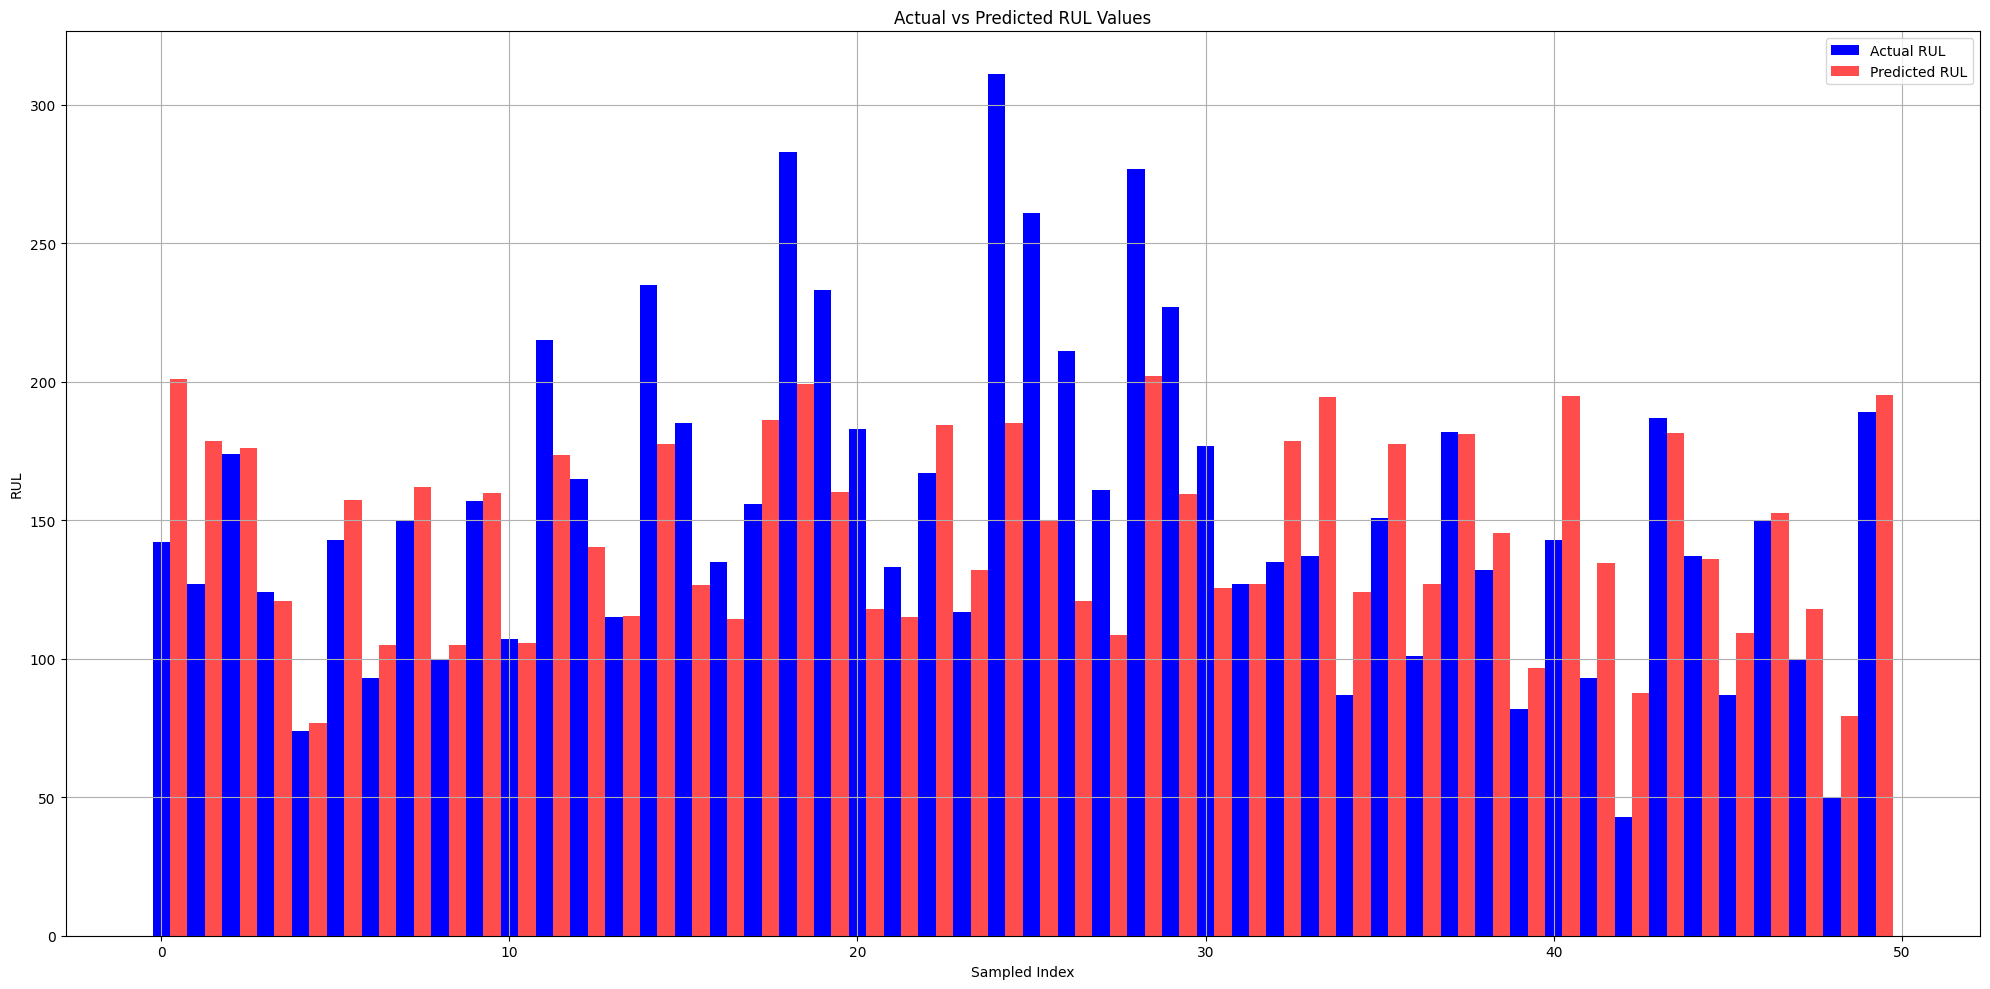

Training RMSE: 36.31207757144607, Validation RMSE: 37.06716703740362, Testing RMSE: 41.385559448291794


In [84]:
def rfr_final_evaluation(training_dataset, testing_dataset):

    #preparing the training dataset
    X = training_dataset.drop(columns=["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation
    
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #store RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #creating a random forest regression model and fitting it to the data 
        model = RandomForestRegressor(n_estimators = 30, min_samples_split = 15, min_samples_leaf = 1, max_depth = 5, bootstrap = True, random_state =42).fit(X_train, y_train) #added parameters
        #predicting the target variable RUL for the training dataset and evaluating performance.
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared=False)
        training_rmses.append(training_rmse)
        
        #predicting the target variable RUL for the validation dataset and evaluating performance
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared=False)
        validation_rmses.append(validation_rmse)

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns=["RUL", "Unit_ID"]) 
    y_test = testing_dataset["RUL"] 

    #predicting the target variable RUL for the testing dataset and evaluating performance
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared=False)

    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #plotting actual RUL with predicted RUL values(training dataset)
    plot_predicted_vs_actual(y_test, testing_predictions) 
    
    return average_training_rmse, average_validation_rmse, testing_rmse
    
start_time = time.time() #start time tracking

#Evaluating the performance of the random forest regressor model(cross validation + hyperparameter tuning) through RMSE values
rfr_train_rmse, rfr_val_rmse, rfr_test_rmse = rfr_final_evaluation(pred_train_dataset, pred_test_dataset)

end_time = time.time() #stop time tracking
rfr_duration = end_time - start_time #calculating duration

print(f"Training RMSE: {rfr_train_rmse}, Validation RMSE: {rfr_val_rmse}, Testing RMSE: {rfr_test_rmse}")

#reference: (Scikit-Learn Developers, 2023)

From the result, it is evident that the model does not overfit. However, the RMSE is slightly high on the unseen test dataset. It is necessary to explore other algorithms and determine the most suitable one. 

**3. BAGGED RANDOM FOREST REGRESSOR MODEL**

Bagged random forest regression model is one of the power ensemble algorithm that leaverages the combined prediction of multiple decision trees, and enhances accuracy. Bagging averages the predictions from various subsamples of data, reducing variance and overfitting. In this implementation, the random forest regressor will be employed as the base estimator. The parameters in the random forest regressor are already tuned, and ensures that each individual tree is optimized before their predictions are considered.

This model aim to capture the underlying structure and patterns in the dataset, offfering high predictive accuracy.

In [85]:
#evaluating bagged random forest regressor

def bagging_rfr_evaluation(training_dataset, testing_dataset):

    #preparing the training dataset 
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"]) #independent variables exclusing engine number
    y = training_dataset["RUL"] #target variable

    #splitting the training dataset (80% train and 20% validation using train_test_split function)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    #random forest regressor will be the base estimator (the same parameter after hyperparameter tuning the rfr will be used)
    base_estimator = RandomForestRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 2, max_depth = 5, bootstrap = True, random_state =42)

    #training the bagged random forest regression model
    model = BaggingRegressor(estimator = base_estimator, n_estimators = 100, random_state = 42).fit(X_train, y_train) #other parameters will be added after tuning

    #predicting the target variable RUL for the training set and calculating rmse for evaluation
    training_predictions = model.predict(X_train)
    training_rmse = mean_squared_error(y_train, training_predictions, squared = False)

    #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
    validation_predictions = model.predict(X_validation)
    validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)

    #splitting the testing dataset to indepent variables and target variable
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #predicting the target variable RUL for the testing dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)
    
    return training_rmse, validation_rmse, testing_rmse

#Evaluating the performance of the bagged random forest regression model through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = bagging_rfr_evaluation(pred_train_dataset, pred_test_dataset)
print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

#reference: (Scikit-Learn Developers, 2023b)

Training RMSE: 36.09740298177315, Validation RMSE: 36.179220226652234, Testing RMSE: 41.203760949869675


**Transitioning from simple split to K-Fold cross validation**

The KFold cross-validation, with five splits, provides a comprehensive assessment of the model's performance across different subsets of the data. In each iteration, one fold is reserved for validation, and remaining four folds are for training.

In [52]:
def bagging_rfr_cv(training_dataset, testing_dataset):

    #splitting the training dataset to independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation
    
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #random forest regressor will be the base estimator (the same parameter after hyperparameter tuning the rfr will be used)
        base_estimator = RandomForestRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 2, max_depth = 5, bootstrap = True, random_state =42)

        #training the bagged random forest regression model
        model = BaggingRegressor(estimator = base_estimator, n_estimators = 100, random_state =42).fit(X_train, y_train) #parameter will be choosen after tuning

        #predicting the target variable RUL for the training set and calculating rmse for evaluation
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared=False)
        training_rmses.append(training_rmse)

        #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared=False)
        validation_rmses.append(validation_rmse)
    
    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #predicting the target variable RUL for the testing dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared=False)

    return average_training_rmse, average_validation_rmse, testing_rmse

#Evaluating the performance of the bagged random forest regression model after cross validation through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = bagging_rfr_cv(pred_train_dataset, pred_test_dataset)
print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

Training RMSE: 36.00270217836956, Validation RMSE: 36.68081927648619, Testing RMSE: 41.113128762373805


**Hyperparameter tuning for bagged random forest regression**

The main objective of bagging with random forest is to reduce the variance of the model, and improve generalisation to unseen data. 

The n_estimators determines the number of base trees. A high value of n_estimators means more trees, which can capture the more complex relationships but also increased computation. Model with less trees might not capture the underlying patterns (Vadapalli, 2022).

The max_samples controls the fraction of the dataset to be drawn randomly to train each base estimator. A smaller fraction increases the diversity, but might not capture intricate patterns (Vadapalli, 2022).

The max_features decides the fraction of features to consider for the best split. This ensures each tree is trained on  adiverse set of features, and reduces overfitting.

The bootstrap and bootstrap_features add randomness to the model. When the bootstrap parameter is set to true, it allows the model to sample data with replacements (some data points might be selected multiple times for training a single tree). Similarly the bootstrap_features controls the random sampling of features with replacements (not all features might be used for a particular tree's decision-making) (Vadapalli, 2022). 

The hyperparameters should be selected in a way that the model neither overfits nor is it too generalised.

In [53]:
#base estimator for random forest regressor (the same parameter after hyperparameter tuning the rfr will be used)
base_estimator = RandomForestRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 2, max_depth = 5, bootstrap = True, random_state =42)

#defining the possible hyperparameter values for bagging regressor
param_bagging = {
    "n_estimators": [5, 10, 20, 30, 50], #number of base trees
    "max_samples": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #fraction of samples to be drawn
    "max_features": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #fraction of fearures to be drawn
    "bootstrap": [True, False], #samples drawn with replacement
    "bootstrap_features": [True, False] #features drawn with replacement
}

#RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = BaggingRegressor(estimator=base_estimator, random_state=42), param_distributions = param_bagging, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

#preparing the training dataset
X = pred_train_dataset.drop(columns = ["RUL", "Unit_ID"])
y = pred_train_dataset["RUL"]

#fitting the random search cross validation to the data
random_search.fit(X, y)

print(random_search.best_params_) #provides the best parameter during the search process

#reference: (Arya, 2022)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 20, 'max_samples': 0.9, 'max_features': 0.8, 'bootstrap_features': False, 'bootstrap': True}


**Bagged random forest regression model after hyperparameter tuning**

The optimal hyperparameters which enhance the Bagged Random Forest Regression model have been identified by using the random search cross validation. These parameters will be used in the model, and the perfomance of the model will be evaluated. 

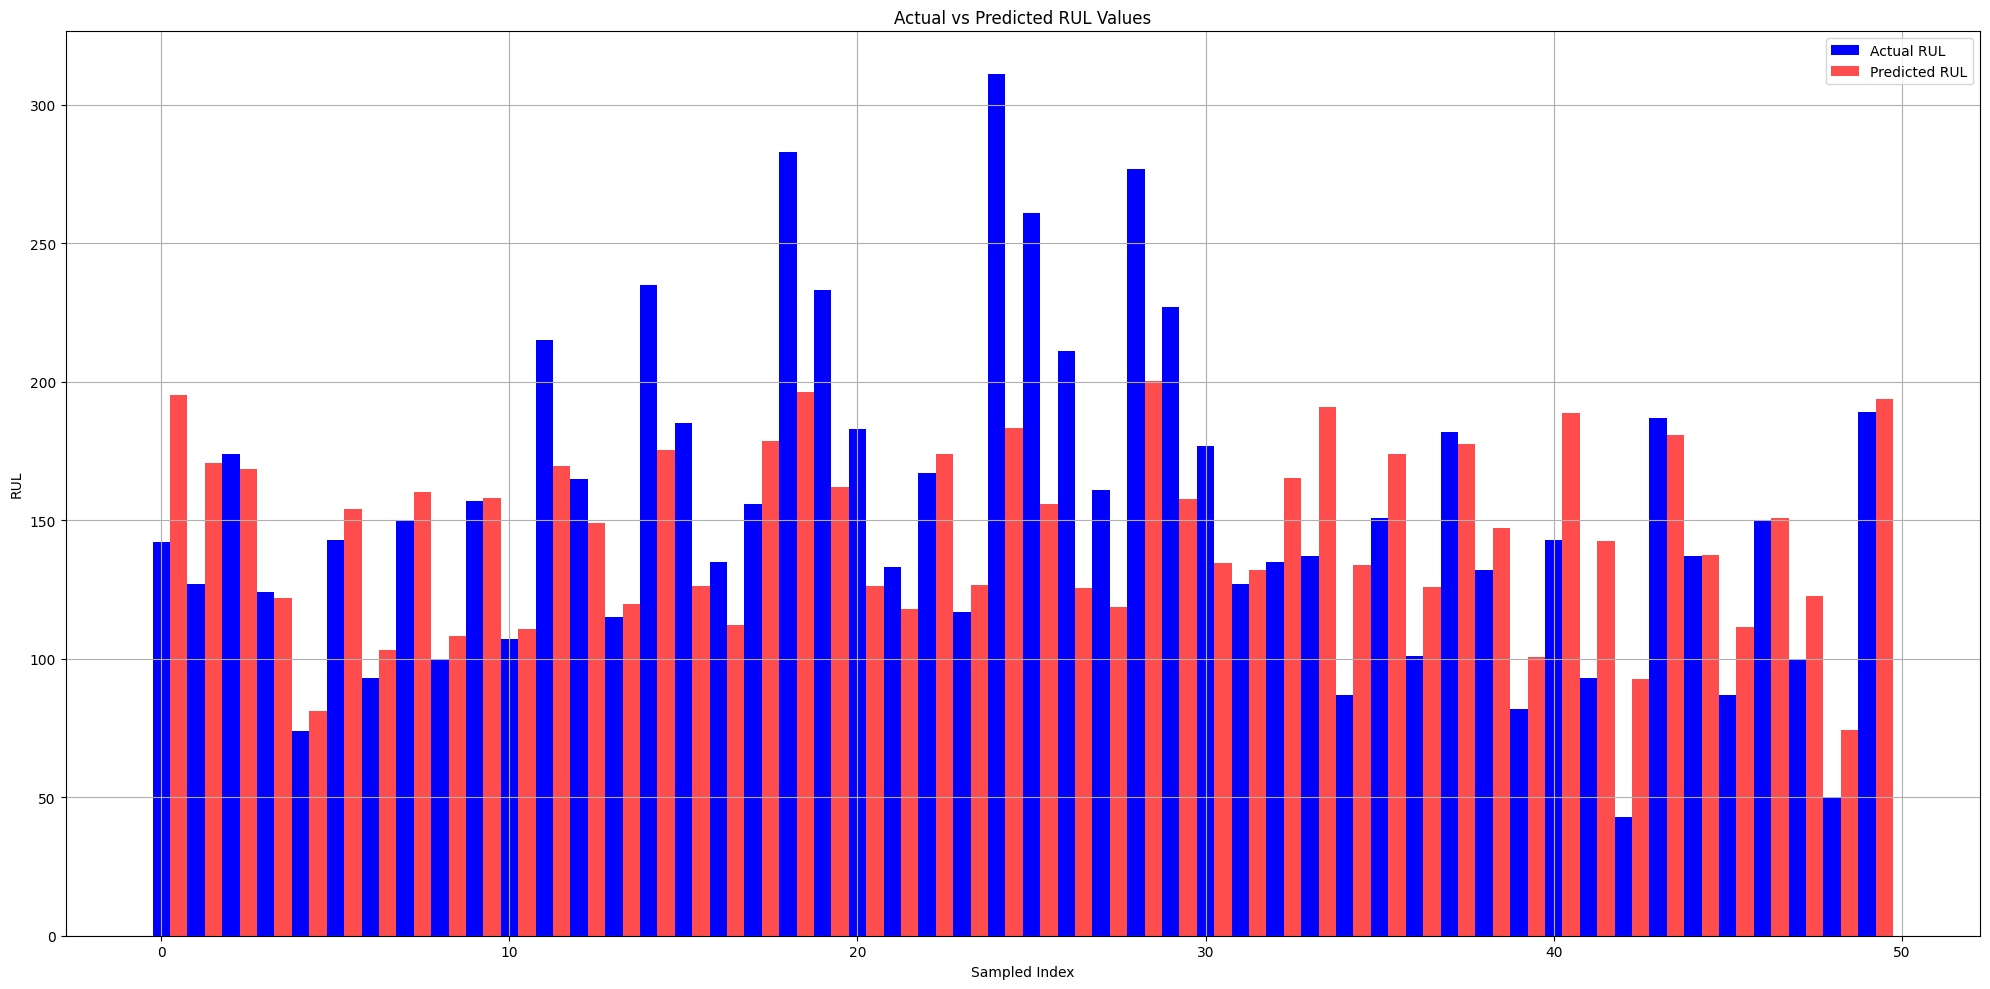

Training RMSE: 35.87968520823377, Validation RMSE: 36.47756355416465, Testing RMSE: 40.78232006940011


In [86]:
def bagging_rfr_final_evaluation(training_dataset, testing_dataset):

    #splitting the training dataset to independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation
    
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #random forest regressor will be the base estimator (the same parameter after hyperparameter tuning the rfr will be used)
        base_estimator = RandomForestRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 2, max_depth = 5, bootstrap = True, random_state =42)

        #training the bagged random forest regression model
        model = BaggingRegressor(estimator = base_estimator, n_estimators = 20, max_samples = 0.9, max_features = 0.8, bootstrap_features = False, bootstrap = True, random_state = 42).fit(X_train, y_train)

        #predicting the target variable RUL for the training set and calculating rmse for evaluation
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
        training_rmses.append(training_rmse)

        #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared =False)
        validation_rmses.append(validation_rmse)
    
    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #predicting the target variable RUL for the testing dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)

    #plotting actual RUL with predicted RUL values(training dataset)
    plot_predicted_vs_actual(y_test, testing_predictions)

    return average_training_rmse, average_validation_rmse, testing_rmse
    
start_time = time.time() #start time tracking

#Evaluating the performance of the bagged random forest regression model through RMSE values
bag_rfr_train_rmse, bag_rfr_val_rmse, bag_rfr_test_rmse = bagging_rfr_final_evaluation(pred_train_dataset, pred_test_dataset)

end_time = time.time() #stop time tracking
bag_rfr_duration = end_time - start_time #calculating duration

print(f"Training RMSE: {bag_rfr_train_rmse}, Validation RMSE: {bag_rfr_val_rmse}, Testing RMSE: {bag_rfr_test_rmse}")

#reference: (Scikit-Learn Developers, 2023b)

While comparing these results with the RMSE values before tuning, a noticeable improvement in the model performance is found. The test score of 40.78 reveals that the model has been well generalised to unseen data. Overall without hyperparameter tuning, the model demonstrated reasonable predictive power. Reviewing other models like xGBoost could further provide insights into the best modeling approach.

**4. EXTREME GRADIENT BOOSTING(XGBoost) MODEL:**

XGBoost is an ensemble learning algorithm based on the gradient boost framework. While random forests create trees independently, the XGBoost algorithm creates a series of decision trees sequentially, and each tree corrects the errors of its predecessor, aiming to improve the performance for the subsequent tree (Brownlee, 2020b). This iterative approach can help achieve a significant model performance.

In [145]:
def xgboost_evaluation(training_dataset, testing_dataset):

    #splitting the training dataset into independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"]) 
    y = training_dataset["RUL"]

    #splitting the training dataset (80% train and 20% validation using train_test_split function)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)

    #initialising xGBoost regression model and fitting it to the training data 
    model = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators = 100, random_state = 42).fit(X_train, y_train)

    #predicting the target variable RUL for the training dataset and evaluating performance.
    training_predictions = model.predict(X_train)
    training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
    
    #predicting the target variable RUL for the validation dataset and evaluating performance
    validation_predictions = model.predict(X_validation)
    validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns =["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #predicting the target variable RUL for the testing dataset and evaluating performance
    testing_predictions = model.predict(X_test)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)

    return training_rmse, validation_rmse, testing_rmse

#Evaluating the performance of the xGBoost regression model through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = xgboost_evaluation(pred_train_dataset, pred_test_dataset)

print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

#reference: (Nikki2398, 2020)

Training RMSE: 22.45706793056434, Validation RMSE: 37.44833228575452, Testing RMSE: 43.841436140299145


**Transitioning from simple split to cross validation and DMatrix data structure**

A significant difference between training and validation/test RMSE values indicates that the model might be overfitting the training data. The model might not predict well on unseen datapoints. The  K-Fold cross validation method to capture the complete variability rather than a single split will be carrried out. For each split, a Dmatrix object(memory efficient) is created for training and validation data. This DMatrix data structure enables faster training and improved performance compared to other standard data structures. 

In [146]:
def xgb_dmatrix_cv(training_dataset, testing_dataset):

    #preparing the training dataset into independent variables and target variable
    X = training_dataset.drop(columns=["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5  #number of splits for cross validation
     
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation
    
    #store RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #converting both training and validation data into DMatrix format
        train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
        validation_dmatrix = xgb.DMatrix(data = X_validation, label = y_validation)

        param = {"booster": "gbtree", #tree based model boosting algorithm
                 "objective": "reg:squarederror", #squared error as the objective learning task
                 "random_state": 42} #to ensure reproducability, we will fixing the random state to 42(for every model evaluation) to ensure that the data is split in the same way every time the code is run. This would help in comparing the performance evaluation of different models on same dataset.

        #training the xgBoost model (other parameters will be used after hyperparameter tuning)
        model = xgb.train(params =param, dtrain = train_dmatrix, num_boost_round = 100) #num_boost_round corresponds to the number of boosting trees to build(cannot be passed in params)

        #predicting the target variable RUL for the training set and evaluating performance.
        training_predictions = model.predict(train_dmatrix)
        training_rmse = mean_squared_error(y_train, training_predictions, squared=False)
        training_rmses.append(training_rmse)
        
        #predicting the target variable RUL for the validation set and evaluating performance
        validation_predictions = model.predict(validation_dmatrix)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared=False)
        validation_rmses.append(validation_rmse)
    
    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns=["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #converting the testing data into DMatrix format
    test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)

    #predicting the target variable RUL for the testing set and evaluating performance
    testing_predictions = model.predict(test_dmatrix) 
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared=False)

    return average_training_rmse, average_validation_rmse, testing_rmse

#Evaluating the performance of the xGBoost regression model using DMatrix and cross validationd through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = xgb_dmatrix_cv(pred_train_dataset, pred_test_dataset)
print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

#reference: (Cambridge Spark, 2019)
#reference: (Scikit-Learn Developers, 2023c)

Training RMSE: 22.729371802007506, Validation RMSE: 37.475250742711104, Testing RMSE: 43.26781296980237


**Hyperparameter tuning for xGBoost**

The xGBoost constructs the model in a sequential manner, optimising the accuracy in sucessive steps. The balance between bias and variance is very important. With no proper constraints, the model can fit too close to training data, capturing noise and leading to overfitting. 

Learning rate should be carefully considered, as high learning rates might lead the model to converge too fast, missing out on more optimal configurations. Similarly a low learning rate can lead to extended training times without any improvement in performance.

If the depth of a tree is high, it captures more underlying patterns and overfits closely with the training dataset. Trees with low depth might not capture essential patterns leading to underfitting.

Alpha and lamba are regularisation parameters. They add penalty to model complexity, help to counterfit overfitting by adding bias. But too much regularisation can prevent the model from capturing intricate patterns. 

Choosing the optimal parameter and leveraging the strength while minimising current challenges is very important.

In [90]:
#defining the possible hyperparameter values
param_xgb = {
    "alpha": [0.01, 0.05, 0.1, 0.5, 1], #L1 regularization term on weights(absolute values of the weights)
    "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],  #minimum loss reduction to create new tree-split
    "lambda": [0.5, 1, 1.5, 2, 3],  #L2 regularization term on weights(square of the weight)
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2], #lower learning rate make the optimization more robust
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10], #maximum number of nodes allowed
    "min_child_weight": [1, 2, 3, 4, 5], #number of samples required in order to create a new node
    "objective": ['reg:squarederror'], #minimize the squared error between the predicted and actual values
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1], #fraction of features (columns) to use
    "subsample": [0.6, 0.7, 0.8, 0.9, 1], #fraction of observations (rows) to subsample
    }

#XGBoost model
xgb = xgb.XGBRegressor()

#RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = param_xgb, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

"""
 n_iter = Number of random combinations to try
 cv = 3-fold cross-validation
 verbose = controlling the verbosity: the higher, the more messages
 random_state = ensures reproducibility( we will fixing the random state to 42(for every model evaluation) to ensure that the data is split in the same way every time the code is run. This would help in comparing the performance evaluation of different models on same dataset.
 n_jobs = -1(use all the processors for faster computation)
"""

X = pred_train_dataset.drop(columns=["RUL", "Unit_ID"]) #independent variables excluding Unit_ID
y = pred_train_dataset["RUL"] #target variable

#fitting the random search cross validation to the data
xgb_random.fit(X, y)

print(xgb_random.best_params_) #provides the best parameter during the search process

#reference: (Khandelwal, 2020)
#reference: (Cambridge Spark, 2019)
#reference: (Jain, 2016)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 1, 'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'lambda': 1.5, 'gamma': 0.3, 'colsample_bytree': 0.7, 'alpha': 0.1}


**xGBoost after hyperparameter tuning**

The optimal hyperparameters which enhance the xGBoost model's performance have been identified. These parameters along with the DMatrix and KFold cross validation will be used, and model perfomance will be evaluated. 

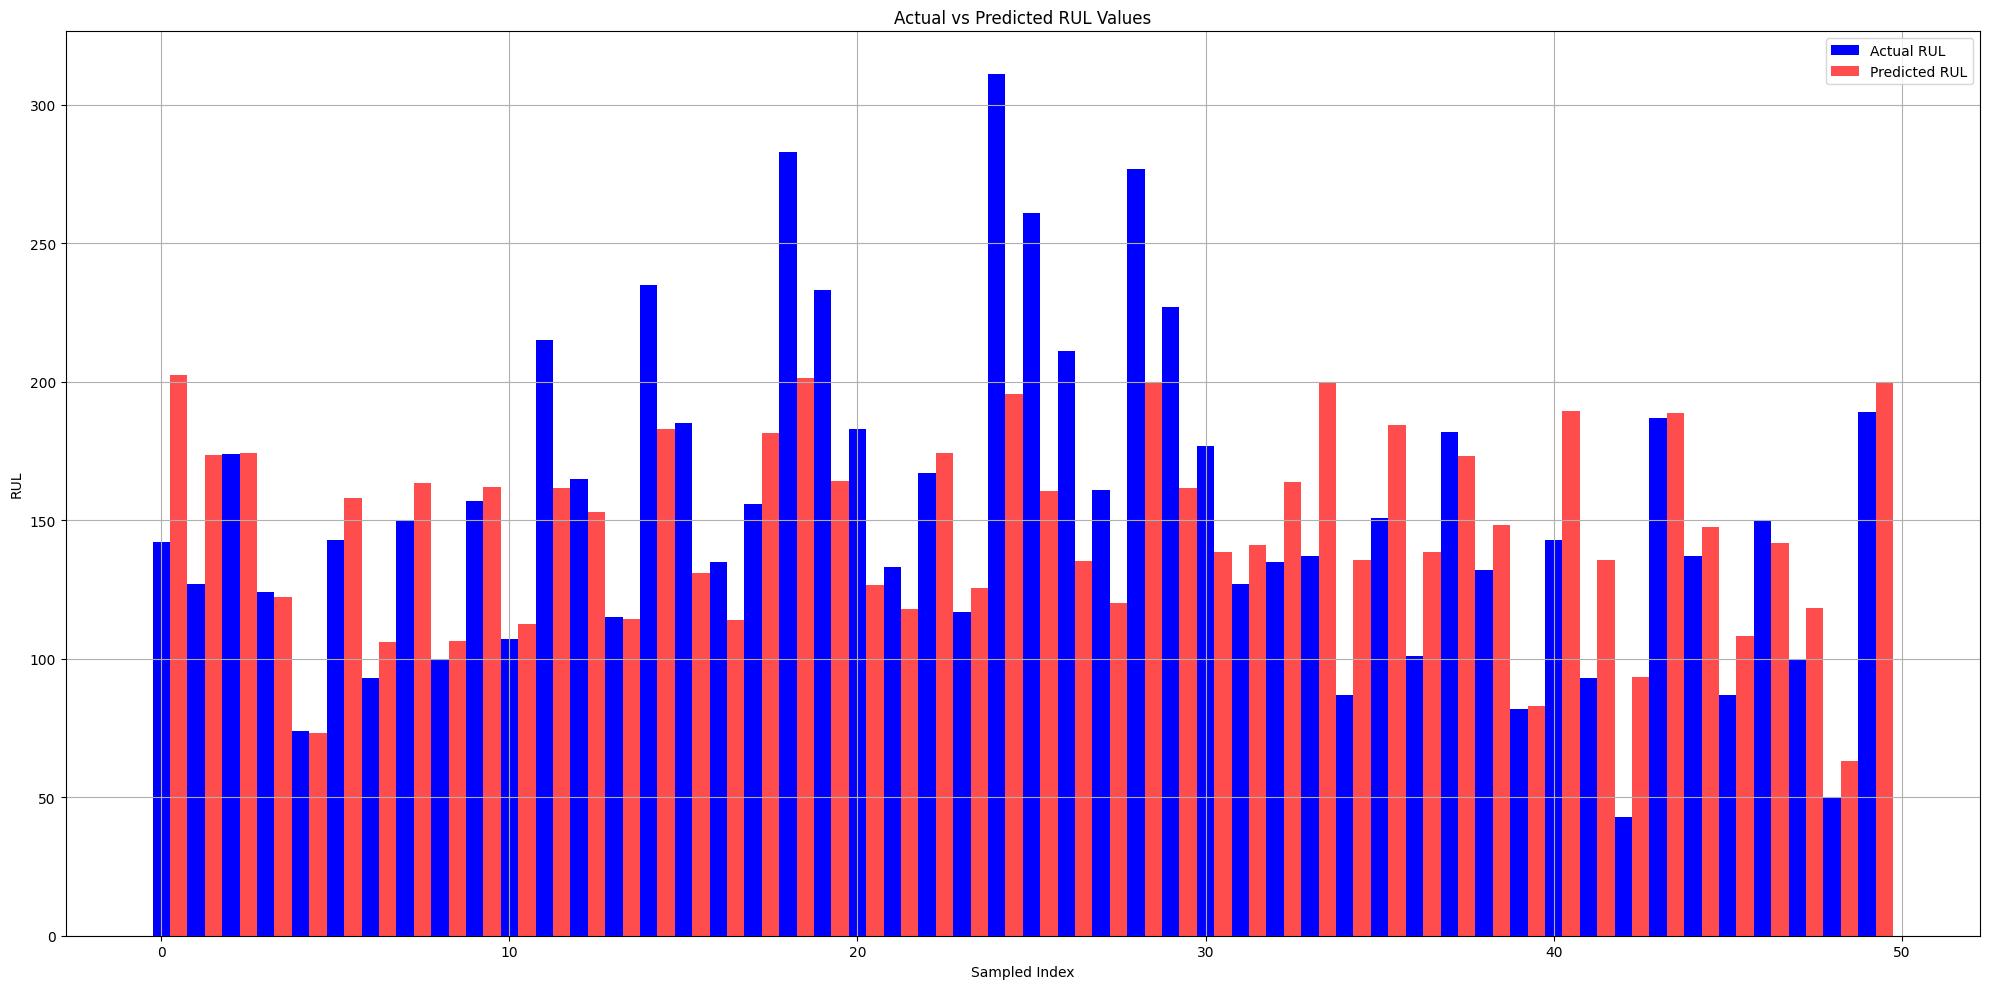

Training RMSE: 34.583413778140695, Validation RMSE: 35.95781433270919, Testing RMSE: 40.476654662779886


In [147]:
import xgboost as xgb

def xgb_final_evaluation(training_dataset, testing_dataset):
    
    #preparing the training dataset into independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation
    
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X):
        
        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #converting both training and validation data into DMatrix format
        train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
        validation_dmatrix = xgb.DMatrix(data = X_validation, label = y_validation)
        
        #parameters after hyperparameter tuning
        param = {"booster": "gbtree", "objective": "reg:squarederror", "alpha": 0.1, "gamma": 0.3, "lambda": 1.5, "learning_rate": 0.05, "max_depth": 4, "min_child_weight": 5, "subsample": 1, "colsample_bytree": 0.7, "random_state": 42}

        #training the xgBoost model
        model = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 100) #num_boost_round corresponds to the number of boosting trees to build(cannot be passed in params)

        #predicting the target variable RUL for the training set and evaluating performance
        training_predictions = model.predict(train_dmatrix)
        training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
        training_rmses.append(training_rmse)

        #predicting the target variable RUL for the validation set and evaluating performance
        validation_predictions = model.predict(validation_dmatrix)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)
        validation_rmses.append(validation_rmse)
        
    #calculating the average RMSE(training and validation) over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #preparing the testing dataset into independent variables and target variable
    X_test = testing_dataset.drop(columns=["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #converting the testing data into DMatrix format
    test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)
    testing_predictions = model.predict(test_dmatrix) 
    
    #predicting the target variable RUL for the testing set and evaluating performance
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared =False)

    #plotting actual RUL with predicted RUL values(training dataset)
    plot_predicted_vs_actual(y_test, testing_predictions)

    return average_training_rmse, average_validation_rmse, testing_rmse

start_time = time.time() #start time tracking

#Evaluating the performance of the xGBoost regression model through RMSE values
xgb_train_rmse, xgb_val_rmse, xgb_test_rmse = xgb_final_evaluation(pred_train_dataset, pred_test_dataset)

end_time = time.time() #stop time tracking
xgb_duration = end_time - start_time #calculating duration

print(f"Training RMSE: {xgb_train_rmse}, Validation RMSE: {xgb_val_rmse}, Testing RMSE: {xgb_test_rmse}")

#reference: (XGBoost Developers, 2021)
#reference: (Banerjee, 2020)

The xGBoost after hyperparameter tuning has demonstrated a good performance across the training and validation datasets. The RMSE is slightly high on the unseen test dataset, but still seems a fair consistent performance. While xGBoost has showcased its predictive capabilities in this scenario, exploring other models like Support Vector Regression could further provide insights into the best modeling approach.

**5. SUPPORT VECTOR REGRESSION(SVR) MODEL**

Support Vector Regression (SVR) model works by calculating distances between data points to determine the optimal hyperplane. They convert input data into a highly dimensional feature space and then identify a boundary that divides the data points, ensuring it is as far from the closest points as possible, but it is still making accurate predictions (Sethi, 2020).

SVR model is very sensitive to the scale of the data. When features in the dataset have different scales, those with larger scales can excessively influence the model, potentially leading to reduced efficiency. Standard scaler will be used to transform/rescale the distribution of dataset such that each feature has a mean of 0 and a standard deviation of 1. All the features using the same scale will help SVR make accurate and consitent predictions (Brownlee, 2020a).

In [59]:
#evaluating the support vector regressor model

def svr_evaluation(training_dataset, testing_dataset):

    #dividing the training dataset to independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    #splitting the training dataset (80% train and 20% validation using train_test_split function)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 42)

    #rescaling the distribution of values using standardscaler(each feature has a mean of 0 and a standard deviation of 1)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    #training the support vector regression model
    model = SVR().fit(X_train_scaled, y_train)

    #predicting the target variable RUL for the training set and calculating rmse for evaluation
    training_predictions = model.predict(X_train_scaled)
    training_rmse = mean_squared_error(y_train, training_predictions, squared = False)

    #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
    validation_predictions = model.predict(X_validation_scaled)
    validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)

    #preparing the testing dataset
    X_test = testing_dataset.drop(columns =["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #scaling the testing dataset
    X_test_scaled = scaler.transform(X_test)

    #predicting the target variable RUL for the testimg dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test_scaled)
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared =False)
    
    return training_rmse, validation_rmse, testing_rmse

#Evaluating the performance of the SVR model through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = svr_evaluation(pred_train_dataset, pred_test_dataset)

print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

#reference: (Scikit-Learn Developers, 2023d)

Training RMSE: 38.542342280767514, Validation RMSE: 37.75651736439911, Testing RMSE: 42.82948198974288


**Transitioning from simple split to cross validation**

The  K-Fold cross validation method will be used to capture the complete variability rather than a single split. The dataset will undergo 5 fold cross validation process. In each iteration, one fold is reserved for validation, and remaining four folds for training. This provides a generalised performance evaluation of the model.

In [92]:
def svr_cv_evaluation(training_dataset, testing_dataset):

    #preparing the training dataset 
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation

    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation
    
    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #rescaling the distribution of values using standardscaler
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    #looping through each fold in cross validation
    for train_index, validation_index in kf.split(X_scaled):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X_scaled[train_index], X_scaled[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #training the support vector regression model
        model = SVR().fit(X_train, y_train) #parameters will be added after tuning

        #predicting the target variable RUL for the training set and calculating rmse for evaluation
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
        training_rmses.append(training_rmse)
        
        #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)
        validation_rmses.append(validation_rmse)

    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #splitting the testing dataset to indepent variables and target variable
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]   

    #scaling the testing dataset with same standard scaler
    X_test_scaled = scaler.transform(X_test)

    #predicting the target variable RUL for the testing dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test_scaled) 
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)

    return average_training_rmse, average_validation_rmse, testing_rmse

#Evaluating the performance of the SVR model through RMSE values
train_rmse_1, val_rmse_1, test_rmse_1 = svr_cv_evaluation(pred_train_dataset, pred_test_dataset)
print(f"Training RMSE: {train_rmse_1}, Validation RMSE: {val_rmse_1}, Testing RMSE: {test_rmse_1}")

Training RMSE: 38.395707366962384, Validation RMSE: 38.54519025857522, Testing RMSE: 42.9174153047078


**Hyperparameter tuning for support vector regression**

The primary objective of SVR is to find the best hyperplane that describes the data, therefore the choice of hyperparameter significantly controls and impacts the properties of the hyperplane. 

The cost parameter(C) controls the tradeoff between maximising the boundary and minimizing the error rate. Low value of C might lead to a wider margin, allowing some misclassifications. Larger value of C will classify corrrectly by selecting a smaller margin hyperplane, but would lead to overfitting (Kumar, 2023).

The kernel parameter conveys the type of surface SVR tries to fit on the data. Linear kernel tries to fit a linear plane. Kernel like rbf(radial basis function) attempts to fit more intricate, non-linear data strctures. However, using a complex structure for simple data can overcomplicate and lead to overfitting (Kumar, 2023).

When using an RBF kernel, it is relevant to use gamma parameter. This defines how far a single training example could possibly reach. Low gamma values means that the influence of the training example is far reaching(flexible model), while high gamma values short reach(influence) and could lead to overfitting (Yildirim, 2020).

Epsilon determines the margin of tolerance(no penalty given for errors). Large epsilon values could make model underfit, and low epsilon values would lead to overfitting due to overly sensitive to training data.

Properly analysing these hyperparameters is very crucial to ensure the model captures the intricate data patterns without becoming overly specific or generalised.

In [61]:
#defining the possible hyperparameter values
param_svr = {
    "C": [0.5, 1, 5, 10, 50, 100, 500], #regularisation parameter
    "kernel": ["linear", "rbf"], #type of hyperplane to seperate the data
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1], #kernal coefficient of rbf, poly, and sigmoid
    "epsilon": [0.01, 0.1, 0.5, 1, 2, 5] #margin of tolerance
}

#SVR model
svr = SVR()

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = svr, param_distributions = param_svr, n_iter = 100, cv =2, verbose = 2, random_state = 42, n_jobs = -1)

"""
 n_iter = Number of random combinations to try
 cv = 3-fold cross-validation
 verbose = controlling the verbosity: the higher, the more messages
 random_state = ensures reproducibility( we will fixing the random state to 42 to ensure that the data is split in the same way every time the code is run. This would help in comparing the performance evaluation of models on same dataset.
 n_jobs = -1(use all the processors for faster computation)
"""

X = pred_train_dataset.drop(columns=["RUL", "Unit_ID"]) #independent variables excluding engine number
y = pred_train_dataset["RUL"] #target variable

#scaling the data
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

#fitting the random search cross validation to the data
random_search.fit(X_scaled, y)

print(random_search.best_params_) #provides the best parameter during the search process

#reference: (Scikit-Learn Developers, 2023d)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
{'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 2, 'C': 500}


**Support vector regression after hyperparameter tuning**

The optimal hyperparameters which enhance the SVR model's performance have been identified by using the random search cross validation. These parameters will be used in the model, and perfomance of the model will be evaluated. 

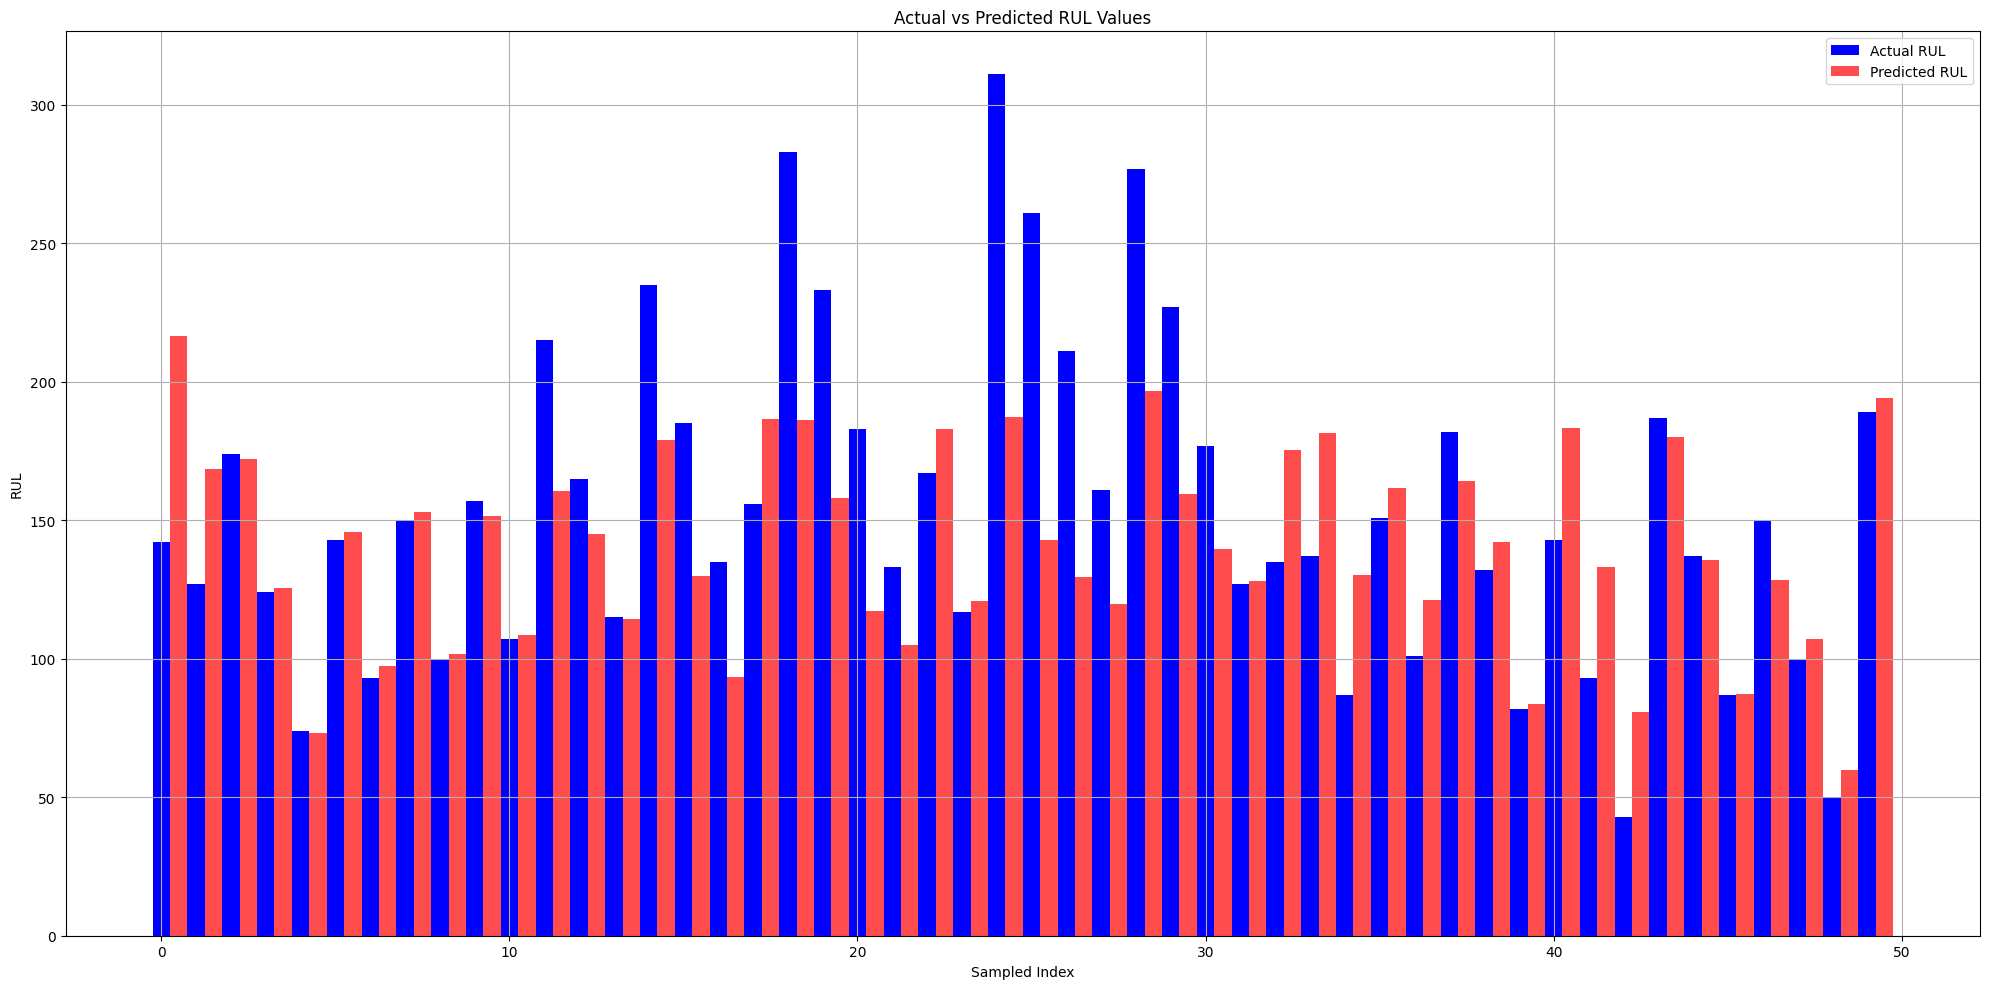

Training RMSE: 36.478666631320955, Validation RMSE: 36.83319537367233, Test RMSE: 41.48992015415781


In [93]:
def svr_final_evaluation(training_dataset, testing_dataset):

    #preparing the training dataset 
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    n = 5 #number of splits for cross validation

    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation
    
    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #rescaling the distribution of values using standardscaler
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    #looping through each fold in cross validation
    for train_index, validation_index in kf.split(X_scaled):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X_scaled[train_index], X_scaled[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #training the support vector regression model
        model = SVR(C = 500, kernel = "rbf", gamma = 0.01, epsilon =2).fit(X_train, y_train) #parameters added after tuning

        #predicting the target variable RUL for the training set and calculating rmse for evaluation
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
        training_rmses.append(training_rmse)
        
        #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)
        validation_rmses.append(validation_rmse)

    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #splitting the testing dataset to indepent variables and target variable
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]   

    #scaling the testing dataset with same standard scaler
    X_test_scaled = scaler.transform(X_test)

    #predicting the target variable RUL for the testing dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test_scaled) 
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)

    #plotting actual RUL with predicted RUL values(training dataset)
    plot_predicted_vs_actual(y_test, testing_predictions)

    return average_training_rmse, average_validation_rmse, testing_rmse

start_time = time.time() #start time tracking

#Evaluating the performance of the SVR model through RMSE values
svr_train_rmse, svr_val_rmse, svr_test_rmse = svr_final_evaluation(pred_train_dataset, pred_test_dataset)

end_time = time.time() #stop time tracking
svr_duration = end_time - start_time #calculating duration

print(f"Training RMSE: {svr_train_rmse}, Validation RMSE: {svr_val_rmse}, Test RMSE: {svr_test_rmse}")

The result shows the model has been a slight improvement after hyperparameter tuning. The minimal difference between the training and validation scores indicates that the model has been showing a consitent performance. The testing RMSE scores after tuning indicates that the model maintains a reasonable predictive accuracy on an entirely unseen test dataset.

**6. LONG SHORT-TERM MEMORY (LSTM):**

LSTM is an type of RNN(Recurrent Neural Network) designed for time series data, and to identify the pattern over sequence of data. They are well suited for time series analysis due to their ability to maintain memory of previous input(remembering patterns over sequence), and capture temporal dependencies (Brownlee, 2018a). The turbofan degradation dataset records the engine health over time(degradation), and LSTM can be particularly effective in predicting the remaining useful life of engine due to nature of data.

**Model Architecture**

The distribution of training dataset is normalised by MinMax scaler, and reshaped from 2D to 3D arary. This is beacuse the LSTM accepts the input in form of [samples(rows), timesteps, features(coloumns)] (Brownlee, 2018b). 

This model is an stacked LSTM model, using the sequential. The model consists of three layers, followed by two dense layers. The first two layers return the full sequence to the next layer(return_sequences = True). The final third layer do not return any sequence, and is followed by dense layers.

Dropout layers(regularisation) are seen in the model to prevent overfitting. By setting dropout, fraction of input units (20%) to zero at each update . This helps in regularising the model (Brownlee, 2017).

There are two dense layers. First one has 10 neurons, and with the help of relu(rectified linear unit) activation function, non-linearity is introduced. Relu outputs the input directly if positive, else outputs zero. They train faster(computationally effcient), allow model to learn intricate relationships, and also helps mitigating the vanishing gradient problem faced in previous RNN networks. The final dense layer has 1 neuron(output) predicting the RUL value (Brownlee, 2019). 

The model uses adam optimiser, known for the adaptive learning rates, leading to faster convergence. It is an stochastic gradient descent method based on estimation of first and second order moments. It is computationally efficient(little memory requirements), and very useful for our dataset that has large variation between features (Alabdullatef, 2020). 

The model uses rms_prop, known for the adaptive learning rates, leading to faster convergence. It is an optimisation algorithm that divides the learning rate by the exponential decay mean of square gradients. It is computationally efficient (little memory requirements), and very useful for our dataset that has large variation between features. 

Early stopping(regularisation) callbacks were made, if the validation loss did not improve for 10 epochs, training will be stopped. This will help in avoiding the overfitting of training data and save computational time. The restore_best_weights ensures weights are rolled back to the state where loss is minimum (Brownlee, 2018b).

The batch size determines the number of samples to be used in iteration to update model's weight. The validation parameter continously ensures the model is being evaluated for unseen data after each epoch. This is essential for early stopping callback(stop training to avaoid overfitting).

KFold Cross-Validation is also implemented. The dataset will undergo 5 fold cross vaklidation process. In each iteration, one fold is reserved for validation, and remaining four fold for training. This provides a generalised performance evaluation of the model. 

This model can capture underlying patterns and relationship, and is suited for the time series dataset.

**K-Fold Cross Validation and Hyperparameter Tuning for LSTM**

Combining the k-fold validation with hyperparameter tuning ensures hyperparameters are well generalised to unseen data. The aim here is to find the best combination of learning rate and optimiser for the LSTM model. The three optimizers such adam, rms_prop and adadelta are considered. The nested loop iterates over each and every possible combination of optimizers and learning rate, and provides the best combination on the lowest test RMSE value.

In [160]:
def lstm_evaluation(training_dataset, testing_dataset, optimizer):

    #splitting the training dataset to independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]

    #normalising the distribution using MinMax scaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    #reshaping the data for LSTM layers (2D array to 3D array)
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1])) #[samples (rows), timesteps, features(columns)]

    n = 5  #number of splits for cross-validation

    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X_reshaped):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X_reshaped[train_index], X_reshaped[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        #initialising the sequential LSTM model(three layers- each layer has one input tensor and one output tensor)
        model = Sequential()

        #first LSTM layer with 100 neurons (LSTM will output a sequence with 100 values for each input timestep)
        #activation_function(relu - rectified linear unit) outputs the input directly if positive, else outputs zero. introduces non-linearity, and allow model to learn intricate relationships
        model.add(LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True, activation = 'relu')) #input_shape takes two values(timesteps, number of columns per timestep)
        model.add(Dropout(0.2)) #regularisation to reduce overfitting (dropping 20% of input units to zero at each update)

        #followed by second LSTM layer with 50 neurons
        model.add(LSTM(50, return_sequences = True, activation = "relu")) #(return_sequence indicates to return the full sequence to the next layer)
        model.add(Dropout(0.2)) #regularisation to reduce overfitting

        #followed by third LSTM layer with 25 neurons
        model.add(LSTM(25, return_sequences = False, activation = "relu")) #return output of the last timestep(no more LSTM layers, no need of returning full sequence)
        model.add(Dropout(0.2)) #regularisation to reduce overfitting

        #fully connected layers(each neuron will recieve input from every neuron of the previous layer)
        model.add(Dense(10, activation = "relu")) #(relu trains network faster without significant penalty)
        model.add(Dense(1)) #final output dense layer

        #optimizer = optimizers.Adam(learning_rate=lr)
        #compiling the model
        model.compile(optimizer = optimizer, loss ="mse") # (adam's adaptive nature and efficiency can help in navigating the loss surface, and converging to a good solution)

        #earlyStopping callback for better convergence(if the validation loss did not improve for 10 epochs, stop training)
        early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True) #(restore_best_weights- ensures weights are rolled back where loss is minimum)

        #fitting the model
        history = model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_validation, y_validation), verbose = 0, shuffle = False, callbacks=[early_stopping]) #early stopping callback made

        #predicting the target variable RUL for the training set and calculating rmse for evaluation
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
        training_rmses.append(training_rmse)

        #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)
        validation_rmses.append(validation_rmse)

    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #preparing the testing dataset to independent variables and target variable
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #normalising and reshaping the testing data for LSTM layers
    X_test_scaled = scaler.transform(X_test)
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test_reshaped).flatten() #ensure prediction is 1D array
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)

    #plotting actual RUL with predicted RUL values(training dataset)
    #plot_predicted_vs_actual(y_test, testing_predictions)

    return average_training_rmse, average_validation_rmse, testing_rmse, history, model

#defining teh class for optimisers
class OptimizersEnum(Enum):
    adam = "adam"
    rmsprop = "rms_prop" 
    adadelta = "adadelta"

#dictionary to map optimisers
optimizers_col = {
    'adam': lambda lr: tf.keras.optimizers.legacy.Adam(learning_rate=lr),
    'rms_prob': lambda lr: tf.keras.optimizers.legacy.RMSprop(learning_rate=lr),
    'adadelta': lambda lr: tf.keras.optimizers.legacy.Adadelta(learning_rate=lr)
}

#dictionaries to store the training results, models, evaluation metric values for the optimiser and learning rate combinations
histories = {}
models = {}
train_rmses = {}
val_rmses = {}
test_rmses = {}

learning_rates = [0.001, 0.01, 0.1] #list of learning rates

#iterating through each optimiser and learning rate combination
for optimizer in optimizers_col:
    for learning_rate in learning_rates:
        current_optimizer = optimizers_col[optimizer](learning_rate) #creating an instance of the combination

        #evaluating the  LSTM model
        train_rmse, val_rmse, test_rmse, history, trained_model = lstm_evaluation(pred_train_dataset, pred_test_dataset, current_optimizer)

        #key to store the combination
        key = optimizer + "_" + str(learning_rate)

        #storing the results in dictionaries
        histories[key] = history
        models[key] = trained_model
        train_rmses[key] = train_rmse
        val_rmses[key] = val_rmse
        test_rmses[key] = test_rmse


#identifying the best model based on testing RMSE
best_model_key = min(test_rmses, key = test_rmses.get)
best_model = models[best_model_key]
best_history = histories[best_model_key]

print(f"Best Model Optimizer and Learning Rate: {best_model_key}")
#print(f"Training RMSE: {train_rmses[best_model_key]}, Validation RMSE: {val_rmses[best_model_key]}, Test RMSE: {test_rmses[best_model_key]}")

#reference: (Brownlee, 2016)
#reference: (MRK, 2020)
#referene: (Faroit, 2023)
#reference: (Chollet, 2023)

410/410 [==============================] - 1s 1ms/step
Best Model Optimizer and Learning Rate: adam_0.001


**Visualising the Weight Distribution of LSTM Layers**

The weight distribution across the LSTM layers is visualised using the weight matrix. This is used to check that the model is not biased towards certain values and not overfitting the training data. This can be seen from the distribution and the probability density (width) in the violin plot for each layer. This helps to understand whether the internal parameters of the layers are appropriate for the model.

LSTM Layer 1 Weight Matrix Shape
(17, 400)
LSTM Layer 2 Weight Matrix Shape
(100, 200)
LSTM Layer 3 Weight Matrix Shape
(50, 100)


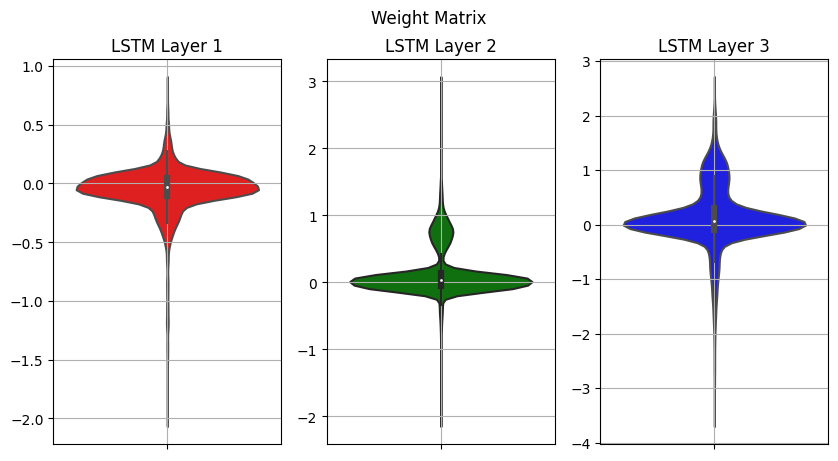

In [161]:
#retrieving the weights of the LSTM layers from the best model
first_layer_weights = best_model.layers[0].get_weights()[0]
second_layer_weights = best_model.layers[2].get_weights()[0]  #skipping the first dropout layer
third_layer_weights = best_model.layers[4].get_weights()[0]  #skipping the second droput layer
dense_layer = best_model.layers[6].get_weights()[0]
#printing the shapes
print("LSTM Layer 1 Weight Matrix Shape")
print("=" * 50)
print(first_layer_weights.shape)
print("LSTM Layer 2 Weight Matrix Shape")
print("=" * 50)
print(second_layer_weights.shape)
print("LSTM Layer 3 Weight Matrix Shape")
print("=" * 50)
print(third_layer_weights.shape)

#plotting the weight distribution using violin plots
fig = plt.figure(1,figsize=(10,5))
fig.suptitle("Weight Matrix")
plt.subplot(1, 3, 1)
plt.title("LSTM Layer 1")
sns.violinplot(y = first_layer_weights, color = "red")
plt.grid()

plt.subplot(1,3,2)
plt.title("LSTM Layer 2")
sns.violinplot(y = second_layer_weights, color = "green")
plt.grid()

plt.subplot(1,3,3)
plt.title("LSTM Layer 3")
sns.violinplot(y = third_layer_weights, color = "blue")
plt.savefig("weight_matrix")
plt.grid()

#reference: (Vetrivel, 2019)

From the violin plot we can see that the first layer has a symmetrical shape, indicating that the learning process was balanced throughout the model training. The second layer has a positive prolonged tail which suggests that there was a greater variation from the central tendency compared to the negative tail. Layer three also shows a similar prolonged variation on the positive side compared to the negative. An approximately normal distribution was exhibited in all three layers. 

This visualisation was combined with model evaluation to conclude whether the weight selected was appropriate for the model.

**LSTM after Hyperparameter Tuning and Visualising the Weight Distribution**

In [143]:
#evaluating the lstm network

def lstm_evaluation(training_dataset, testing_dataset):
    
    #splitting the training dataset to independent variables and target variable
    X = training_dataset.drop(columns = ["RUL", "Unit_ID"])
    y = training_dataset["RUL"]
    
    #normalising the distribution using MinMax scaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    #reshaping the data for LSTM layers (2D array to 3D array)
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1])) #[samples (rows), timesteps, features(columns)]
    
    n = 5  #number of splits for cross-validation
    
    kf = KFold(n_splits = n, shuffle = True, random_state = 42) #initialising the kfold cross validation

    #storing RMSE values for each fold
    training_rmses = []
    validation_rmses = []

    #iterating through each fold in cross validation
    for train_index, validation_index in kf.split(X_reshaped):

        #splitting the data into training and validation sets for the current fold
        X_train, X_validation = X_reshaped[train_index], X_reshaped[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
        
        #initialising the sequential LSTM model(three layers- each layer has one input tensor and one output tensor)
        model = Sequential()      
        
        #first LSTM layer with 100 neurons (LSTM will output a sequence with 100 values for each input timestep)
        #activation_function(relu - rectified linear unit) outputs the input directly if positive, else outputs zero. introduces non-linearity, and allow model to learn intricate relationships 
        model.add(LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True, activation = 'relu')) #input_shape takes two values(timesteps, number of columns per timestep)
        model.add(Dropout(0.2)) #regularisation to reduce overfitting (dropping 20% of input units to zero at each update)

        #followed by second LSTM layer with 50 neurons
        model.add(LSTM(50, return_sequences = True, activation = "relu")) #(return_sequence indicates to return the full sequence to the next layer)
        model.add(Dropout(0.2)) #regularisation to reduce overfitting

        #followed by third LSTM layer with 25 neurons
        model.add(LSTM(25, return_sequences = False, activation = "relu")) #return output of the last timestep(no more LSTM layers, no need of returning full sequence)
        model.add(Dropout(0.2)) #regularisation to reduce overfitting

        #fully connected layers(each neuron will recieve input from every neuron of the previous layer)
        model.add(Dense(10, activation = "relu")) #(relu trains network faster without significant penalty)
        model.add(Dense(1)) #final output dense layer 

        #compiling the model
        #optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate = 0.001)
        model.compile(optimizer = "adam", loss ="mse") # (adam's adaptive nature and efficiency can help in navigating the loss surface, and converging to a good solution) 
        
        #earlyStopping callback for better convergence(if the validation loss did not improve for 10 epochs, stop training)
        early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True) #(restore_best_weights- ensures weights are rolled back where loss is minimum)
        
        #fitting the model
        model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data = (X_validation, y_validation), verbose = 0, shuffle = False, callbacks=[early_stopping]) #early stopping callback made

        #predicting the target variable RUL for the training set and calculating rmse for evaluation
        training_predictions = model.predict(X_train)
        training_rmse = mean_squared_error(y_train, training_predictions, squared = False)
        training_rmses.append(training_rmse)

        #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
        validation_predictions = model.predict(X_validation)
        validation_rmse = mean_squared_error(y_validation, validation_predictions, squared = False)
        validation_rmses.append(validation_rmse)

    #calculating the average RMSE over all the fold
    average_training_rmse = sum(training_rmses) / n
    average_validation_rmse = sum(validation_rmses) / n

    #preparing the testing dataset to independent variables and target variable
    X_test = testing_dataset.drop(columns = ["RUL", "Unit_ID"])
    y_test = testing_dataset["RUL"]

    #normalising and reshaping the testing data for LSTM layers
    X_test_scaled = scaler.transform(X_test)
    X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    #predicting the target variable RUL for the validation dataset and calculating rmse for evaluation
    testing_predictions = model.predict(X_test_reshaped).flatten() #ensure prediction is 1D array
    testing_rmse = mean_squared_error(y_test, testing_predictions, squared = False)

    #plotting actual RUL with predicted RUL values(training dataset)
    #plot_predicted_vs_actual(y_test, testing_predictions)

    return average_training_rmse, average_validation_rmse, testing_rmse

start_time = time.time() #start time tracking

#Evaluating the performance of LSTM model through RMSE values
lstm_train_rmse, lstm_val_rmse, lstm_test_rmse = lstm_evaluation(pred_train_dataset, pred_test_dataset)

end_time = time.time() #stop time tracking
lstm_duration = end_time - start_time #calculating duration

print(f"Training RMSE: {lstm_train_rmse}, Validation RMSE: {lstm_val_rmse}, Test RMSE: {lstm_test_rmse}")

#reference: (Brownlee, 2016)
#reference: (MRK, 2020)
#referene: (Faroit, 2023)
#reference: (Chollet, 2023)

410/410 [==============================] - 1s 2ms/step
Training RMSE: 38.09192472763629, Validation RMSE: 38.25747737476011, Test RMSE: 40.8814476836009


The LSTM model demonstrates a good result on training, validation, and testing phases. There were no significant overfitting. For all the 5 iterations, there were two steps displayed, i) training(516 steps) and ii) validation(129 steps). The model performance of testing dataset is evaluated in 410 steps. 

While being a powerful computational model, LSTM did not outperform the other ensemble model like bagged random forest tree and xGBoost. This shows the importance of choosing the right model based on characteristics of dataset rather than assuming a complex model can capture underlying pattern and yeild good results. 

**Comparative analysis of machine learning techniques for predictive maintenance**

Several machine learning models were developed in order to determine the one with the best predictive ability for the dataset. The dataframe below, presents the Root Mean Square Error (RMSE) for each of the models, for each of the training, validation and testing stages. RMSE was chosen as the evaluation method as it gives more importance to large errors, rather than small errors. This allows us to clearly observe the significant differences between the predicted values and the actual values. Where the RMSE is low, this suggests that the model fits the data better and will have greater predictive ability. 

In [148]:
#creating a dictionary to store all the RMSE values of each model

evaluation_results = {
    "Machine Learning Technique": ["Linear Regression", "Random Forest Regressor", "Bagged Random Forest Regressor", "Extreme Gradient Boosting (xGBoost)", "Support Vector Regressor", "Long Short-term Memory Network"],
    "Training RMSE": [lin_train_rmse, rfr_train_rmse, bag_rfr_train_rmse, xgb_train_rmse, svr_train_rmse, lstm_train_rmse],
    "Validation RMSE": [lin_val_rmse, rfr_val_rmse, bag_rfr_val_rmse, xgb_val_rmse, svr_val_rmse, lstm_val_rmse],
    "Testing RMSE": [lin_test_rmse, rfr_test_rmse, bag_rfr_test_rmse, xgb_test_rmse, svr_test_rmse, lstm_test_rmse],
    "Duration (seconds)": [lin_reg_duration, rfr_duration, bag_rfr_duration, xgb_duration, svr_duration, lstm_duration]
}

#converting the dictionary to dataframe
evaluation_results_df = pd.DataFrame(evaluation_results)

evaluation_results_df

,Machine Learning Technique,Training RMSE,Validation RMSE,Testing RMSE,Duration (seconds)
0,Linear Regression,40.615700,39.714180,42.922247,1.364327
1,Random Forest Regressor,36.312078,37.067167,41.385559,11.551592
2,Bagged Random Forest Regressor,35.879685,36.477564,40.782320,362.412356
3,Extreme Gradient Boosting (xGBoost),34.583414,35.957814,40.476655,3.375462
4,Support Vector Regressor,36.478667,36.833195,41.489920,323.478834
5,Long Short-term Memory Network,38.091925,38.257477,40.881448,387.955259


The dataframe shows that the training RMSE values for all the above models range between 35.3 and 40.6. This suggests that all these models fit the training data relatively well. However, there are subtle differences in fit between the models. The validation RMSE relates to how well the model generalises to the unseen dataset. 

From the dataframe, it can be seen that these values range between 36.2 and 39.7, suggesting marginal differences between the models. The testing RMSE is most important as it helps to understand how well a model can perform in the real world. The above table shows that these results range between 40.7 and 42.9 for all the models. This means that although there are differences in data processing within each model, all models have similar results. 

Apart from the RMSE values, there are other practicality factors that must be considered before a model is selected to be deployed in the real world. For example, the computational cost of deploying the model and the interpretability of the results of the model. The duration column provides important information regarding the computational efficiency of the models. 

According to the results in dataframe above, the xGBoost machine learning algorithm showed the best predictive performance out of all of the studied models. The model had the lowest testing RMSE values, and shorter execution time. Thus the xGBoost algorithm due to its accuracy and efficiency becomes the ideal choice for deployment.

**Enhanced time-series analysis:**

The predictive time series data is enriched with intricate patterns and frequencies, and these significant patterns provide crucial insights in making accurate predictions. It might be difficult to extract these patterns due to noise.

Therefore, conidering Fourier Transform can be useful. Fourier Transform decomposes time-domain signals into its respective frequencies. By using fourier transform, we can identify the significant frequencies, and capture underlying core patterns in our data (Korstanje, 2021).

Engines exhibit certain vibrations and patterns due to the aging and continous wear. By focusing on these pattern and eliminating the irrelevant noise, we can enhance our model predictions (Rybnik, 2022).

**Peak-based signal reconstruction**

In [66]:
#reconstructing the signal using significant frequencies from fast fourier transform

def peak_signal_reconstruction(training_dataset, testing_dataset):

    def signal_reconstruction(dataset):
        
            #converting the dataset to numpy array
            dataset = np.array(dataset)
        
            #calulating fourier transform values
            fourier = fft(dataset) #transforming time-domain signal to spectrum of frequencies
        
            #calculating the magnitude of frequency spectrum
            magnitude_spectrum = abs(fourier) 
            
            #For real-valued signals, we only require first half of the spectrum, the second half of the spectrum is the complex conjugate(negative mirror image) of the first half(symmetrical)
            first_half_magnitude_spectrum = magnitude_spectrum[:int(len(dataset) / 2)] #slicing the array to get all values from the start to the center
            
            #calculating the peak in first half of magnitude spectrum 
            peaks = find_peaks(first_half_magnitude_spectrum, distance = 1)[0] #we only need indices(location) of frequencies, other properties can be ignored, find peaks that are separated by at least 5 data points
        
            #converting the fourier values to a dataframe
            fourier_df = pd.DataFrame({"fourier_transformed_values": fourier})
        
            #initialising a new column with zeros
            fourier_df["significant_fourier_values"] = 0
        
            #assigning the peak indices values to significant_fourier_values column 
            fourier_df.loc[peaks, "significant_fourier_values"] = fourier_df.loc[peaks, "fourier_transformed_values"]
        
            #introducing the corresponding negative frequency components
            negative_freq_peaks = len(fourier) - 1 - peaks
            
            #setting the values in the significant_fourier_values column for the negative frequency peaks
            fourier_df.loc[negative_freq_peaks, "significant_fourier_values"] = np.conj(fourier_df.loc[peaks, "fourier_transformed_values"]).values  #np.conj calculate the complex conjugate to ensure fourier transform retain symmetry for real valued signals(negative frequency components)
            
            #reconstructing the signal using inverse fourier transform
            reconstructed_signal = ifft(fourier_df["significant_fourier_values"].values).real #(taking only real part of complex number(discarding imaginary part)
            
            return reconstructed_signal

    #list of non sensor values to be excluded from the signal reconstruction process
    non_sensor_values = ["Unit_ID", "Time_in_Cycles", "Setting_1", "Setting_2", "RUL"]

    #reconstructing the sensor reading in the training dataset
    reconstructed_training_dataset = training_dataset.copy()
    for column in training_dataset.columns:
        if column not in non_sensor_values:
            reconstructed_training_dataset["peak_recon_" + column] = signal_reconstruction(training_dataset[column])
    
    #reconstructing the sensor reading in the testing dataset
    reconstructed_testing_dataset = testing_dataset.copy()
    for column in testing_dataset.columns:
        if column not in non_sensor_values:
            reconstructed_testing_dataset["peak_recon_" + column] = signal_reconstruction(testing_dataset[column])

    return reconstructed_training_dataset, reconstructed_testing_dataset

#creating the reconstructed training and testing dataset using peak signal reconstruction
reconstructed_training_dataset, reconstructed_testing_dataset = peak_signal_reconstruction(pred_train_dataset, pred_test_dataset)
        
#reference: (Alkousa, 2023)
#reference: (SciPy, 2023)
#reference: (Bibi, 2022)
#reference: (MacLeod, 2020)
#reference: (MathWorks, 2023)‌

In this analysis, Fourier tranform will be applied to the predictive dataset to transform the sensor reading(time-series data) into its constituent frequency domain(sinusoids).  This could help in extracting the important frequencies that predominantly determine the characteristics of our signal. By capturing these significant patterns, we could reconstruct the sensor values with reduced noise and clarity. By utilising this approach, we are redefining our dataset, giving importance to most informative patterns, reducing noise, and thus enhancing predictive capability.

The FTT transformed the sensor values(time-series data) into a spectrum of frequencies. In this transformed spectrum of frequencies, the magnitude at each frequency indicates the significance or amplitude of that frequency in the original signal (Kutz, 2018). 

The magnitude spectrum provides the magnitude(strength) of each frequency component. It will provide information on how much of each frequency is present in the original signal. The output of Fourier Transform is symmetric around midpoints due to the real values. This means the second half of the spectrum is just a mirror image(complex conjugate) of the first half with negative frequencies. This can be discarded, as the first half of magnitude spectrum captures all the necessary information (Jackson, 2021). 

Peak is a point in magnitude spectrum where the magnitude or amplitude is highest. We only needed these significant frequencies in the original signal, as they carry more important imformation (Kutz, 2018). The distance parameter was used to ensure that these peaks are seperated by a specific number of data points, avoiding repeated or too closely spaced peaks. 

With the help of significant frequencies, we aim to create a new fourier transformed data. The data frame will be initialsed with zeros, and then we retain the signifcant frequencies (peaks). Maintaining the symmetry is also important, therefore the complex conjugates (negative frequencies) are considered. 

The Inverse Fourier Transform is applied to the fourier transformed data, creating a new reconstructed time-series dataset (sensor values).  This retains the underlying patterns of the original sensor values, but with less noise.

The signal reconstruction is integrated with the training and testing dataset. We are neglecting the non-sensor values such as "Time_in_Cycles", "Setting 1 and 2", "Unit_ID" and "RUL". Apart from these values, all the senor readings undergo the new reconstructing signal process. The reconstructed signals(sensor values) are then appended to the training and testing dataset.

***Visualising peak frequencies in the sensor data***

The collected sensor data consists of different frequencies from various patterns and noise. Transforming this data into frequency domain can provide a clear view on the underlying patterns in the data. 

Visualising these peaks can gain insights into the frequencies that most influence the sensor data. They provide the characteristics of time-series signals. When observing the magnitude spectrum, a signal with significant high peak might indicate noise, and such frequencies can be considered for filtering to refine signal quality.

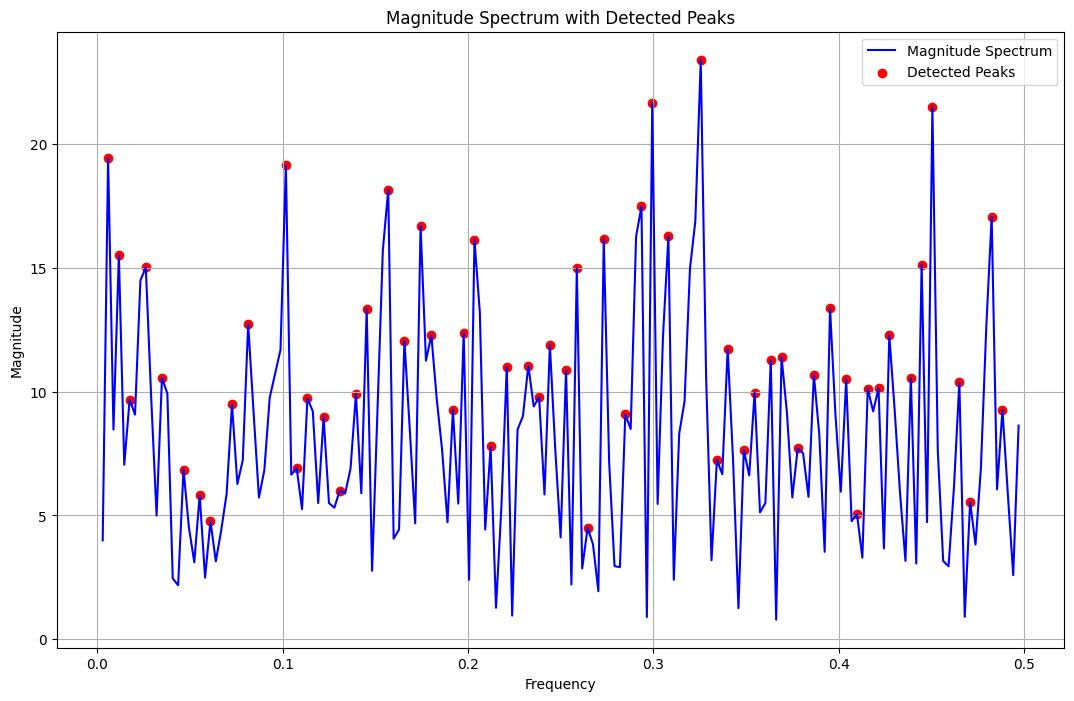

In [141]:
#visualising peak frequencies in sensor data

def plot_magnitude_spectrum_with_peaks(sensor_data, sampling_rate):

    #extracting a subset of the respective sensor data
    sampled_data = sensor_data[::sampling_rate] #select every nth point in dataset
    
    #calculating the fourier transform for the sampled sensor data
    fourier = fft(sampled_data)

    #computing the magnitude spectrum (aboslute values)
    magnitude_spectrum = abs(fourier) #(provides the contribution of each frequency to the overall signal)
    
    #calculating the frequency of each component 
    frequency = fftfreq(len(sampled_data))
    
    #we are only considering the positive frequency components for plotting(filter negetive frequency)
    positive_frequency = frequency > 0
    magnitude_spectrum = magnitude_spectrum[positive_frequency]
    frequency = frequency[positive_frequency]
    
    #calculating the peak in magnitude spectrum 
    peaks = find_peaks(magnitude_spectrum, distance = 1)[0]
    
    plt.figure(figsize = (13, 8))
    plt.plot(frequency, magnitude_spectrum, label = "Magnitude Spectrum", color = "blue")
    plt.scatter(frequency[peaks], magnitude_spectrum[peaks], color = "red", label = "Detected Peaks")
    
    plt.title("Magnitude Spectrum with Detected Peaks")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True)
    plt.savefig("spectrum_peaks")
    plt.show()

#extracting the senor values of "T24", and visualising the magnitude along with the detected peak
sensor_data = pred_train_dataset['T24'].values
plot_magnitude_spectrum_with_peaks(sensor_data, 60) #(select every 60th point)

#reference: (Kutz, 2018)
#reference: (GeeksForGeeks, 2023)‌

The detected peaks in the magnitude spectrum can be viewed as the dominant frequency in the sensor data. From the plot, it is evident that the function has captured the significant peaks in the data. This plot helps in understanding the patterns in the time series signal. A signal with significant high peak might indicate noise. The identification of reccuring patterns and anomalies, can be very helpful in building a better predictive model.

**Analysing our reconstructed dataset:**

In [68]:
reconstructed_training_dataset.head(3)

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,peak_recon_T24,peak_recon_T30,peak_recon_T50,peak_recon_P30,peak_recon_Nf,peak_recon_Nc,peak_recon_Ps30,peak_recon_phi,peak_recon_NRf,peak_recon_NRc,peak_recon_BPR,peak_recon_htBleed,peak_recon_W31,peak_recon_W32
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,-0.722956,-2.990218,-2.393171,0.723549,-0.086485,-5.077896,0.019769,0.070502,-0.098252,4.531014,-0.016917,-1.671831,0.202043,0.069736
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,-0.764303,-2.634817,-4.055615,0.387323,-0.058889,-2.854161,0.041165,0.283638,-0.038489,5.125495,-0.003337,-0.734313,0.089803,0.058365
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,-0.583097,2.030972,-4.951337,0.715253,-0.070194,3.028087,-0.155373,0.524724,-0.099954,4.492974,-0.034984,-1.240360,0.092292,0.041125


While comparing the original sensor values with reconstructed values, a significant data loss is observed. This is due to the fact that, we only retained the Fourier components corresponding to the peak values (high magnitude or amplitude). This means that some of the data are indeed discarded, and the esssential and significant patterns are captured. This approach acts as a form of dimensionality reduction, still preserving the important aspects of the data. 

Having these resconstructed data points, we can evaluate the performance with our choosen model(xGBoost Regressor). This will provide us insights on how effective these key patterns can be bring into the predictive accuracy. 

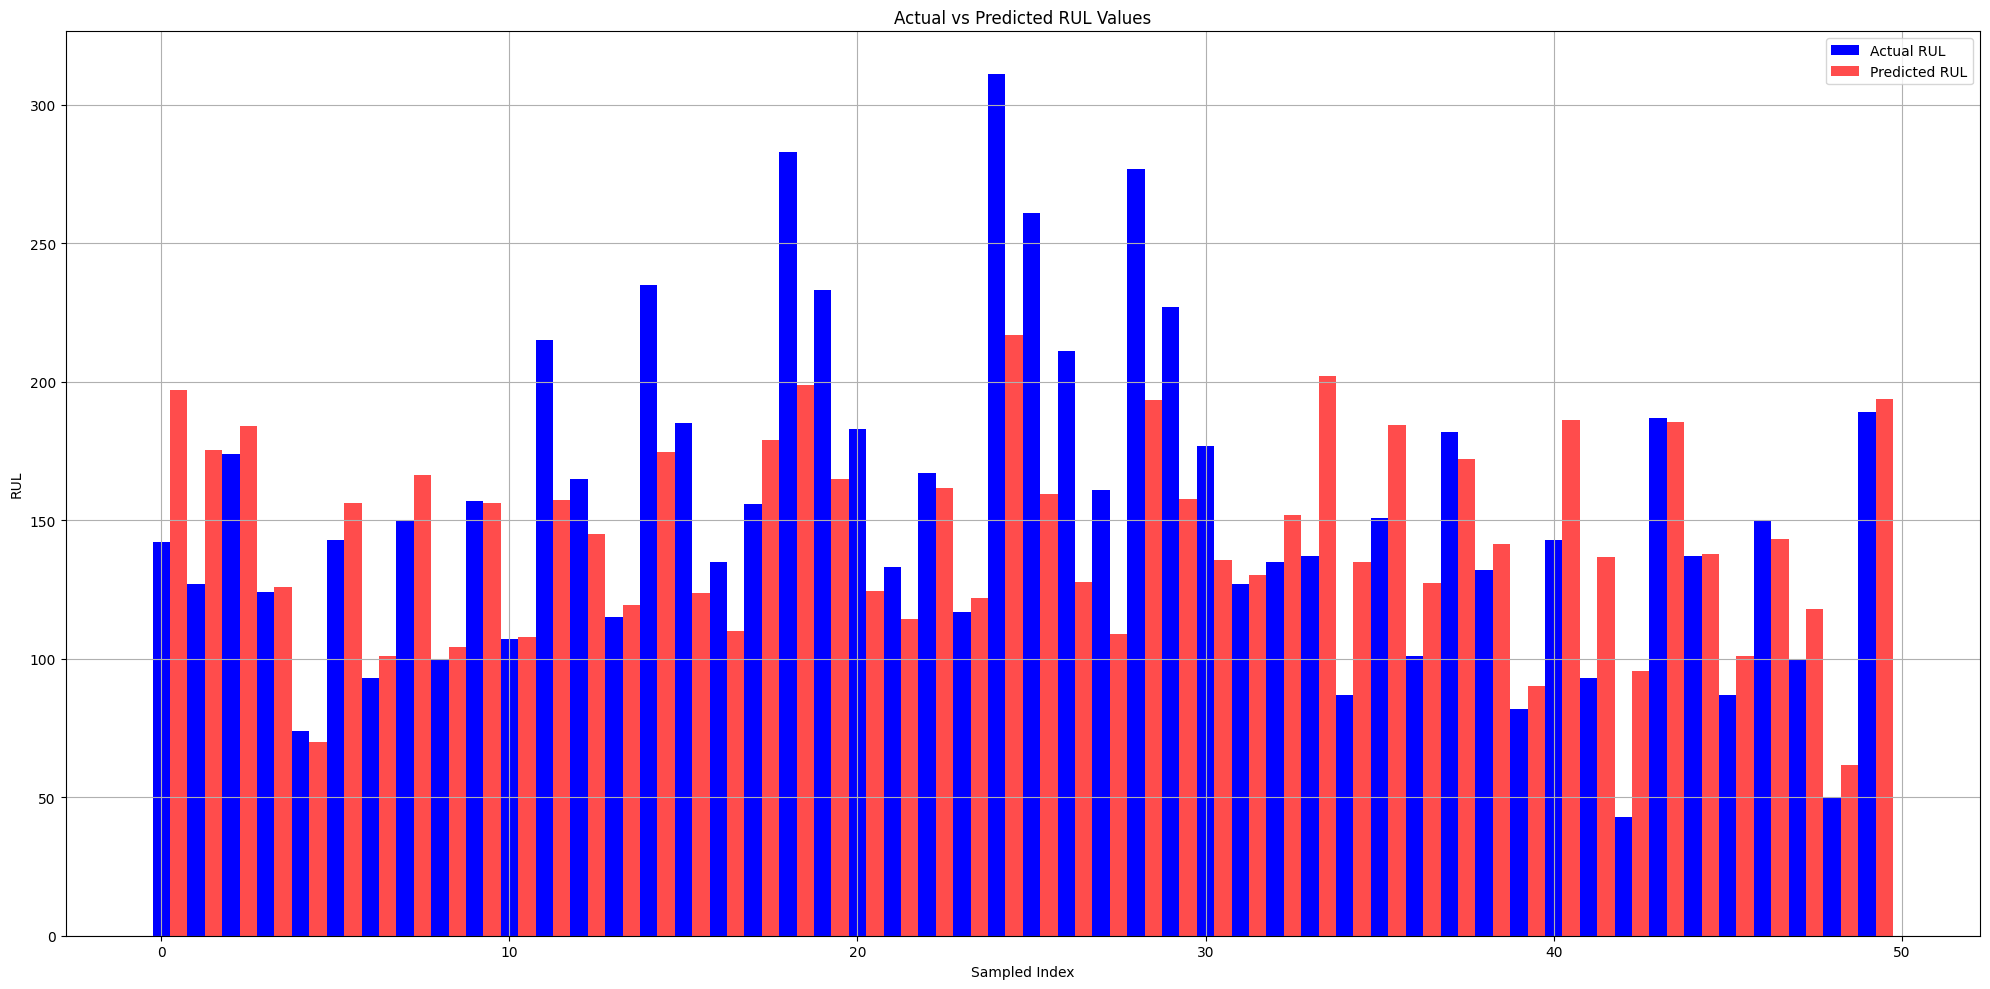

,Dataset,Training RMSE,Validation RMSE,Testing RMSE
0,Original Dataset,34.583414,35.957814,40.476655
1,Reconstructed Dataset,32.854734,34.622837,40.765335


In [163]:
#evaluating the original dataset
#train_rmse_1, val_rmse_1, test_rmse_1 = xgb_final_evaluation(pred_train_dataset, pred_test_dataset)

#evaluating the reconstructed dataset
reconstructed_train_rmse, reconstructed_val_rmse, reconstructed_test_rmse = xgb_final_evaluation(reconstructed_training_dataset, reconstructed_testing_dataset)

results = pd.DataFrame({"Dataset": ["Original Dataset", "Reconstructed Dataset"], "Training RMSE": [xgb_train_rmse, reconstructed_train_rmse], "Validation RMSE": [xgb_val_rmse, reconstructed_val_rmse], "Testing RMSE": [xgb_test_rmse, reconstructed_test_rmse]})
results

RMSE values of the reconstructed dataset are close to the RMSE values of the original dataset. The testing RMSE is marginally higher in the reconstructed dataset than in the original dataset. Despite capturing intricate patterns by creating a reconstructed signal based on significant peak values(high magnitude or amplitute), it still was not sufficient to obtain better predictive accuracy.

Using the peaks from the frequency domain, it might capture dominant frequencies, but it completely neglects the importance of minor frequencies. This is evident from both of the testing RMSE's. Adding the prominence and height, and tuning the distance can make the reconstruction slightly better, but not enough to capture the underlying pattern.

A better balance between data reduction and information preservation is very important, and thus other methods to reconstruct the signals with top frequencies should be explored.

**Principal signal reconstruction with dominant frequencies**

The key difference between this method and Peak Based signal reconstruction is that we are considering frequencies based on their magnitude rather than peak (high frequencies). This ensures the primary characteristics of the sensor values are preserved, and still capture the principal (dominant) frequencies (Kutz, 2018). 

This approach is similar to the "peak_signal_reconstruction" function, but instead of focusing on the peaks (high magnitude or amplitude) of frequency spectrum, we are focussing on the principal (dominant) frequencies. By this method, we are preserving the characteristics of sensor values without any data loss, while still capturing the underlying patterns.

In [70]:
#reconstructing the signal using principal frequencies from fourier transform

def principal_signal_reconstruction(training_dataset, testing_dataset):

    def signal_reconstruction(dataset):
        
        #converting the dataset to numpy array
        dataset = np.array(dataset) 
        
        #calulating fourier transform values                   
        fourier = fft(dataset) #transforming time-domain signal to spectrum of frequencies
        
        #calculating the magnitude of frequency spectrum                  
        magnitude_spectrum = np.abs(fourier) #(provides the contribution of each frequency to the overall signal)
    
        #defining the percentage of frequencies to retain
        principal_percentage = 30
    
        #calculating the number of frequencies to retain based on the principal_percentage
        top_frequency_count = int(len(dataset) * principal_percentage / 100)
    
        #sorting the magnitude spectrum to find indices of the principal(dominant) frequencies (ordered largest to smallest)
        principal_indices = magnitude_spectrum.argsort()[-top_frequency_count:][::-1] #(capturing the dominant characteristics of the original signal) (- top_frequency_count = indice of largest principal value)
    
        #converting the fourier values to a dataframe
        fourier_df = pd.DataFrame({"fourier_transformed_values": fourier})
    
        #initialising a new column with zeros
        fourier_df["significant_fourier_values"] = 0
    
        #assigning the principal frequency indices values to significant_fourier_values column 
        fourier_df.loc[principal_indices, "significant_fourier_values"] = fourier_df.loc[principal_indices, "fourier_transformed_values"]
        
        #reconstructing the signal using inverse fourier transform
        reconstructed_signal = ifft(fourier_df["significant_fourier_values"].values).real #(taking only real part of complex number(discarding imaginary part)
        
        return reconstructed_signal

    #list of non sensor values to be excluded from the signal reconstruction process
    non_sensor_values = ["Unit_ID", "Time_in_Cycles", "Setting_1", "Setting_2", "RUL"]

    #reconstructing the sensor reading in the training dataset
    reconstructed_training_dataset = training_dataset.copy()
    for column in training_dataset.columns:
        if column not in non_sensor_values:
            reconstructed_training_dataset["principal_recon_" + column] = signal_reconstruction(training_dataset[column])

    #reconstructing the sensor reading in the testing dataset
    reconstructed_testing_dataset = testing_dataset.copy()
    for column in testing_dataset.columns:
        if column not in non_sensor_values:
            reconstructed_testing_dataset["principal_recon_" + column] = signal_reconstruction(testing_dataset[column])

    return reconstructed_training_dataset, reconstructed_testing_dataset

#creating the reconstructed training and testing dataset using principal signal reconstruction
reconstructed_train_dataset, reconstructed_test_dataset = principal_signal_reconstruction(pred_train_dataset, pred_test_dataset)

#reference: (DataQ Instruments, 2023)
‌#reference: (Scipy, 2023)

Similar to the peak based approach, we transform the sensor values into a spectrum of frequencies which shows the principal frequencies in the signals. We will proceed with calculating the magnitude spectrum to understand the contribution of each frequency to the overall signal. Instead of peaks, we determine the number of frequencies to be retained using the principal_percentage. 

With the indices(locations) of principal freequencies, we will reconstruct the transformed dataset. Finally we will convert the frequency domain back to sensor values (time series data) by applying inverse fourier transform to the fourier transformed data.

The sensor values undergo principal signal reconstruction, and then get appended to the training and testing dataset.

**Visualizing Principal Frequencies in the Sensor Data**

We will visualise the principal frequencies along with the magnitude spectrum. These principal frequencies represent the dominant underlying patterns in the signal. These frequencies help in retaining the characteristics of the original signal values without data loss(unlike peaks), and still enhance predictive capability.

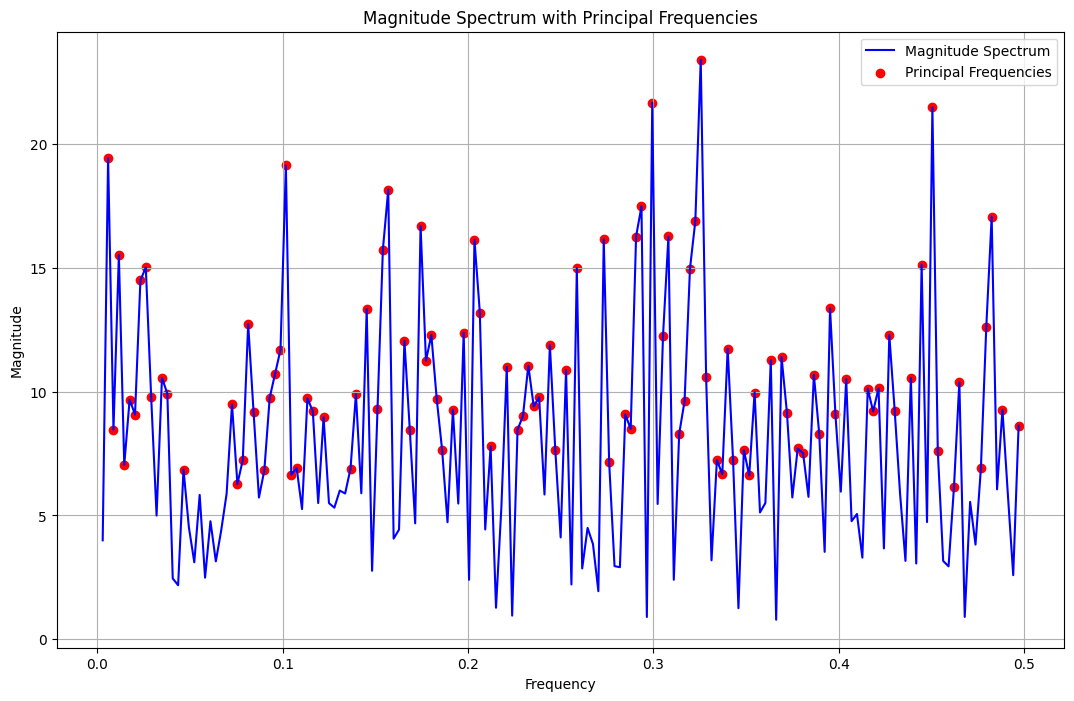

In [140]:
#visualising principal frequencies in sensor data

def plot_principal_frequencies(sensor_data, sampling_rate):

    #extracting a subset of the respective sensor data
    sampled_data = sensor_data[::sampling_rate] #select every nth point in dataset
    
    #calculating the fourier transform for the sampled sensor data
    fourier = fft(sampled_data)

    #computing the magnitude spectrum (absolute values)
    magnitude_spectrum = abs(fourier)
    
    #calculating the frequency of each component 
    frequency = fftfreq(len(sampled_data))
    
    #we are only considering the positive frequency components for plotting(filter negative frequency)
    positive_frequency = frequency > 0
    magnitude_spectrum = magnitude_spectrum[positive_frequency]
    frequency = frequency[positive_frequency]
    
    #determining the principal frequencies
    principal_percentage = 30
    top_frequency_count = int(len(sampled_data) * principal_percentage / 100)
    principal_indices = magnitude_spectrum.argsort()[-top_frequency_count:][::-1]
    
    plt.figure(figsize = (13, 8))
    plt.plot(frequency, magnitude_spectrum, label = "Magnitude Spectrum", color = "blue")
    plt.scatter(frequency[principal_indices], magnitude_spectrum[principal_indices], color = "red", label = "Principal Frequencies")
    
    plt.title("Magnitude Spectrum with Principal Frequencies")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True)
    plt.savefig("spectrum_principal")
    plt.show()

#extracting the sensor values of "T24", and visualising the magnitude along with the detected principal frequencies
sensor_data = pred_train_dataset["T24"].values
plot_principal_frequencies(sensor_data, 60)

#reference: (Kutz, 2018)
#reference: (GeeksForGeeks, 2023)

Visualising the principal frequencies provides a better representation of the dataset. Unlike peak freqeuncy method that only selects isolated top frequency, this principal frequency method capture continous spectrum of principal (dominant) frequencies. This ensures that no significant pattern is missed out. Instead of emphasising on high peaks, this method captures the overalll shape and characteristics. 

**Analysing our reconstructed dataset:**

In [72]:
reconstructed_train_dataset.head(3)

,Unit_ID,Time_in_Cycles,Setting_1,Setting_2,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,principal_recon_T24,principal_recon_T30,principal_recon_T50,principal_recon_P30,principal_recon_Nf,principal_recon_Nc,principal_recon_Ps30,principal_recon_phi,principal_recon_NRf,principal_recon_NRc,principal_recon_BPR,principal_recon_htBleed,principal_recon_W31,principal_recon_W32
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,642.077569,1590.419630,1407.863795,553.584990,2388.101717,9048.651116,47.656146,521.366088,2388.073620,8136.482967,8.437501,392.461831,38.911633,23.308109
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,642.014041,1589.327665,1405.028732,553.201168,2388.083969,9044.972558,47.533018,522.030685,2388.091736,8134.072495,8.436030,392.404601,38.957832,23.394255
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,642.387495,1593.177934,1401.880241,554.082359,2388.091965,9054.007860,47.295080,522.247084,2388.040190,8134.028355,8.410982,390.981918,38.878062,23.362808


The reconstructed signal values are very close to the respective sensor values. This shows that the principal frequencies captured the characteristics of data, and retained significant patterns without any data loss. By focussing on the principal frequency, it is noted that a new signal was reconstructed that mirrors the original sensor values, with a possible reduction in noise. 

With the constructed dataset, we can evaluate the performance with our choosen xGBoost regressor, and check whether this approach has enhanced predictive accuracy.

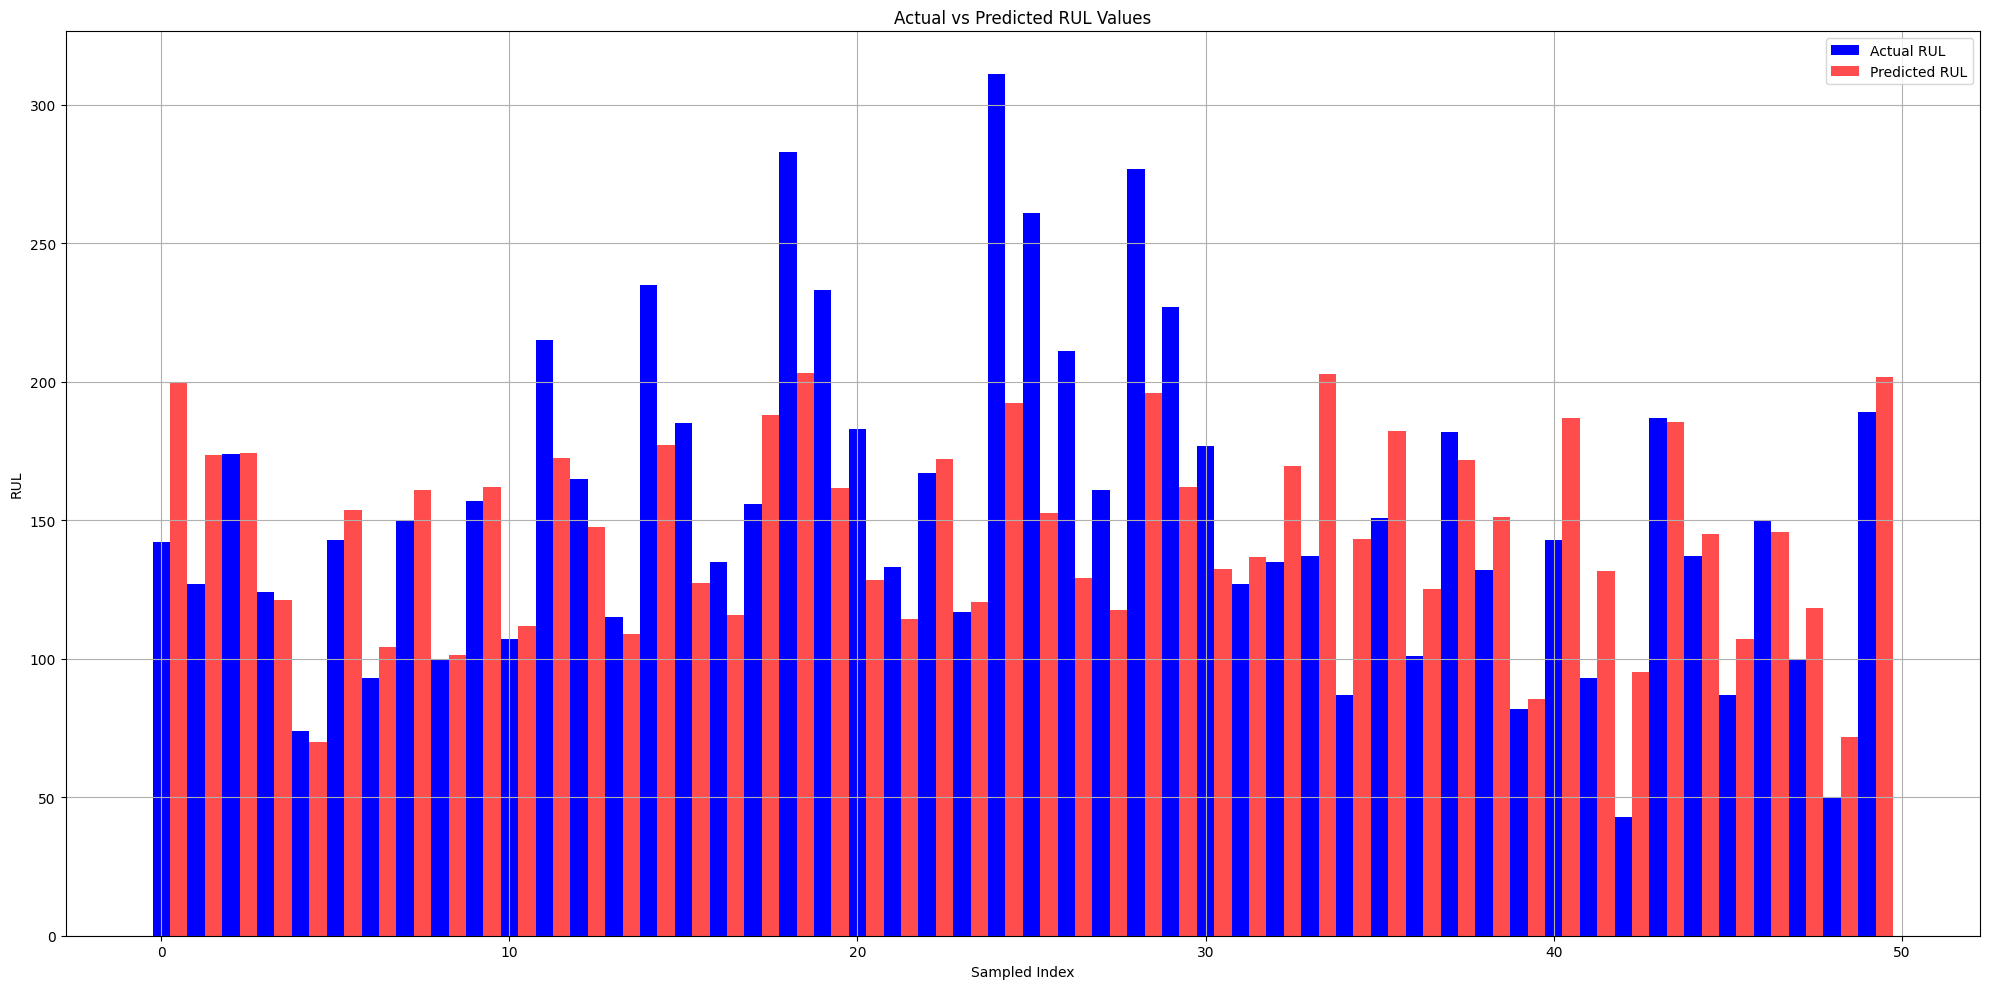

,Dataset,Training RMSE,Validation RMSE,Testing RMSE
0,Original Dataset,34.583414,35.957814,40.476655
1,Reconstructed Dataset,34.124786,35.688727,40.581948


In [112]:
#evaluating the reconstructed dataset
reconstructed_train_rmse, reconstructed_val_rmse, reconstructed_test_rmse = xgb_final_evaluation(reconstructed_train_dataset, reconstructed_test_dataset)

results = pd.DataFrame({"Dataset": ["Original Dataset", "Reconstructed Dataset"], "Training RMSE": [xgb_train_rmse, reconstructed_train_rmse], "Validation RMSE": [xgb_val_rmse, reconstructed_val_rmse], "Testing RMSE": [xgb_test_rmse, reconstructed_test_rmse]})
results

From the results, it is observed that the reconstructed dataset provides a slightly better RMSE values compared to the original dataset. The principal signal reconstruction has managed to retain the underlying patterns, without introducing significant noise and data loss.

**Comparative benefits of peak and principal signal reconstruction**

High volume of data is generated by sensors every second. These data needs to be analysed, and processed efficiently. These peak and principal signal reconstructions can emerge as an important tool to enhance data quality and model performance.

Peak Signal reconstruction can drastically reduce the dimensionality of the of the dataset, and making it computationally efficient. The principal signal reconstruction can provide more flexibility on dimensionality reduction by retaing the most significant frequencies. Similarly, this method offers flexibility to adjust the amount of frequency that is retained during the reconstruction.

Both methods preserve the underlying patterns in the data, as the reconstructed signals mirror the original dataset characteristics. The simplified data can speed up real-time analytics (process vast streams of data).

These methods can act directly as noise filters, enhancing the data quality. They provide an scalable approach that even when data grows, the processing mechanism can easily handle large volumes of data.

Even a minor improvement observed in RMSE values can have a strong implication on real world scenarios, especially considering the nature of aviation industry. This can lead to better maintenance prediction, reduced downtime, and increased safety.

**RUL optimisation for better predictive capability**

When analysing the RUL, the main objective is to ensure that the prediction accuracy is higher at lower RUL values. This indicates that an engine is close to failure and is more likely to require maintenance than an engine with a higher RUL. 

A histogram is plotted below to observe the distribution of the RUL and determine an appropriate threshold. 

The high RUL values in the data were clipped in order to prevent the model from being skewed by these values, resulting in the model having a higher predictive accuracy. 

Capping the RUL distribution at a specific threshold ensures that the predictive model gives more importance to the low RUL values. These are the circumstances where failure is most likely to occur. This will also ensure that less importance is given to engines with high RULs, as this could lead to unnecessary maintenance. 

In practice, this would allow maintenance to be scheduled when required, without overestimating the need for maintenance in newer engines that still have high RULs.

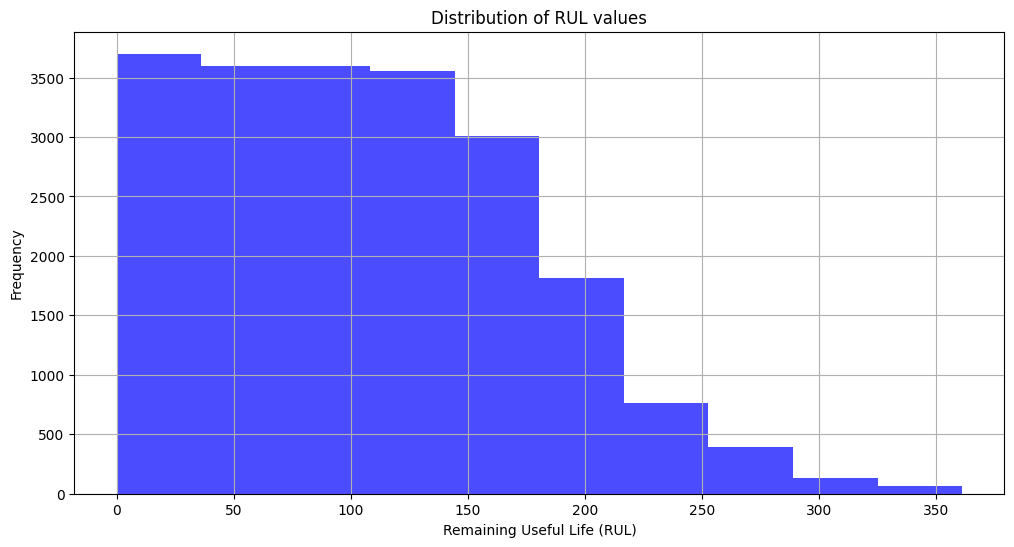

In [99]:
#plotting a histogram of the RUL values
plt.figure(figsize=(12, 6))
plt.hist(pred_train_dataset["RUL"], color = "blue", alpha = 0.7)
plt.title("Distribution of RUL values")
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("RUL_histogram")
plt.show()

From the plot, we are considering the RUL threshold as approximately 150, as the RUL frequency drops for RULs higher than 150.

In [75]:
#RUL clipping (any RUL values above the threshold will be set to threshold value)

def clip_RUL(dataset):
    threshold = 150 #initialising the upper limit for RUL values
    clipped_dataset = dataset.copy()
    clipped_dataset["RUL"] = dataset["RUL"].clip(upper=threshold) #(limit the higher RUL value to threshold value)
    return clipped_dataset

#applying RUL clipping to the reconstructed training and testing dataset
reconstructed_train_dataset_clipped = clip_RUL(reconstructed_train_dataset)
reconstructed_test_dataset_clipped = clip_RUL(reconstructed_test_dataset)

#applying RUL clipping to the training and testing dataset
pred_train_dataset_clipped = clip_RUL(pred_train_dataset)
pred_test_dataset_clipped = clip_RUL(pred_test_dataset)

Extremely high RUL values can act as outliers, potentially skewing our model prediction. This clipping technique standardises the RUL values to the maximum cap (threshold) of 150.  We will re-evaluate our xGBoost model, and see how standardisation of RUL values improve the performance of our model.

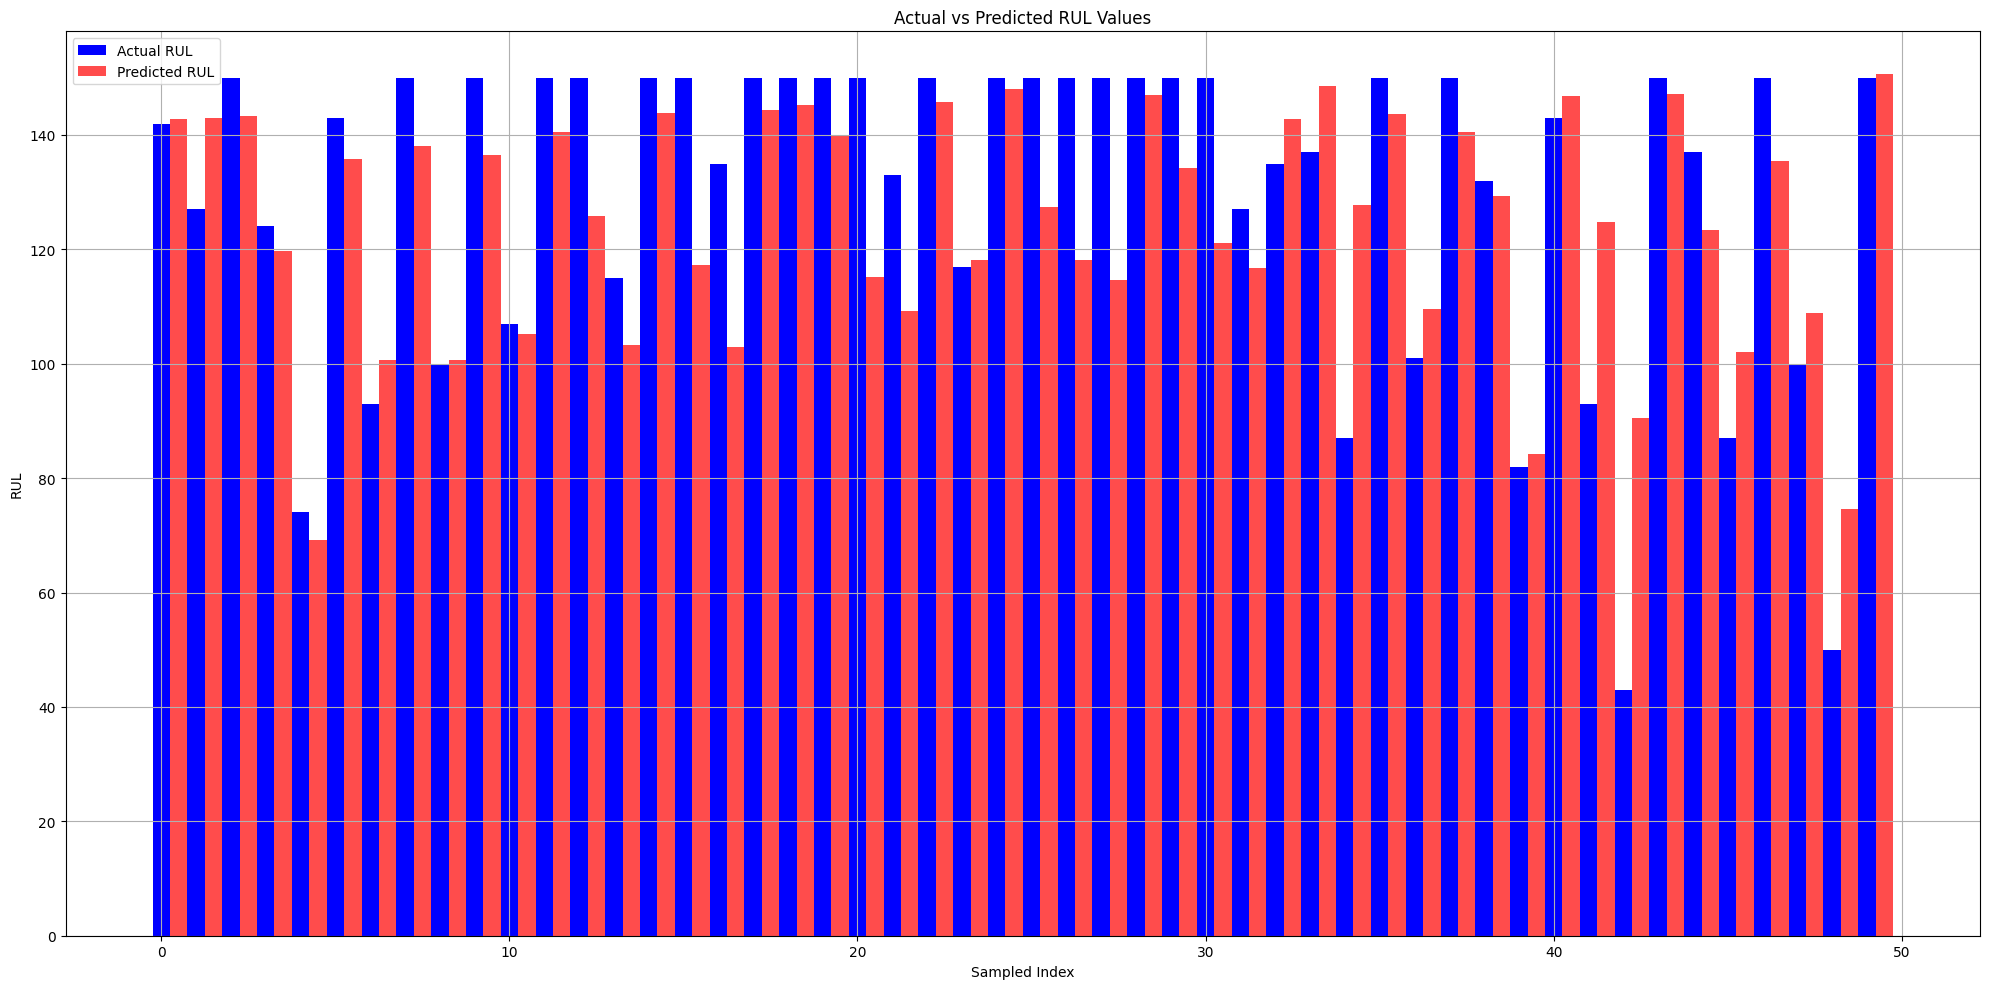

In [76]:
#Final Model Evaluation

start_time = time.time() #start tracking time

#evaluating the reconstructed dataset
xgb_recon_clip_train_rmse, xgb_recon_clip_val_rmse, xgb_recon_clip_test_rmse = xgb_final_evaluation(reconstructed_train_dataset_clipped, reconstructed_test_dataset_clipped)

end_time = time.time() #stop tracking time
xgb_recon_clip_duration = end_time - start_time #total duration

In [77]:
final_model_evaluation = pd.DataFrame({"Dataset": ["Reconstructed Dataset after RUL Clipping"], "Training RMSE": [xgb_recon_clip_train_rmse], "Validation RMSE": [xgb_recon_clip_val_rmse], "Testing RMSE": [xgb_recon_clip_test_rmse], "Duration(seconds)" : [xgb_recon_clip_duration]})
final_model_evaluation

,Dataset,Training RMSE,Validation RMSE,Testing RMSE,Duration(seconds)
0,Reconstructed Dataset after RUL Clipping,19.891681,20.466807,21.57304,4.755742


From this graph we can see that the actual and predicted RULs (remaining useful life) in the sample are very similar in comparison to the actual and predicted RULs in the previous model.

After evaluation of several machine learning models and data analysis techniques, we can see that the xGBoost algorithm trained with the reconstructed and clipped dataset provides the greatest predictive performance out of all the tested models. 

The results of the evaluation reported training, validation and testing RMSE values of 19.9, 20.5 and 21.6, respectively.

The execution time of the model was 4.76 seconds, suggesting that it is also a relatively efficient model to run. Therefore, we can conclude that in terms of predictive performance and efficiency, the xGBoost model is the best choice for real-world deployment.

We will be building this model in a cloud environment which is able to handle large amounts of sensor data.

**REFERENCES AND BIBLIOGRAPHY**

1.	Alabdullatef, L. (2020). Complete Guide to Adam Optimization. Medium. Available at: https://towardsdatascience.com/complete-guide-to-adam-optimization-1e5f29532c3d#:~:text=Adam%20is%20also%20an%20adaptive [Accessed 10 Aug. 2023].

2.	Alkousa, O. (2023). Fourier Transform, the Practical PythonImplementation. [online] Medium. Available at: https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a.[Accessed 12 Aug. 2023]

3.	Analytics Vidhya (2016). Understanding Assumptions of Linear Regression: Plots & Solutions. Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2016/07/deeper-regression-analysis-assumptions-plots-solutions/#:~:text=The%20assumptions%20of%20linear%20regression%20in%20data%20science%20are%20linearity. [Accessed: 10 Jul. 2023]

4.	Arya, N. (2022). Tuning Random Forest Hyperparameters. [online] KDnuggets. Available at: https://www.kdnuggets.com/2022/08/tuning-random-forest-hyperparameters.html [Accessed 15 Jul. 2023].

5.	Banerjee, P. (2020). A Guide on XGBoost hyperparameters tuning. [online] kaggle.com. Available at: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning [Accessed 10 Aug. 2023].

6.	Bhuwanesh (2022). How to Perform a Breusch-Pagan Test inPython. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/[Accessed 16 Jun. 2023].

7.	Bibi, K. (2022). SciPy Find Peaks. [online] Linux Hint.Available at: https://linuxhint.com/scipy-find-peaks/ [Accessed 15 Aug. 2023].

8.	Brownlee, J. (2016). Time Series Prediction with LSTMRecurrent Neural Networks in Python with Keras. [online] Machine LearningMastery. Available at: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/[Accessed 1 Aug. 2023].

9.	Brownlee, J. (2017). How to Use Dropout with LSTM Networks for Time Series Forecasting. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/ [Accessed 8 Jul. 2023].

10.	Brownlee, J. (2018a). How to Develop LSTM Models for Time Series Forecasting. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ [Accessed 5 Jul. 2023].

11.	Brownlee, J. (2018b). Use Early Stopping to Halt the Training of Neural Networks At the Right Time. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ [Accessed 12 Jun. 2023].

12.	Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU) for Deep Learning Neural Networks. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 10 Aug. 2023].

13.	Brownlee, J. (2020a). How to Use StandardScaler and MinMaxScaler Transforms in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/[Accessed 30 Jul. 2023].

14.	Brownlee, J. (2020b). Extreme Gradient Boosting (XGBoost) Ensemble in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/ [Accessed 13 Aug. 2023].

15.	Cambridge Spark (2019). Hyperparameter tuning in XGBoost.[online] Medium. Available at: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f [Accessed 25 Jul. 2023].

16.	Cambridge Spark (2019). Hyperparameter tuning in XGBoost.[online] Medium. Available at: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f[Accessed 26 Jul. 2023].

17.	Chao, M.A., Kulkarni, C., Goebel, K. and Fink, O. (2021). Aircraft engine run-to-failure dataset under real flight conditions for prognostics and diagnostics. Data, 6(1), p.5.

18.	Chollet, F. (2023). The Sequential model | TensorFlow Core.[online] TensorFlow. Available at: https://www.tensorflow.org/guide/keras/sequential_model [Accessed 1 Aug. 2023].

19.	Cosine1509 (2020). Detecting Multicollinearity with VIF -Python. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/.[Accessed 14 Jun. 2023].

20.	DataQ Instruments (2023). FFT (Fast Fourier Transform) Waveform Analysis. [online] Dataq.com. Available at: https://www.dataq.com/data-acquisition/general-education-tutorials/fft-fast-fourier-transform-waveform-analysis.html [Accessed 18 Jul. 2023].

21.	Faroit (2023). Guide to the Sequential model - Keras 1.2.2Documentation. [online] faroit.com. Available at: https://faroit.com/keras-docs/1.2.2/getting-started/sequential-model-guide/[Accessed 1 Aug. 2023].

22.	Geeks For Geeks (2023). Plot the magnitude spectrum in Python using Matplotlib - GeeksforGeeks. [online] www.geeksforgeeks.org. Available at: https://www.geeksforgeeks.org/plot-the-magnitude-spectrum-in-python-using-matplotlib/amp/ [Accessed 17 Jul. 2023].

23.	Jackson (2021). Remove the negative frequency components of the signal. [online] uk.mathworks.com. Available at: https://uk.mathworks.com/matlabcentral/answers/1575073-remove-the-negative-frequency-components-of-the-signal [Accessed 18 Jul. 2023].

24.	Jain, A. (2016). Mastering XGBoost Parameter Tuning: AComplete Guide with Python Codes. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#:~:text=What%20are%20different%20hyperparameters%20in[Accessed 26 Jul. 2023].

25.	Jha, V. (2021). Multicollinearity in Data. [online] GeeksforGeeks. Available at: http://geeksforgeeks.org/multicollinearity-in-data/#article-meta-div [Accessed 10 Jul. 2023].

26.	Jitender_1998 (2020). statsmodels.durbin_watson() in Python.[online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/statsmodels-durbin_watson-in-python/ [Accessed 14Aug. 2023].

27.	Khandelwal, N. (2020). Fine Tuning XGBoost model. [online]Medium. Available at: https://towardsdatascience.com/fine-tuning-xgboost-model-257868cf4187#:~:text=gamma%3A%20It%20is%20the%20minimum[Accessed 26 Jul. 2023].

28.	Koehrsen, W. (2018). Hyperparameter Tuning the Random Forestin Python. [online] Medium. Available at: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74[Accessed 7 Jul. 2023].

29.	Korstanje, J. (2021). Fourier Transform for Time Series. [online] Medium. Available at: https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101 [Accessed 20 Aug. 2023].

30.	Kumar, A. (2023). SVM RBF Kernel Parameters: Python Examples. [online] Analytics Yogi. Available at: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/#:~:text=C- [Accessed 12 Aug. 2023].

31.	Kutz, N. (2018). Time Frequency Analysis & Fourier Transforms. YouTube. Available at: https://www.youtube.com/watch?v=wiMge5T3d9I [Accessed 16 Jul. 2023].

32.	MacLeod, C. (2020). Fourier Transforms With scipy.fft:Python Signal Processing – Real Python. [online] Real Python. Available at: https://realpython.com/python-scipy-fft/ [Accessed 15 Aug. 2023]. 

33.	Malato, G. (2021). How to use Q-Q plot for checking thedistribution of our data. [online] Your Data Teacher. Available at: https://www.yourdatateacher.com/2021/06/21/how-to-use-q-q-plot-for-checking-the-distribution-of-our-data/.[Accessed 12 Jun. 2023].

34.	MathWorks (2023). Practical Introduction to Frequency-Domain Analysis - MATLAB & Simulink Example - MathWorks United Kingdom. [online] uk.mathworks.com. Available at: https://uk.mathworks.com/help/signal/ug/practical-introduction-to-frequency-domain-analysis.html [Accessed 17 Jul. 2023].

35.	MRK (2020). keras lstm incorrect input_shape. [online] StackOverflow. Available at: https://stackoverflow.com/questions/61871071/keras-lstm-incorrect-input-shape[Accessed 1 Aug. 2023].

36.	Nikki2398 (2020). XGBoost for Regression. [online]GeeksforGeeks. Available at: https://www.geeksforgeeks.org/xgboost-for-regression/ [Accessed 25 Jul. 2023].

37.	Rybnik, R. (2022). Introduction to Fourier analysis of time series. [online] Medium. Available at: https://fischerbach.medium.com/introduction-to-fourier-analysis-of-time-series-42151703524a#:~:text=Fourier%20analysis%20converts%20a%20time [Accessed 19 Aug. 2023].

38.	Scikit-Learn Developers (2019).sklearn.linear_model.LinearRegression — scikit-learn 0.22 documentation.[online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html[Accessed 15 Jun. 2023].

39.	Scikit-Learn Developers (2023a).sklearn.metrics.mean_squared_error — scikit-learn 0.24.2 documentation.[online] scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html[Accessed 20 Jun. 2023].

40.	Scikit-Learn Developers (2023b).sklearn.ensemble.BaggingRegressor. [online] scikit-learn. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor[Accessed 15 Jul. 2023].

41.	Scikit-Learn Developers (2023c). Comparing Random Forestsand Histogram Gradient Boosting models. [online] scikit-learn. Available at: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html#sphx-glr-auto-examples-ensemble-plot-forest-hist-grad-boosting-comparison-py[Accessed 26 Jul. 2023].

42.	Scikit-Learn Developers (2023d). sklearn.svm.SVR —scikit-learn 0.23.1 documentation. [online] scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html[Accessed 30 Jul. 2023].

43.	Scikit-Learn Developers (2023e). 3.1. Cross-validation: evaluatingestimator performance — scikit-learn 0.21.3 documentation. [online]Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/cross_validation.html [Accessed 20 Jun.2023].

44.	SciPy (2023). scipy.signal.find_peaks — SciPy v1.6.0Reference Guide. [online] docs.scipy.org. Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html[Accessed 12 Aug. 2023].

45.	Sethi, A. (2020). Support Vector Regression Tutorial for Machine Learning. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/#h-what-is-a-support-vector-machine-svm [Accessed 15 Aug. 2023].

46.	Smith, T. (2023). What Is Autocorrelation? [online]Investopedia. Available at: https://www.investopedia.com/terms/a/autocorrelation.asp#:~:text=Autocorrelation%20represents%20the%20degree%20of.[Accessed 14 Jun. 2023].

47.	Sotiriadis S., 2022. Class 8: Introduction to continuous data analysis. Lecture slides. Programming with Data. Birkbeck University of London, delivered November 2022.

48.	Vadapalli, P. (2022). Random Forest Hyperparameter Tuning: Processes Explained with Coding. [online] upGrad blog. Available at: https://www.upgrad.com/blog/random-forest-hyperparameter-tuning/ [Accessed 12 Aug. 2023].

49.	Vetrivel, K. (2019). LSTM-on-Amazon-Fine-Food-Review-Data-set/LSTM/2.LSTM_AFR_dataset.ipynb at master · Karthikprabuvetrivel/LSTM-on-Amazon-Fine-Food-Review-Data-set. [online] GitHub. Available at: https://github.com/Karthikprabuvetrivel/LSTM-on-Amazon-Fine-Food-Review-Data-set/blob/master/LSTM/2.LSTM_AFR_dataset.ipynb [Accessed 5 Aug. 2023].

50.	XGBoost Developers (2021). Python API Reference — xgboost 1.5.0 documentation. [online] Readthedocs.io. Available 51.	Yildirim, S. (2020). Hyperparameter tuning for support vector machines - C and gamma parameters. Medium. Available at: https://towardachines-c-and-gamma-parameters-6a5097416167 [Accessed: 10 Aug. 2023].

51.	Yildirim, S. (2020). Hyperparameter tuning for support vector machines - C and gamma parameters. Medium. Available at: https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167 [Accessed: 10 Aug. 2023].